## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


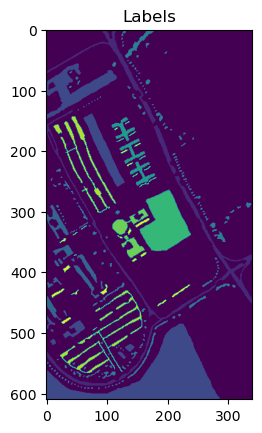

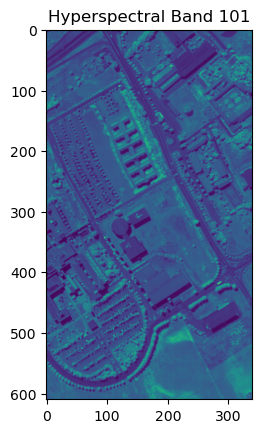

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 40 train


All datasets saved to the 'indices' folder.
(360, 5, 5, 103)
(45, 5, 5, 103)
(42371, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1211, PSNR: 7.4221


	 Training Batch [200/535], Loss: 0.0679, PSNR: 8.4890


	 Training Batch [400/535], Loss: 0.0319, PSNR: 13.1180


Epoch [1/50] Training Loss: 0.0566, PSNR: 11.1497
	[Val]   Batch [1/134] Loss: 0.0190, PSNR: 15.4046
	[Val]   Batch [10/134] Loss: 0.0168, PSNR: 17.7587
	[Val]   Batch [20/134] Loss: 0.0179, PSNR: 15.5713
	[Val]   Batch [30/134] Loss: 0.0195, PSNR: 15.0290
	[Val]   Batch [40/134] Loss: 0.0176, PSNR: 14.0856
	[Val]   Batch [50/134] Loss: 0.0188, PSNR: 15.2177
	[Val]   Batch [60/134] Loss: 0.0169, PSNR: 15.9295


	[Val]   Batch [70/134] Loss: 0.0161, PSNR: 16.1049
	[Val]   Batch [80/134] Loss: 0.0158, PSNR: 16.0925
	[Val]   Batch [90/134] Loss: 0.0166, PSNR: 16.0630
	[Val]   Batch [100/134] Loss: 0.0188, PSNR: 15.4713
	[Val]   Batch [110/134] Loss: 0.0191, PSNR: 13.9971
	[Val]   Batch [120/134] Loss: 0.0156, PSNR: 15.1790
	[Val]   Batch [130/134] Loss: 0.0172, PSNR: 13.2063
Epoch [1/50] Validation Loss: 0.0180, PSNR: 15.4359

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0168, PSNR: 15.6370


	 Training Batch [200/535], Loss: 0.0118, PSNR: 17.4341


	 Training Batch [400/535], Loss: 0.0086, PSNR: 18.7341


Epoch [2/50] Training Loss: 0.0117, PSNR: 17.4387
	[Val]   Batch [1/134] Loss: 0.0087, PSNR: 18.8100
	[Val]   Batch [10/134] Loss: 0.0069, PSNR: 21.5836
	[Val]   Batch [20/134] Loss: 0.0075, PSNR: 19.3546
	[Val]   Batch [30/134] Loss: 0.0086, PSNR: 18.5996
	[Val]   Batch [40/134] Loss: 0.0076, PSNR: 17.7085
	[Val]   Batch [50/134] Loss: 0.0080, PSNR: 18.9414
	[Val]   Batch [60/134] Loss: 0.0069, PSNR: 19.7995


	[Val]   Batch [70/134] Loss: 0.0068, PSNR: 19.8712
	[Val]   Batch [80/134] Loss: 0.0065, PSNR: 19.9668
	[Val]   Batch [90/134] Loss: 0.0069, PSNR: 19.8863
	[Val]   Batch [100/134] Loss: 0.0082, PSNR: 19.0556
	[Val]   Batch [110/134] Loss: 0.0078, PSNR: 17.8910
	[Val]   Batch [120/134] Loss: 0.0058, PSNR: 19.4752
	[Val]   Batch [130/134] Loss: 0.0070, PSNR: 17.1184
Epoch [2/50] Validation Loss: 0.0078, PSNR: 19.0803

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0078, PSNR: 19.3207


	 Training Batch [200/535], Loss: 0.0074, PSNR: 19.5732


	 Training Batch [400/535], Loss: 0.0048, PSNR: 18.8922


Epoch [3/50] Training Loss: 0.0068, PSNR: 19.7025
	[Val]   Batch [1/134] Loss: 0.0059, PSNR: 20.4518
	[Val]   Batch [10/134] Loss: 0.0047, PSNR: 23.2898
	[Val]   Batch [20/134] Loss: 0.0050, PSNR: 21.1365
	[Val]   Batch [30/134] Loss: 0.0057, PSNR: 20.3529
	[Val]   Batch [40/134] Loss: 0.0052, PSNR: 19.4147
	[Val]   Batch [50/134] Loss: 0.0053, PSNR: 20.7575
	[Val]   Batch [60/134] Loss: 0.0046, PSNR: 21.5742


	[Val]   Batch [70/134] Loss: 0.0046, PSNR: 21.5881
	[Val]   Batch [80/134] Loss: 0.0043, PSNR: 21.7288
	[Val]   Batch [90/134] Loss: 0.0046, PSNR: 21.6352
	[Val]   Batch [100/134] Loss: 0.0056, PSNR: 20.7475
	[Val]   Batch [110/134] Loss: 0.0050, PSNR: 19.7996
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5102
	[Val]   Batch [130/134] Loss: 0.0045, PSNR: 19.0049
Epoch [3/50] Validation Loss: 0.0053, PSNR: 20.7816

LOG: Epoch [4/50]


	 Training Batch [1/535], Loss: 0.0060, PSNR: 22.2337


	 Training Batch [200/535], Loss: 0.0049, PSNR: 20.3636


	 Training Batch [400/535], Loss: 0.0038, PSNR: 22.2256


Epoch [4/50] Training Loss: 0.0048, PSNR: 21.2351
	[Val]   Batch [1/134] Loss: 0.0041, PSNR: 22.0879
	[Val]   Batch [10/134] Loss: 0.0033, PSNR: 24.8386
	[Val]   Batch [20/134] Loss: 0.0033, PSNR: 22.9124
	[Val]   Batch [30/134] Loss: 0.0038, PSNR: 22.1514
	[Val]   Batch [40/134] Loss: 0.0034, PSNR: 21.2143
	[Val]   Batch [50/134] Loss: 0.0034, PSNR: 22.6861


	[Val]   Batch [60/134] Loss: 0.0033, PSNR: 23.0187
	[Val]   Batch [70/134] Loss: 0.0032, PSNR: 23.1360
	[Val]   Batch [80/134] Loss: 0.0030, PSNR: 23.2618
	[Val]   Batch [90/134] Loss: 0.0032, PSNR: 23.2113
	[Val]   Batch [100/134] Loss: 0.0038, PSNR: 22.3921
	[Val]   Batch [110/134] Loss: 0.0032, PSNR: 21.7568
	[Val]   Batch [120/134] Loss: 0.0024, PSNR: 23.2862
	[Val]   Batch [130/134] Loss: 0.0029, PSNR: 20.8854
Epoch [4/50] Validation Loss: 0.0036, PSNR: 22.4172

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 21.0868


	 Training Batch [200/535], Loss: 0.0033, PSNR: 23.0084


	 Training Batch [400/535], Loss: 0.0029, PSNR: 25.3843


Epoch [5/50] Training Loss: 0.0035, PSNR: 22.6353
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.3361
	[Val]   Batch [10/134] Loss: 0.0024, PSNR: 26.1225
	[Val]   Batch [20/134] Loss: 0.0023, PSNR: 24.4748
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.6586
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.7615
	[Val]   Batch [50/134] Loss: 0.0023, PSNR: 24.2824
	[Val]   Batch [60/134] Loss: 0.0025, PSNR: 24.2044


	[Val]   Batch [70/134] Loss: 0.0024, PSNR: 24.3990
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.5177
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.4613
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.7768
	[Val]   Batch [110/134] Loss: 0.0021, PSNR: 23.5016
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.8148
	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.4263
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.7723

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0034, PSNR: 22.9427


	 Training Batch [200/535], Loss: 0.0024, PSNR: 24.2253


	 Training Batch [400/535], Loss: 0.0028, PSNR: 23.6621


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.5183
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.0633
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9007
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.4143
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5548
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.7095
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2454
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9469


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1696
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3315
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.1823
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5971
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5723
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.8336
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3147
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.5938

LOG: Epoch [7/50]


	 Training Batch [1/535], Loss: 0.0019, PSNR: 23.6694


	 Training Batch [200/535], Loss: 0.0026, PSNR: 22.7898


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.2786


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0888
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5768
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4496
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1791
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.2321
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.4447
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9565
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4625


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.7020
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 25.9101
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6986
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2112
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3915
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5648
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 23.9859
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2091

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0030, PSNR: 23.1878


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.1398


	 Training Batch [400/535], Loss: 0.0032, PSNR: 23.1111


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5764
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 25.0125
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.9063
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 26.8125
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.8117
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0620
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.5645
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.9422
	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1826


	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.4110
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1450
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7356
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 26.0781
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.2249
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.5318
Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.7346

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.3034


	 Training Batch [200/535], Loss: 0.0014, PSNR: 24.5069


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.4222


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9183
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2662
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1660
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.1947
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.1401
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4242
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8754
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2154


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4561
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.7127
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.4058
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 26.0327
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4465
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.6004
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.8714
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.0419

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.5831


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2818


	 Training Batch [400/535], Loss: 0.0030, PSNR: 24.2491


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2152
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4677
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.3866
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4672
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3801
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6821
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1020
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4273


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6540
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9572
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6143
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2516
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.6947
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8342
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1017
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2752

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.5180


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.5448


	 Training Batch [400/535], Loss: 0.0032, PSNR: 23.3540


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4390
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.7882
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7157
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9364
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8060
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.1435
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5196
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8002


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9959
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.3498
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9568
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6240
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2370
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.3267
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5523
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6740

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5380


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.9062


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.7851


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6347
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8939
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8420
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1034
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.9493
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2962
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.6546
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9418
	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1301


	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.4931
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0872
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7610
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3997
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4633
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6869
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.8132

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4213


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3632


	 Training Batch [400/535], Loss: 0.0011, PSNR: 25.8833


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8681
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0680
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0127
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3784
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1487
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5439
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8304
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1500


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3315
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7123
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2774
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9566
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5955
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6658
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9342
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0292

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 27.3647


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.1923


	 Training Batch [400/535], Loss: 0.0019, PSNR: 27.1855


Epoch [14/50] Training Loss: 0.0016, PSNR: 26.0022
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3227
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2660
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7205
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4598
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8564
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1564


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4043
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5472
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9907
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5462
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2433
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9807
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 28.9750
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2459
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3152

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.8113


	 Training Batch [200/535], Loss: 0.0013, PSNR: 25.7112


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.6259


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1434
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4032
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3273
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8376
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5401
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.9319
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2055
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5117


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6461
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0858
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6571
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3125
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9916
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 28.9753
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3097
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.3992

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.7070


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.7953


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1031


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2768
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.5988
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5318
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1443
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7697
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1957
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4088
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8090


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.9220
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3650
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8951
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5391
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2085
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2754
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5731


Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6404

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9680


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.5270


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.0380


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4296
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8193
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7037
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4136
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0473
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4630
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6679
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0467


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1476
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5888
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1194
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8046
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5073
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4491
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8365
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8825

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.5266


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.7423


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.4945


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5458
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0808
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8945
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7508
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3720
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7361
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9334
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3119


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3927
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8546
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4110
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0885
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7405
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6192
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1076
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1416

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.3044


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.2322


	 Training Batch [400/535], Loss: 0.0016, PSNR: 28.0699


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7679
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3057
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0796
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0643
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.6293
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.9996
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1704
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6288


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7080
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.1095
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6844
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3431
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8891
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8389
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3831
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.3921

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 28.5363


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.0758


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.8869


Epoch [20/50] Training Loss: 0.0013, PSNR: 27.0340
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.5727
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2456
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3184
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.9216
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2297
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4159
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 28.9278


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.9918
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3671
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 28.9898
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.6003
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0408
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9531
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5708
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.6314

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.3641


	 Training Batch [200/535], Loss: 0.0010, PSNR: 25.7208


	 Training Batch [400/535], Loss: 0.0011, PSNR: 25.5324


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1355
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.8913
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4893
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6519
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.3110
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.5201
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7768


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.2861
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3199
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6727
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.3625
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9941
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2755
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0668
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8788
Epoch [21/50] Validation Loss: 0.0008, PSNR: 28.9440

LOG: Epoch [22/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 25.7458


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.8819


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5225


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.3634
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2149
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7323
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0267
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6245
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8419
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0047
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6164


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7340
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 29.9784
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7492
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3194
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4400
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3467
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1898
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.2635

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.8470


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.6010


	 Training Batch [400/535], Loss: 0.0014, PSNR: 27.5253


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5582
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4960
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9460
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2561
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9892
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0888
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3709


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9124
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 30.0323
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2135
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0611
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6637
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6935
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4973
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4615
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.5531

LOG: Epoch [24/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.2003


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.6184


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.6744


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7594
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9020
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.2383
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5456
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3360
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.3539
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7019
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1841


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3645
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4690
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4091
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9933
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9035
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6832
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6590
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.8629

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 27.6736


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.7428


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.3601


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9068
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0679
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3513
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6150
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.5360
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4288
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8051


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2912
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5257
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5726
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5521
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1567
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8998
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6839


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7149
Epoch [25/50] Validation Loss: 0.0006, PSNR: 29.9968

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6341


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.7738


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.7542


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0612
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3481
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5964
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8724
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8233
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6224
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0749
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4997


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7673
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7817
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8326
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3881
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1121
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8830
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9075
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.2394

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.5229


	 Training Batch [200/535], Loss: 0.0007, PSNR: 29.4086


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.4200


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2269
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.5410
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7452
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0522
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9682
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7427
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1826
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.6305


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.9440
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8747
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.0091
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5556
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1872
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9606


	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.0299
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.4164

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9973


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.8496


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.9642


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.3378
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7730
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.8656
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1249
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1651
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.8298
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.3798
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7356


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.0386
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0514
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1318
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.7250
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.2705
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0140
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1017


Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.5489

LOG: Epoch [29/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.1399


	 Training Batch [200/535], Loss: 0.0014, PSNR: 28.6092


	 Training Batch [400/535], Loss: 0.0008, PSNR: 28.9232


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.4738
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.9638
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9712
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1942
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.3270
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9495
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4821
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8220


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1915
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.1675
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2825
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9064
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3353
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0920
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1908
Epoch [29/50] Validation Loss: 0.0005, PSNR: 30.7002
Early stopping triggered at epoch 29. No improvement for 3 epochs.


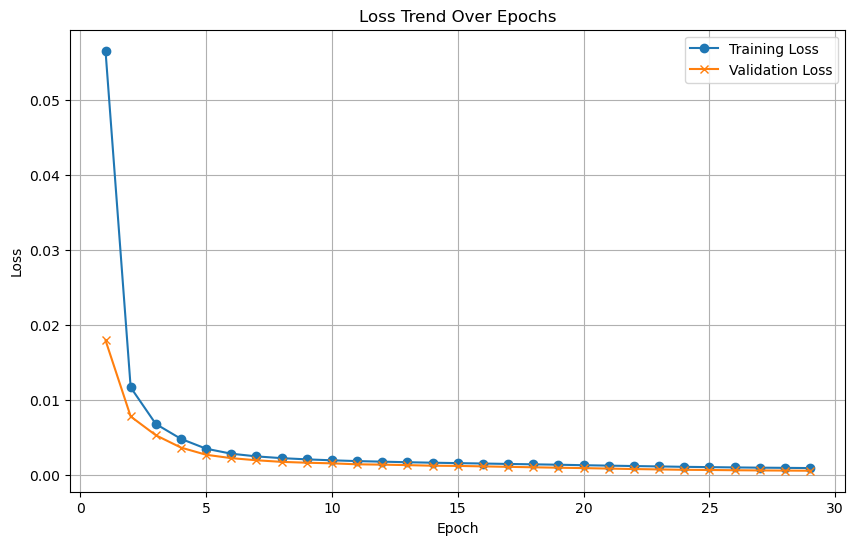

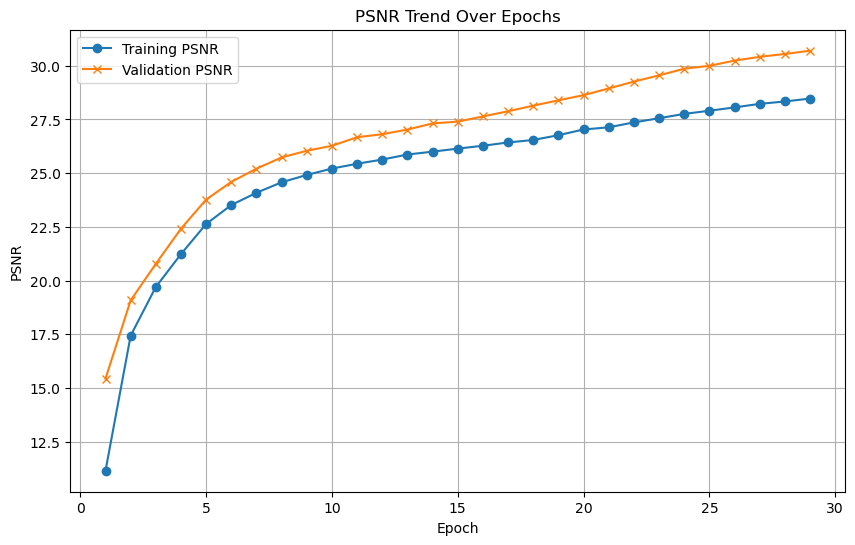

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/166 for test dataset.


    Processed batch 101/166 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1825
    Validation Batch [1/1], Loss: 2.2023
Validation Loss: 2.2023, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2023. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1188
    Validation Batch [1/1], Loss: 2.2022
Validation Loss: 2.2022, Validation Accuracy: 11.11%
Validation loss improved from 2.2023 to 2.2022. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0830
    Validation Batch [1/1], Loss: 2.2021
Validation Loss: 2.2021, Validation Accuracy: 11.11%
Validation loss improved from 2.2022 to 2.2021. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0579
    Validation Batch [1/1], Loss: 2.2019
Validation Loss: 2.2019, Validation Accuracy: 11.11%
Validation loss improved from 2.2021 to 2.2019. Saving model...

LOG: Epoch [5/1000

Epoch [12/1000] completed, Average Training Loss: 1.8819
    Validation Batch [1/1], Loss: 2.1868
Validation Loss: 2.1868, Validation Accuracy: 22.22%
Validation loss improved from 2.1912 to 2.1868. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 1.8634
    Validation Batch [1/1], Loss: 2.1801
Validation Loss: 2.1801, Validation Accuracy: 33.33%
Validation loss improved from 2.1868 to 2.1801. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 1.8432
    Validation Batch [1/1], Loss: 2.1693
Validation Loss: 2.1693, Validation Accuracy: 33.33%
Validation loss improved from 2.1801 to 2.1693. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 1.8294
    Validation Batch [1/1], Loss: 2.1535
Validation Loss: 2.1535, Validation Accuracy: 33.33%
Validation loss improved from 2.1693 to 2.1535. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [1

Epoch [28/1000] completed, Average Training Loss: 1.6271
    Validation Batch [1/1], Loss: 1.7368
Validation Loss: 1.7368, Validation Accuracy: 57.78%
Validation loss improved from 1.7676 to 1.7368. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 1.6022
    Validation Batch [1/1], Loss: 1.7075
Validation Loss: 1.7075, Validation Accuracy: 60.00%
Validation loss improved from 1.7368 to 1.7075. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 1.6046
    Validation Batch [1/1], Loss: 1.6744
Validation Loss: 1.6744, Validation Accuracy: 60.00%
Validation loss improved from 1.7075 to 1.6744. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 1.5736
    Validation Batch [1/1], Loss: 1.6433
Validation Loss: 1.6433, Validation Accuracy: 64.44%
Validation loss improved from 1.6744 to 1.6433. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [3

Epoch [45/1000] completed, Average Training Loss: 1.3816
    Validation Batch [1/1], Loss: 1.3963
Validation Loss: 1.3963, Validation Accuracy: 68.89%
Validation loss improved from 1.4166 to 1.3963. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.3756
    Validation Batch [1/1], Loss: 1.4010
Validation Loss: 1.4010, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 1.3420
    Validation Batch [1/1], Loss: 1.3814
Validation Loss: 1.3814, Validation Accuracy: 68.89%
Validation loss improved from 1.3963 to 1.3814. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.3361
    Validation Batch [1/1], Loss: 1.3550
Validation Loss: 1.3550, Validation Accuracy: 64.44%
Validation loss improved from 1.3814 to 1.3550. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] complet

    Validation Batch [1/1], Loss: 1.2056
Validation Loss: 1.2056, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.1479
    Validation Batch [1/1], Loss: 1.1766
Validation Loss: 1.1766, Validation Accuracy: 71.11%
Validation loss improved from 1.2032 to 1.1766. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.1184
    Validation Batch [1/1], Loss: 1.1622
Validation Loss: 1.1622, Validation Accuracy: 75.56%
Validation loss improved from 1.1766 to 1.1622. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.1268
    Validation Batch [1/1], Loss: 1.1912
Validation Loss: 1.1912, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.1047
    Validation Batch [1/1], Loss: 1.15

Epoch [81/1000] completed, Average Training Loss: 0.9374
    Validation Batch [1/1], Loss: 1.0592
Validation Loss: 1.0592, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 0.8948
    Validation Batch [1/1], Loss: 1.0265
Validation Loss: 1.0265, Validation Accuracy: 75.56%
Validation loss improved from 1.0329 to 1.0265. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 0.9056
    Validation Batch [1/1], Loss: 0.9564
Validation Loss: 0.9564, Validation Accuracy: 82.22%
Validation loss improved from 1.0265 to 0.9564. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 0.8877
    Validation Batch [1/1], Loss: 0.9824
Validation Loss: 0.9824, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 0.8876
Validation Loss: 0.8876, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 0.7047
    Validation Batch [1/1], Loss: 0.8029
Validation Loss: 0.8029, Validation Accuracy: 88.89%
Validation loss improved from 0.8205 to 0.8029. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 0.6940
    Validation Batch [1/1], Loss: 0.7854
Validation Loss: 0.7854, Validation Accuracy: 88.89%
Validation loss improved from 0.8029 to 0.7854. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 0.6775
    Validation Batch [1/1], Loss: 0.7920
Validation Loss: 0.7920, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 0.6613
    Validation Batch [1/1], Loss

Epoch [115/1000] completed, Average Training Loss: 0.5339
    Validation Batch [1/1], Loss: 0.6589
Validation Loss: 0.6589, Validation Accuracy: 88.89%
Validation loss improved from 0.6607 to 0.6589. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.5263
    Validation Batch [1/1], Loss: 0.6449
Validation Loss: 0.6449, Validation Accuracy: 91.11%
Validation loss improved from 0.6589 to 0.6449. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.5177
    Validation Batch [1/1], Loss: 0.6256
Validation Loss: 0.6256, Validation Accuracy: 91.11%
Validation loss improved from 0.6449 to 0.6256. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.4987
    Validation Batch [1/1], Loss: 0.6113
Validation Loss: 0.6113, Validation Accuracy: 93.33%
Validation loss improved from 0.6256 to 0.6113. Saving model...

LOG: Epoch [119/1000] - Training


Epoch [134/1000] completed, Average Training Loss: 0.3844
    Validation Batch [1/1], Loss: 0.5643
Validation Loss: 0.5643, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.3696
    Validation Batch [1/1], Loss: 0.5151
Validation Loss: 0.5151, Validation Accuracy: 91.11%
Validation loss improved from 0.5337 to 0.5151. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.3712
    Validation Batch [1/1], Loss: 0.5438
Validation Loss: 0.5438, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.3723
    Validation Batch [1/1], Loss: 0.5365
Validation Loss: 0.5365, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training 

Epoch [151/1000] completed, Average Training Loss: 0.2489
    Validation Batch [1/1], Loss: 0.4465
Validation Loss: 0.4465, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.2629
    Validation Batch [1/1], Loss: 0.4304
Validation Loss: 0.4304, Validation Accuracy: 93.33%
Validation loss improved from 0.4355 to 0.4304. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.2537
    Validation Batch [1/1], Loss: 0.4518
Validation Loss: 0.4518, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.2602
    Validation Batch [1/1], Loss: 0.4323
Validation Loss: 0.4323, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training 

Epoch [168/1000] completed, Average Training Loss: 0.1926
    Validation Batch [1/1], Loss: 0.4250
Validation Loss: 0.4250, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.1751
    Validation Batch [1/1], Loss: 0.4451
Validation Loss: 0.4451, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.1889
    Validation Batch [1/1], Loss: 0.4396
Validation Loss: 0.4396, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.1717
    Validation Batch [1/1], Loss: 0.4534
Validation Loss: 0.4534, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.1642
  

Epoch [186/1000] completed, Average Training Loss: 0.1372
    Validation Batch [1/1], Loss: 0.3281
Validation Loss: 0.3281, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.1340
    Validation Batch [1/1], Loss: 0.3941
Validation Loss: 0.3941, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.4556
Validation Loss: 0.4556, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.1272
    Validation Batch [1/1], Loss: 0.3575
Validation Loss: 0.3575, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.1253
  

Epoch [203/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.3903
Validation Loss: 0.3903, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.1034
    Validation Batch [1/1], Loss: 0.3063
Validation Loss: 0.3063, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.0955
    Validation Batch [1/1], Loss: 0.3243
Validation Loss: 0.3243, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.0931
    Validation Batch [1/1], Loss: 0.3202
Validation Loss: 0.3202, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.107

    Validation Batch [1/1], Loss: 0.2787
Validation Loss: 0.2787, Validation Accuracy: 95.56%
Validation loss improved from 0.2805 to 0.2787. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 0.2858
Validation Loss: 0.2858, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.3191
Validation Loss: 0.3191, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.3348
Validation Loss: 0.3348, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.0710
    Validation Batch [1/1], Loss: 0.2817
Vali

Epoch [239/1000] completed, Average Training Loss: 0.0654
    Validation Batch [1/1], Loss: 0.2812
Validation Loss: 0.2812, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.2930
Validation Loss: 0.2930, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.2695
Validation Loss: 0.2695, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.0541
    Validation Batch [1/1], Loss: 0.2625
Validation Loss: 0.2625, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.0561
  

Epoch [257/1000] completed, Average Training Loss: 0.0518
    Validation Batch [1/1], Loss: 0.2719
Validation Loss: 0.2719, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.2610
Validation Loss: 0.2610, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.2820
Validation Loss: 0.2820, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.2817
Validation Loss: 0.2817, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0473
  

Epoch [276/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.2498
Validation Loss: 0.2498, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.0327
    Validation Batch [1/1], Loss: 0.2619
Validation Loss: 0.2619, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.2947
Validation Loss: 0.2947, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.2947
Validation Loss: 0.2947, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.037

Epoch [293/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.2570
Validation Loss: 0.2570, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.2236
Validation Loss: 0.2236, Validation Accuracy: 97.78%
Validation loss improved from 0.2315 to 0.2236. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.2600
Validation Loss: 0.2600, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.2687
Validation Loss: 0.2687, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training

Epoch [311/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.2558
Validation Loss: 0.2558, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.2604
Validation Loss: 0.2604, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.2739
Validation Loss: 0.2739, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.2418
Validation Loss: 0.2418, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0261
  

Epoch [328/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.2680
Validation Loss: 0.2680, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.2892
Validation Loss: 0.2892, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0292
    Validation Batch [1/1], Loss: 0.2647
Validation Loss: 0.2647, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.2884
Validation Loss: 0.2884, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.028

Epoch [347/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.2341
Validation Loss: 0.2341, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.2266
Validation Loss: 0.2266, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0209
    Validation Batch [1/1], Loss: 0.2468
Validation Loss: 0.2468, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.2618
Validation Loss: 0.2618, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.022

Epoch [365/1000] completed, Average Training Loss: 0.0186
    Validation Batch [1/1], Loss: 0.2190
Validation Loss: 0.2190, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.2258
Validation Loss: 0.2258, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.2640
Validation Loss: 0.2640, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.3435
Validation Loss: 0.3435, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.019

Epoch [382/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.3363
Validation Loss: 0.3363, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.2904
Validation Loss: 0.2904, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.2653
Validation Loss: 0.2653, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.2748
Validation Loss: 0.2748, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.016

Epoch [399/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.2985
Validation Loss: 0.2985, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.2792
Validation Loss: 0.2792, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0122
    Validation Batch [1/1], Loss: 0.2619
Validation Loss: 0.2619, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0184
    Validation Batch [1/1], Loss: 0.2561
Validation Loss: 0.2561, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.017

Epoch [417/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.2665
Validation Loss: 0.2665, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.2825
Validation Loss: 0.2825, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.3043
Validation Loss: 0.3043, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.2680
Validation Loss: 0.2680, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.015

Epoch [434/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.2596
Validation Loss: 0.2596, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.3212
Validation Loss: 0.3212, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.2729
Validation Loss: 0.2729, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.2262
Validation Loss: 0.2262, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.013

Epoch [451/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.2681
Validation Loss: 0.2681, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.2564
Validation Loss: 0.2564, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.2509
Validation Loss: 0.2509, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 453. No improvement for 100 epochs.
Loading the best model weights...


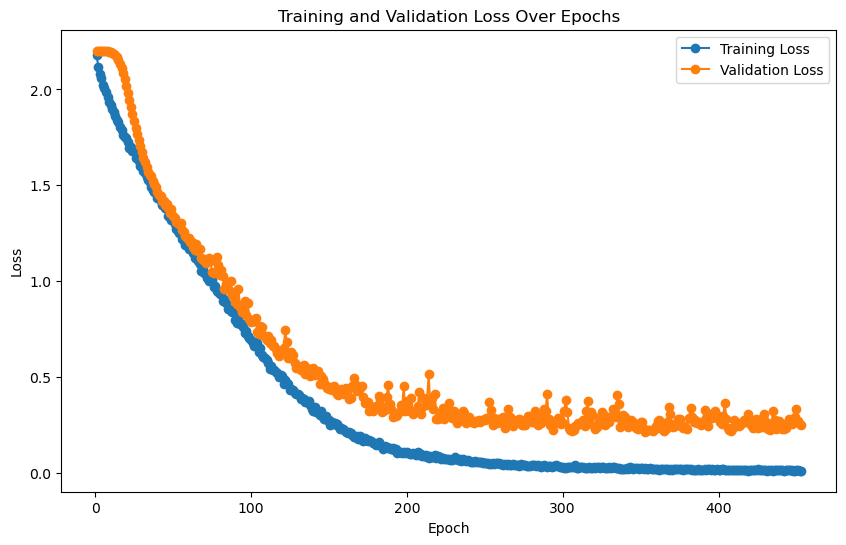

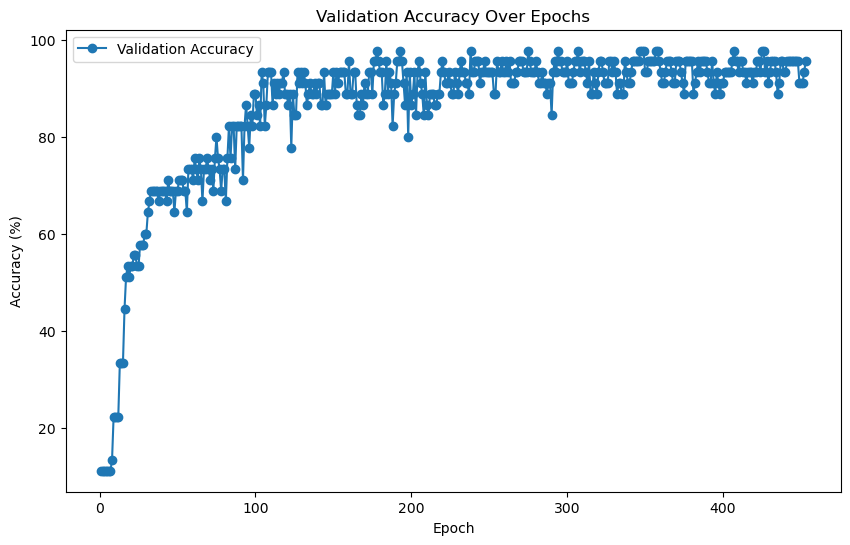


Evaluating on the test set...
    Test Batch [1/166], Loss: 1.2478



Final Test Loss: 0.6101, Test Accuracy: 85.60%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.


  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.


  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42371, 64), Test labels shape: (42371,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      0.60      0.67         5
           2       0.75      0.60      0.67         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.67      0.80      0.73         5
           6       0.71      1.00      0.83         5
           7       0.60      0.60      0.60         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42371, 64)
Test labels shape: (42371,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2863  |  Val Loss: 2.0259
Validation loss improved from inf to 2.0259.
[Epoch 2/1000] Train Loss: 1.9253  |  Val Loss: 1.7919
Validation loss improved from 2.0259 to 1.7919.
[Epoch 3/1000] Train Loss: 1.7154  |  Val Loss: 1.6254
Validation loss improved from 1.7919 to 1.6254.
[Epoch 4/1000] Train Loss: 1.5545  |  Val Loss: 1.4831
Validation loss improved from 1.6254 to 1.4831.
[Epoch 5/1000] Train Loss: 1.4178  |  Val Loss: 1.3667
Validation loss improved from 1.4831 to 1.3667.
[Epoch 6/1000] Train Loss: 1.2872  |  Val Loss: 1.2631
Validation loss improved from 1.3667 to 1.2631.
[Epoch 7/1000] Train Loss: 1.1778  |  Val Loss: 1.1802
Validation loss improved from 1.2631 to 1.1802.
[Epoch 8/1000] Train Loss: 1.0873  |  Val Loss: 1.1020
Validation loss improved from 1.1802 to 1.1020.
[Epoch 9/1000] Train Loss: 0.9989  |  Val Loss: 1.0230
Validation loss improved from 1.1020 to 1.0230.
[Epoch 10/1000] Train Loss: 0.9177  |  Val Loss: 0.9682
Validation loss impr

[Epoch 11/1000] Train Loss: 0.8418  |  Val Loss: 0.9066
Validation loss improved from 0.9682 to 0.9066.
[Epoch 12/1000] Train Loss: 0.7760  |  Val Loss: 0.8678
Validation loss improved from 0.9066 to 0.8678.
[Epoch 13/1000] Train Loss: 0.7234  |  Val Loss: 0.8219
Validation loss improved from 0.8678 to 0.8219.
[Epoch 14/1000] Train Loss: 0.6686  |  Val Loss: 0.7790
Validation loss improved from 0.8219 to 0.7790.
[Epoch 15/1000] Train Loss: 0.6371  |  Val Loss: 0.7581
Validation loss improved from 0.7790 to 0.7581.
[Epoch 16/1000] Train Loss: 0.6049  |  Val Loss: 0.7298
Validation loss improved from 0.7581 to 0.7298.
[Epoch 17/1000] Train Loss: 0.5575  |  Val Loss: 0.7243
Validation loss improved from 0.7298 to 0.7243.
[Epoch 18/1000] Train Loss: 0.5372  |  Val Loss: 0.6912
Validation loss improved from 0.7243 to 0.6912.
[Epoch 19/1000] Train Loss: 0.5163  |  Val Loss: 0.6804
Validation loss improved from 0.6912 to 0.6804.
[Epoch 20/1000] Train Loss: 0.4914  |  Val Loss: 0.6644
Validati

[Epoch 21/1000] Train Loss: 0.4754  |  Val Loss: 0.6637
Validation loss improved from 0.6644 to 0.6637.
[Epoch 22/1000] Train Loss: 0.4659  |  Val Loss: 0.6568
Validation loss improved from 0.6637 to 0.6568.
[Epoch 23/1000] Train Loss: 0.4520  |  Val Loss: 0.6521
Validation loss improved from 0.6568 to 0.6521.
[Epoch 24/1000] Train Loss: 0.4263  |  Val Loss: 0.6343
Validation loss improved from 0.6521 to 0.6343.
[Epoch 25/1000] Train Loss: 0.4162  |  Val Loss: 0.6263
Validation loss improved from 0.6343 to 0.6263.
[Epoch 26/1000] Train Loss: 0.4110  |  Val Loss: 0.6311
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.3955  |  Val Loss: 0.6239
Validation loss improved from 0.6263 to 0.6239.
[Epoch 28/1000] Train Loss: 0.3893  |  Val Loss: 0.6263
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 29/1000] Train Loss: 0.3852  |  Val Loss: 0.6204
Validation loss improved from 0.6239 to 0.6204.
[Epoch 30/1000] Train Loss: 0.3746  |  Val Loss: 0.6301
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 31/1000] Train Loss: 0.3651  |  Val Loss: 0.6038
Validation loss improved from 0.6204 to 0.6038.
[Epoch 32/1000] Train Loss: 0.3568  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 0.3462  |  Val Loss: 0.6033
Validation loss improved from 0.6038 to 0.6033.
[Epoch 34/1000] Train Loss: 0.3362  |  Val Loss: 0.6043
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 0.3391  |  Val Loss: 0.6004
Validation loss improved from 0.6033 to 0.6004.
[Epoch 36/1000] Train Loss: 0.3240  |  Val Loss: 0.5894
Validation loss improved from 0.6004 to 0.5894.


[Epoch 37/1000] Train Loss: 0.3279  |  Val Loss: 0.5802
Validation loss improved from 0.5894 to 0.5802.
[Epoch 38/1000] Train Loss: 0.3338  |  Val Loss: 0.6105
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.3359  |  Val Loss: 0.5957
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 0.3214  |  Val Loss: 0.5930
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 41/1000] Train Loss: 0.3114  |  Val Loss: 0.5797
Validation loss improved from 0.5802 to 0.5797.
[Epoch 42/1000] Train Loss: 0.3051  |  Val Loss: 0.5875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.3064  |  Val Loss: 0.5716
Validation loss improved from 0.5797 to 0.5716.
[Epoch 44/1000] Train Loss: 0.2896  |  Val Loss: 0.5954
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.2943  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 46/1000] Train Loss: 0.3047  |  Val Loss: 0.5654
Validation loss improved from 0.5716 to 0.5654.
[Epoch 47/1000] Train Loss: 0.2820  |  Val Loss: 0.5855
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 0.2738  |  Val Loss: 0.5733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/1000] Train Loss: 0.2785  |  Val Loss: 0.5637
Validation loss improved from 0.5654 to 0.5637.
[Epoch 50/1000] Train Loss: 0.2712  |  Val Loss: 0.5787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.2762  |  Val Loss: 0.5635
Validation loss improved from 0.5637 to 0.5635.
[Epoch 52/1000] Train Loss: 0.2679  |  Val Loss: 0.5669
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.2659  |  Val Loss: 0.5721
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 0.2580  |  Val Loss: 0.5783
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 55/1000] Train Loss: 0.2502  |  Val Loss: 0.5570
Validation loss improved from 0.5635 to 0.5570.
[Epoch 56/1000] Train Loss: 0.2504  |  Val Loss: 0.5788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.2446  |  Val Loss: 0.5698
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.2418  |  Val Loss: 0.5489
Validation loss improved from 0.5570 to 0.5489.
[Epoch 59/1000] Train Loss: 0.2424  |  Val Loss: 0.5733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.2350  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.2365  |  Val Loss: 0.5809
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.2311  |  Val Loss: 0.5614
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 63/1000] Train Loss: 0.2249  |  Val Loss: 0.5636
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 64/1000] Train Loss: 0.2273  |  Val Loss: 0.5759
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 65/1000] Train Loss: 0.2291  |  Val Loss: 0.5613
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 66/1000] Train Loss: 0.2233  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 67/1000] Train Loss: 0.2259  |  Val Loss: 0.5582
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 68/1000] Train Loss: 0.2154  |  Val Loss: 0.5567
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 69/1000] Train Loss: 0.2179  |  Val Loss: 0.5712
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 70/1000] Train Loss: 0.2176  |  Val Loss: 0.5759
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 71/1000] Train Loss: 0.2123  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 72/1000] Train Loss: 0.2107  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 73/1000] Train Loss: 0.2130  |  Val Loss: 0.5608
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 74/1000] Train Loss: 0.2071  |  Val Loss: 0.5479
Validation loss improved from 0.5489 to 0.5479.
[Epoch 75/1000] Train Loss: 0.2175  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 0.2106  |  Val Loss: 0.5362
Validation loss improved from 0.5479 to 0.5362.
[Epoch 77/1000] Train Loss: 0.1960  |  Val Loss: 0.5888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] T

[Epoch 80/1000] Train Loss: 0.1935  |  Val Loss: 0.5530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 81/1000] Train Loss: 0.1889  |  Val Loss: 0.5536
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 82/1000] Train Loss: 0.1850  |  Val Loss: 0.5559
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 83/1000] Train Loss: 0.1852  |  Val Loss: 0.6080
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 84/1000] Train Loss: 0.1980  |  Val Loss: 0.5521
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 85/1000] Train Loss: 0.1957  |  Val Loss: 0.5851
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 86/1000] Train Loss: 0.1796  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 87/1000] Train Loss: 0.1817  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 88/1000] Train Loss: 0.1812  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 89/1000] Train Loss: 0.1713  |  Val Loss: 0.5620
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 90/1000] Train Loss: 0.1713  |  Val Loss: 0.5744
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 91/1000] Train Loss: 0.1731  |  Val Loss: 0.5949
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 92/1000] Train Loss: 0.1761  |  Val Loss: 0.5614
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 93/1000] Train Loss: 0.1698  |  Val Loss: 0.5836
!! Validation loss did NOT improve !! Patience: 15/100
[Epo

[Epoch 97/1000] Train Loss: 0.1708  |  Val Loss: 0.5916
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 98/1000] Train Loss: 0.1592  |  Val Loss: 0.5915
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 99/1000] Train Loss: 0.1575  |  Val Loss: 0.5590
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 100/1000] Train Loss: 0.1521  |  Val Loss: 0.6265
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 101/1000] Train Loss: 0.1631  |  Val Loss: 0.5441
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 102/1000] Train Loss: 0.1640  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 103/1000] Train Loss: 0.1672  |  Val Loss: 0.6176
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 104/1000] Train Loss: 0.1541  |  Val Loss: 0.5582
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 105/1000] Train Loss: 0.1500  |  Val Loss: 0.5718
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 106/1000] Train Loss: 0.1496  |  Val Loss: 0.6116
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 107/1000] Train Loss: 0.1437  |  Val Loss: 0.5848
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 108/1000] Train Loss: 0.1431  |  Val Loss: 0.5754
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 109/1000] Train Loss: 0.1392  |  Val Loss: 0.5799
!! Validation loss did NOT improve !! Patience:

[Epoch 114/1000] Train Loss: 0.1333  |  Val Loss: 0.5853
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 115/1000] Train Loss: 0.1290  |  Val Loss: 0.6654
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 116/1000] Train Loss: 0.1512  |  Val Loss: 0.5821
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 117/1000] Train Loss: 0.1263  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 118/1000] Train Loss: 0.1236  |  Val Loss: 0.5998
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 119/1000] Train Loss: 0.1254  |  Val Loss: 0.6134
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 120/1000] Train Loss: 0.1361  |  Val Loss: 0.6299
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 121/1000] Train Loss: 0.1514  |  Val Loss: 0.5827
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 122/1000] Train Loss: 0.1311  |  Val Loss: 0.6152
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 123/1000] Train Loss: 0.1310  |  Val Loss: 0.6316
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 124/1000] Train Loss: 0.1185  |  Val Loss: 0.5910
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 125/1000] Train Loss: 0.1133  |  Val Loss: 0.6947
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 126/1000] Train Loss: 0.1251  |  Val Loss: 0.5682
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 0.1104  |  Val Loss: 0.5995
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 134/1000] Train Loss: 0.1042  |  Val Loss: 0.5840
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 135/1000] Train Loss: 0.1037  |  Val Loss: 0.6104
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 136/1000] Train Loss: 0.1086  |  Val Loss: 0.6821
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 137/1000] Train Loss: 0.1075  |  Val Loss: 0.6134
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 138/1000] Train Loss: 0.1093  |  Val Loss: 0.7200
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 139/1000] Train Loss: 0.1220  |  Val Loss: 0.6073
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 140/1000] Train Loss: 0.1165  |  Val Loss: 0.6567
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 141/1000] Train Loss: 0.0980  |  Val Loss: 0.5925
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 142/1000] Train Loss: 0.1098  |  Val Loss: 0.6075
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 150/1000] Train Loss: 0.1006  |  Val Loss: 0.6187
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 151/1000] Train Loss: 0.0984  |  Val Loss: 0.7382
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 152/1000] Train Loss: 0.0993  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 153/1000] Train Loss: 0.0916  |  Val Loss: 0.6717
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 154/1000] Train Loss: 0.0926  |  Val Loss: 0.6274
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 155/1000] Train Loss: 0.0918  |  Val Loss: 0.6309
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 156/1000] Train Loss: 0.0870  |  Val Loss: 0.7163
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 157/1000] Train Loss: 0.0881  |  Val Loss: 0.5939
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 158/1000] Train Loss: 0.0893  |  Val Loss: 0.8011
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.0812  |  Val Loss: 0.6704
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 169/1000] Train Loss: 0.0654  |  Val Loss: 0.6499
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 170/1000] Train Loss: 0.0744  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 171/1000] Train Loss: 0.0831  |  Val Loss: 0.6854
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 172/1000] Train Loss: 0.0768  |  Val Loss: 0.6925
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 173/1000] Train Loss: 0.0696  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 174/1000] Train Loss: 0.0715  |  Val Loss: 0.8084
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 175/1000] Train Loss: 0.0706  |  Val Loss: 0.5974
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 176/1000] Train Loss: 0.0676  |  Val Loss: 0.7039
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.0571  |  Val Loss: 0.7529
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 186/1000] Train Loss: 0.0598  |  Val Loss: 0.6557
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 187/1000] Train Loss: 0.0588  |  Val Loss: 0.8538
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 188/1000] Train Loss: 0.0680  |  Val Loss: 0.6991
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 189/1000] Train Loss: 0.0570  |  Val Loss: 0.6850
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 190/1000] Train Loss: 0.0522  |  Val Loss: 0.7322
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 191/1000] Train Loss: 0.0565  |  Val Loss: 0.6906
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 192/1000] Train Loss: 0.0569  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 193/1000] Train Loss: 0.0524  |  Val Loss: 0.7212
!! Validation loss did NOT improve !! Patience:

[Epoch 204/1000] Train Loss: 0.0529  |  Val Loss: 0.7215
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 205/1000] Train Loss: 0.0470  |  Val Loss: 0.8648
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 206/1000] Train Loss: 0.0526  |  Val Loss: 0.6640
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 207/1000] Train Loss: 0.0457  |  Val Loss: 0.8605
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 208/1000] Train Loss: 0.0523  |  Val Loss: 0.6578
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 209/1000] Train Loss: 0.0758  |  Val Loss: 0.9404
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 210/1000] Train Loss: 0.0810  |  Val Loss: 0.7560
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 211/1000] Train Loss: 0.0813  |  Val Loss: 0.6580
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 212/1000] Train Loss: 0.0909  |  Val Loss: 1.1441
!! Validation loss did NOT improve !! Patience:

[Epoch 219/1000] Train Loss: 0.0426  |  Val Loss: 0.7718
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 220/1000] Train Loss: 0.0440  |  Val Loss: 0.8014
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 221/1000] Train Loss: 0.0418  |  Val Loss: 0.7476
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 222/1000] Train Loss: 0.0391  |  Val Loss: 0.8880
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 223/1000] Train Loss: 0.0392  |  Val Loss: 0.7862
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 224/1000] Train Loss: 0.0365  |  Val Loss: 0.7741
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 225/1000] Train Loss: 0.0361  |  Val Loss: 0.8042
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 226/1000] Train Loss: 0.0365  |  Val Loss: 0.8286
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 227/1000] Train Loss: 0.0352  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience:

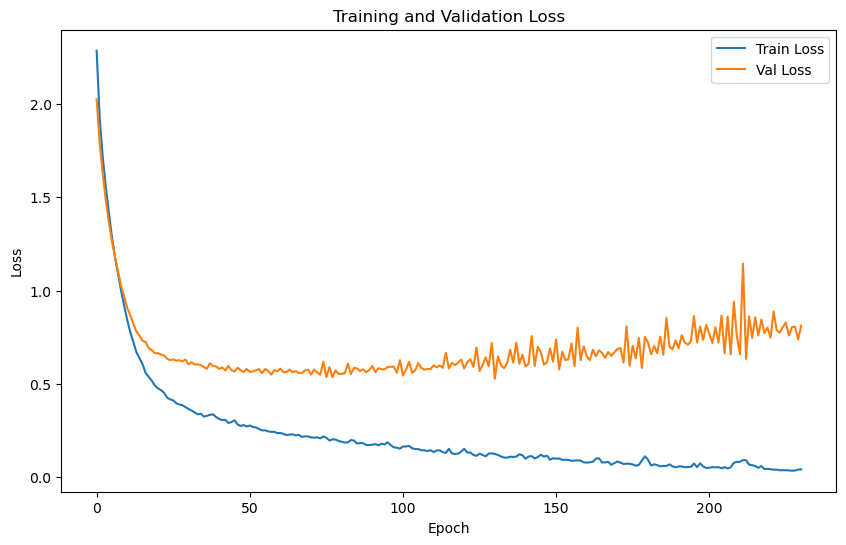

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.4066 | Test Accuracy: 69.92%


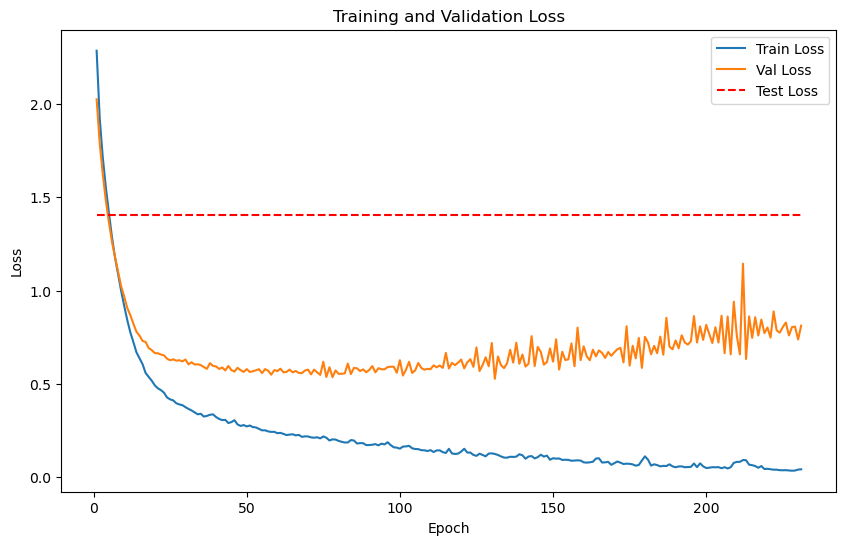

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.7652
    Batch [2/2], Train Loss: 8.6721
Epoch [1/2000], Avg Train Loss: 8.7186
Epoch [1/2000], Avg Val Loss: 4.5509
Validation loss improved from inf to 4.5509. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.4113
    Batch [2/2], Train Loss: 8.4665
Epoch [2/2000], Avg Train Loss: 8.4389
Epoch [2/2000], Avg Val Loss: 4.4633
Validation loss improved from 4.5509 to 4.4633. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.3082
    Batch [2/2], Train Loss: 8.2767
Epoch [3/2000], Avg Train Loss: 8.2925
Epoch [3/2000], Avg Val Loss: 4.3793
Validation loss improved from 4.4633 to 4.3793. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.3172
    Batch [2/2], Train Loss: 7.9977
Epoch [4/2000], Avg Train Loss: 8.1575
Epoch [4/2000], Avg Val Loss: 4.2987
Validation loss improved from 4.3793 to 4.2987. Saving model...

LOG: Epoch [5/2000] - Trai

    Batch [1/2], Train Loss: 8.1370
    Batch [2/2], Train Loss: 7.9296
Epoch [5/2000], Avg Train Loss: 8.0333
Epoch [5/2000], Avg Val Loss: 4.2213
Validation loss improved from 4.2987 to 4.2213. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.9018
    Batch [2/2], Train Loss: 7.7841
Epoch [6/2000], Avg Train Loss: 7.8430
Epoch [6/2000], Avg Val Loss: 4.1464
Validation loss improved from 4.2213 to 4.1464. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 8.0015
    Batch [2/2], Train Loss: 7.6558
Epoch [7/2000], Avg Train Loss: 7.8286
Epoch [7/2000], Avg Val Loss: 4.0753
Validation loss improved from 4.1464 to 4.0753. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 7.6938
    Batch [2/2], Train Loss: 7.7299
Epoch [8/2000], Avg Train Loss: 7.7118
Epoch [8/2000], Avg Val Loss: 4.0073
Validation loss improved from 4.0753 to 4.0073. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 7.0970
    Batch [2/2], Train Loss: 7.0946
Epoch [12/2000], Avg Train Loss: 7.0958
Epoch [12/2000], Avg Val Loss: 3.7664
Validation loss improved from 3.8224 to 3.7664. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.9030
    Batch [2/2], Train Loss: 7.0181
Epoch [13/2000], Avg Train Loss: 6.9606
Epoch [13/2000], Avg Val Loss: 3.7131
Validation loss improved from 3.7664 to 3.7131. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.9823
    Batch [2/2], Train Loss: 6.5869
Epoch [14/2000], Avg Train Loss: 6.7846
Epoch [14/2000], Avg Val Loss: 3.6632
Validation loss improved from 3.7131 to 3.6632. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.7271
    Batch [2/2], Train Loss: 6.8173
Epoch [15/2000], Avg Train Loss: 6.7722
Epoch [15/2000], Avg Val Loss: 3.6159
Validation loss improved from 3.6632 to 3.6159. Saving model...

LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 6.8264
    Batch [2/2], Train Loss: 6.7179
Epoch [16/2000], Avg Train Loss: 6.7721
Epoch [16/2000], Avg Val Loss: 3.5708
Validation loss improved from 3.6159 to 3.5708. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.7822
    Batch [2/2], Train Loss: 6.6460
Epoch [17/2000], Avg Train Loss: 6.7141
Epoch [17/2000], Avg Val Loss: 3.5277
Validation loss improved from 3.5708 to 3.5277. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.5811
    Batch [2/2], Train Loss: 6.4970
Epoch [18/2000], Avg Train Loss: 6.5390
Epoch [18/2000], Avg Val Loss: 3.4871
Validation loss improved from 3.5277 to 3.4871. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 6.4696
    Batch [2/2], Train Loss: 6.4169
Epoch [19/2000], Avg Train Loss: 6.4432
Epoch [19/2000], Avg Val Loss: 3.4489
Validation loss improved from 3.4871 to 3.4489. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.5948
    Batch [2/2], Train Loss: 5.6030
Epoch [33/2000], Avg Train Loss: 5.5989
Epoch [33/2000], Avg Val Loss: 3.1003
Validation loss improved from 3.1163 to 3.1003. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3699
    Batch [2/2], Train Loss: 5.3020
Epoch [34/2000], Avg Train Loss: 5.3359
Epoch [34/2000], Avg Val Loss: 3.0855
Validation loss improved from 3.1003 to 3.0855. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4375
    Batch [2/2], Train Loss: 5.4909
Epoch [35/2000], Avg Train Loss: 5.4642
Epoch [35/2000], Avg Val Loss: 3.0713
Validation loss improved from 3.0855 to 3.0713. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.3991
    Batch [2/2], Train Loss: 5.3880
Epoch [36/2000], Avg Train Loss: 5.3936
Epoch [36/2000], Avg Val Loss: 3.0578
Validation loss improved from 3.0713 to 3.0578. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.4633
    Batch [2/2], Train Loss: 5.2795
Epoch [38/2000], Avg Train Loss: 5.3714
Epoch [38/2000], Avg Val Loss: 3.0331
Validation loss improved from 3.0451 to 3.0331. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.3194
    Batch [2/2], Train Loss: 5.2886
Epoch [39/2000], Avg Train Loss: 5.3040
Epoch [39/2000], Avg Val Loss: 3.0221
Validation loss improved from 3.0331 to 3.0221. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.2842
    Batch [2/2], Train Loss: 5.2171
Epoch [40/2000], Avg Train Loss: 5.2507
Epoch [40/2000], Avg Val Loss: 3.0117
Validation loss improved from 3.0221 to 3.0117. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.2217
    Batch [2/2], Train Loss: 5.1330
Epoch [41/2000], Avg Train Loss: 5.1774
Epoch [41/2000], Avg Val Loss: 3.0019
Validation loss improved from 3.0117 to 3.0019. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7767
Epoch [57/2000], Avg Train Loss: 4.7977
Epoch [57/2000], Avg Val Loss: 2.8965
Validation loss improved from 2.9015 to 2.8965. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 4.9300
    Batch [2/2], Train Loss: 4.7832
Epoch [58/2000], Avg Train Loss: 4.8566
Epoch [58/2000], Avg Val Loss: 2.8918
Validation loss improved from 2.8965 to 2.8918. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 4.8372
    Batch [2/2], Train Loss: 4.7859
Epoch [59/2000], Avg Train Loss: 4.8116
Epoch [59/2000], Avg Val Loss: 2.8874
Validation loss improved from 2.8918 to 2.8874. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 4.8033
    Batch [2/2], Train Loss: 4.7848
Epoch [60/2000], Avg Train Loss: 4.7941
Epoch [60/2000], Avg Val Loss: 2.8831
Validation loss improved from 2.8874 to 2.8831. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.7748
    Batch [2

    Batch [1/2], Train Loss: 4.6921
    Batch [2/2], Train Loss: 4.7356
Epoch [63/2000], Avg Train Loss: 4.7139
Epoch [63/2000], Avg Val Loss: 2.8710
Validation loss improved from 2.8749 to 2.8710. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.6933
    Batch [2/2], Train Loss: 4.8530
Epoch [64/2000], Avg Train Loss: 4.7732
Epoch [64/2000], Avg Val Loss: 2.8673
Validation loss improved from 2.8710 to 2.8673. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.7720
    Batch [2/2], Train Loss: 4.7138
Epoch [65/2000], Avg Train Loss: 4.7429
Epoch [65/2000], Avg Val Loss: 2.8637
Validation loss improved from 2.8673 to 2.8637. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.7003
    Batch [2/2], Train Loss: 4.7375
Epoch [66/2000], Avg Train Loss: 4.7189
Epoch [66/2000], Avg Val Loss: 2.8602
Validation loss improved from 2.8637 to 2.8602. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.6372
    Batch [2/2], Train Loss: 4.5867
Epoch [82/2000], Avg Train Loss: 4.6120
Epoch [82/2000], Avg Val Loss: 2.8053
Validation loss improved from 2.8086 to 2.8053. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.5311
    Batch [2/2], Train Loss: 4.5345
Epoch [83/2000], Avg Train Loss: 4.5328
Epoch [83/2000], Avg Val Loss: 2.8021
Validation loss improved from 2.8053 to 2.8021. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.5421
    Batch [2/2], Train Loss: 4.5656
Epoch [84/2000], Avg Train Loss: 4.5538
Epoch [84/2000], Avg Val Loss: 2.7989
Validation loss improved from 2.8021 to 2.7989. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 4.5407
    Batch [2/2], Train Loss: 4.5459
Epoch [85/2000], Avg Train Loss: 4.5433
Epoch [85/2000], Avg Val Loss: 2.7956
Validation loss improved from 2.7989 to 2.7956. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.4867
    Batch [2/2], Train Loss: 4.5136
Epoch [90/2000], Avg Train Loss: 4.5002
Epoch [90/2000], Avg Val Loss: 2.7797
Validation loss improved from 2.7828 to 2.7797. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.5827
    Batch [2/2], Train Loss: 4.5278
Epoch [91/2000], Avg Train Loss: 4.5553
Epoch [91/2000], Avg Val Loss: 2.7767
Validation loss improved from 2.7797 to 2.7767. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 4.5270
    Batch [2/2], Train Loss: 4.4734
Epoch [92/2000], Avg Train Loss: 4.5002
Epoch [92/2000], Avg Val Loss: 2.7737
Validation loss improved from 2.7767 to 2.7737. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.5131
    Batch [2/2], Train Loss: 4.5829
Epoch [93/2000], Avg Train Loss: 4.5480
Epoch [93/2000], Avg Val Loss: 2.7709
Validation loss improved from 2.7737 to 2.7709. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.3921
Epoch [107/2000], Avg Train Loss: 4.4063
Epoch [107/2000], Avg Val Loss: 2.7348
Validation loss improved from 2.7370 to 2.7348. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.4077
    Batch [2/2], Train Loss: 4.4883
Epoch [108/2000], Avg Train Loss: 4.4480
Epoch [108/2000], Avg Val Loss: 2.7326
Validation loss improved from 2.7348 to 2.7326. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.4311
    Batch [2/2], Train Loss: 4.4260
Epoch [109/2000], Avg Train Loss: 4.4285
Epoch [109/2000], Avg Val Loss: 2.7304
Validation loss improved from 2.7326 to 2.7304. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.4375
    Batch [2/2], Train Loss: 4.4347
Epoch [110/2000], Avg Train Loss: 4.4361
Epoch [110/2000], Avg Val Loss: 2.7281
Validation loss improved from 2.7304 to 2.7281. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 4.3930


    Batch [1/2], Train Loss: 4.3498
    Batch [2/2], Train Loss: 4.4437
Epoch [115/2000], Avg Train Loss: 4.3968
Epoch [115/2000], Avg Val Loss: 2.7173
Validation loss improved from 2.7195 to 2.7173. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.3997
    Batch [2/2], Train Loss: 4.4171
Epoch [116/2000], Avg Train Loss: 4.4084
Epoch [116/2000], Avg Val Loss: 2.7150
Validation loss improved from 2.7173 to 2.7150. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 4.4164
    Batch [2/2], Train Loss: 4.3611
Epoch [117/2000], Avg Train Loss: 4.3887
Epoch [117/2000], Avg Val Loss: 2.7127
Validation loss improved from 2.7150 to 2.7127. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.4271
    Batch [2/2], Train Loss: 4.3670
Epoch [118/2000], Avg Train Loss: 4.3971
Epoch [118/2000], Avg Val Loss: 2.7105
Validation loss improved from 2.7127 to 2.7105. Saving model...

LOG: Epoch [119/2000] - Training


Epoch [133/2000], Avg Val Loss: 2.6815
Validation loss improved from 2.6832 to 2.6815. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.2647
    Batch [2/2], Train Loss: 4.2970
Epoch [134/2000], Avg Train Loss: 4.2808
Epoch [134/2000], Avg Val Loss: 2.6798
Validation loss improved from 2.6815 to 2.6798. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.3109
    Batch [2/2], Train Loss: 4.3143
Epoch [135/2000], Avg Train Loss: 4.3126
Epoch [135/2000], Avg Val Loss: 2.6781
Validation loss improved from 2.6798 to 2.6781. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.2565
    Batch [2/2], Train Loss: 4.3372
Epoch [136/2000], Avg Train Loss: 4.2968
Epoch [136/2000], Avg Val Loss: 2.6764
Validation loss improved from 2.6781 to 2.6764. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.2634
    Batch [2/2], Train Loss: 4.2836
Epoch [137/2000], Avg Train Loss: 4.2735


    Batch [2/2], Train Loss: 4.2861
Epoch [142/2000], Avg Train Loss: 4.2875
Epoch [142/2000], Avg Val Loss: 2.6673
Validation loss improved from 2.6686 to 2.6673. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.2768
    Batch [2/2], Train Loss: 4.2575
Epoch [143/2000], Avg Train Loss: 4.2672
Epoch [143/2000], Avg Val Loss: 2.6658
Validation loss improved from 2.6673 to 2.6658. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.3090
    Batch [2/2], Train Loss: 4.2890
Epoch [144/2000], Avg Train Loss: 4.2990
Epoch [144/2000], Avg Val Loss: 2.6644
Validation loss improved from 2.6658 to 2.6644. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.2215
    Batch [2/2], Train Loss: 4.3206
Epoch [145/2000], Avg Train Loss: 4.2710
Epoch [145/2000], Avg Val Loss: 2.6630
Validation loss improved from 2.6644 to 2.6630. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 4.2271


Epoch [156/2000], Avg Val Loss: 2.6502
Validation loss improved from 2.6512 to 2.6502. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.2272
    Batch [2/2], Train Loss: 4.2342
Epoch [157/2000], Avg Train Loss: 4.2307
Epoch [157/2000], Avg Val Loss: 2.6491
Validation loss improved from 2.6502 to 2.6491. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.2173
    Batch [2/2], Train Loss: 4.2103
Epoch [158/2000], Avg Train Loss: 4.2138
Epoch [158/2000], Avg Val Loss: 2.6481
Validation loss improved from 2.6491 to 2.6481. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.2162
    Batch [2/2], Train Loss: 4.1791
Epoch [159/2000], Avg Train Loss: 4.1976
Epoch [159/2000], Avg Val Loss: 2.6472
Validation loss improved from 2.6481 to 2.6472. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.1719
    Batch [2/2], Train Loss: 4.1534
Epoch [160/2000], Avg Train Loss: 4.1627


Epoch [164/2000], Avg Val Loss: 2.6424
Validation loss improved from 2.6435 to 2.6424. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.2322
    Batch [2/2], Train Loss: 4.1416
Epoch [165/2000], Avg Train Loss: 4.1869
Epoch [165/2000], Avg Val Loss: 2.6414
Validation loss improved from 2.6424 to 2.6414. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.1949
    Batch [2/2], Train Loss: 4.2388
Epoch [166/2000], Avg Train Loss: 4.2168
Epoch [166/2000], Avg Val Loss: 2.6403
Validation loss improved from 2.6414 to 2.6403. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.2387
    Batch [2/2], Train Loss: 4.1972
Epoch [167/2000], Avg Train Loss: 4.2179
Epoch [167/2000], Avg Val Loss: 2.6394
Validation loss improved from 2.6403 to 2.6394. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.2024
    Batch [2/2], Train Loss: 4.1894
Epoch [168/2000], Avg Train Loss: 4.1959


    Batch [2/2], Train Loss: 4.1340
Epoch [179/2000], Avg Train Loss: 4.1630
Epoch [179/2000], Avg Val Loss: 2.6271
Validation loss improved from 2.6279 to 2.6271. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 4.1273
    Batch [2/2], Train Loss: 4.1535
Epoch [180/2000], Avg Train Loss: 4.1404
Epoch [180/2000], Avg Val Loss: 2.6263
Validation loss improved from 2.6271 to 2.6263. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.1258
    Batch [2/2], Train Loss: 4.1597
Epoch [181/2000], Avg Train Loss: 4.1428
Epoch [181/2000], Avg Val Loss: 2.6256
Validation loss improved from 2.6263 to 2.6256. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.1587
    Batch [2/2], Train Loss: 4.1323
Epoch [182/2000], Avg Train Loss: 4.1455
Epoch [182/2000], Avg Val Loss: 2.6249
Validation loss improved from 2.6256 to 2.6249. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 4.2132


    Batch [2/2], Train Loss: 4.1527
Epoch [191/2000], Avg Train Loss: 4.1410
Epoch [191/2000], Avg Val Loss: 2.6177
Validation loss improved from 2.6184 to 2.6177. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.1695
    Batch [2/2], Train Loss: 4.1899
Epoch [192/2000], Avg Train Loss: 4.1797
Epoch [192/2000], Avg Val Loss: 2.6168
Validation loss improved from 2.6177 to 2.6168. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.1546
    Batch [2/2], Train Loss: 4.1340
Epoch [193/2000], Avg Train Loss: 4.1443
Epoch [193/2000], Avg Val Loss: 2.6160
Validation loss improved from 2.6168 to 2.6160. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.1463
    Batch [2/2], Train Loss: 4.1697
Epoch [194/2000], Avg Train Loss: 4.1580
Epoch [194/2000], Avg Val Loss: 2.6151
Validation loss improved from 2.6160 to 2.6151. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 4.1244


    Batch [2/2], Train Loss: 4.0800
Epoch [207/2000], Avg Train Loss: 4.0856
Epoch [207/2000], Avg Val Loss: 2.6078
Validation loss improved from 2.6083 to 2.6078. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.0748
    Batch [2/2], Train Loss: 4.0646
Epoch [208/2000], Avg Train Loss: 4.0697
Epoch [208/2000], Avg Val Loss: 2.6074
Validation loss improved from 2.6078 to 2.6074. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.0848
    Batch [2/2], Train Loss: 4.0981
Epoch [209/2000], Avg Train Loss: 4.0914
Epoch [209/2000], Avg Val Loss: 2.6071
Validation loss improved from 2.6074 to 2.6071. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.0695
    Batch [2/2], Train Loss: 4.1143
Epoch [210/2000], Avg Train Loss: 4.0919
Epoch [210/2000], Avg Val Loss: 2.6066
Validation loss improved from 2.6071 to 2.6066. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 4.0899


    Batch [1/2], Train Loss: 4.0661
    Batch [2/2], Train Loss: 4.0562
Epoch [218/2000], Avg Train Loss: 4.0612
Epoch [218/2000], Avg Val Loss: 2.6033
Validation loss improved from 2.6036 to 2.6033. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.1134
    Batch [2/2], Train Loss: 4.0963
Epoch [219/2000], Avg Train Loss: 4.1049
Epoch [219/2000], Avg Val Loss: 2.6031
Validation loss improved from 2.6033 to 2.6031. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.0633
    Batch [2/2], Train Loss: 4.0769
Epoch [220/2000], Avg Train Loss: 4.0701
Epoch [220/2000], Avg Val Loss: 2.6027
Validation loss improved from 2.6031 to 2.6027. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 4.0959
    Batch [2/2], Train Loss: 4.0809
Epoch [221/2000], Avg Train Loss: 4.0884
Epoch [221/2000], Avg Val Loss: 2.6024
Validation loss improved from 2.6027 to 2.6024. Saving model...

LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 4.0645
    Batch [2/2], Train Loss: 4.0804
Epoch [233/2000], Avg Train Loss: 4.0725
Epoch [233/2000], Avg Val Loss: 2.5968
Validation loss improved from 2.5971 to 2.5968. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 4.0608
    Batch [2/2], Train Loss: 4.0297
Epoch [234/2000], Avg Train Loss: 4.0452
Epoch [234/2000], Avg Val Loss: 2.5965
Validation loss improved from 2.5968 to 2.5965. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 4.0454
    Batch [2/2], Train Loss: 4.0009
Epoch [235/2000], Avg Train Loss: 4.0232
Epoch [235/2000], Avg Val Loss: 2.5963
Validation loss improved from 2.5965 to 2.5963. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 4.0404
    Batch [2/2], Train Loss: 4.0478
Epoch [236/2000], Avg Train Loss: 4.0441
Epoch [236/2000], Avg Val Loss: 2.5961
Validation loss improved from 2.5963 to 2.5961. Saving model...

LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 4.0058
    Batch [2/2], Train Loss: 3.9515
Epoch [243/2000], Avg Train Loss: 3.9787
Epoch [243/2000], Avg Val Loss: 2.5953
Validation loss improved from 2.5955 to 2.5953. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.0459
    Batch [2/2], Train Loss: 4.0256
Epoch [244/2000], Avg Train Loss: 4.0357
Epoch [244/2000], Avg Val Loss: 2.5950
Validation loss improved from 2.5953 to 2.5950. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.0171
    Batch [2/2], Train Loss: 3.9777
Epoch [245/2000], Avg Train Loss: 3.9974
Epoch [245/2000], Avg Val Loss: 2.5947
Validation loss improved from 2.5950 to 2.5947. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.0416
    Batch [2/2], Train Loss: 4.0011
Epoch [246/2000], Avg Train Loss: 4.0214
Epoch [246/2000], Avg Val Loss: 2.5944
Validation loss improved from 2.5947 to 2.5944. Saving model...

LOG: Epoch [247/2000] - Training


Epoch [258/2000], Avg Val Loss: 2.5914
Validation loss improved from 2.5918 to 2.5914. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 3.9770
    Batch [2/2], Train Loss: 3.9942
Epoch [259/2000], Avg Train Loss: 3.9856
Epoch [259/2000], Avg Val Loss: 2.5912
Validation loss improved from 2.5914 to 2.5912. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 3.9749
    Batch [2/2], Train Loss: 3.9784
Epoch [260/2000], Avg Train Loss: 3.9766
Epoch [260/2000], Avg Val Loss: 2.5909
Validation loss improved from 2.5912 to 2.5909. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 4.0226
    Batch [2/2], Train Loss: 4.0356
Epoch [261/2000], Avg Train Loss: 4.0291
Epoch [261/2000], Avg Val Loss: 2.5907
Validation loss improved from 2.5909 to 2.5907. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 4.0410
    Batch [2/2], Train Loss: 4.0100
Epoch [262/2000], Avg Train Loss: 4.0255


    Batch [2/2], Train Loss: 3.9599
Epoch [269/2000], Avg Train Loss: 3.9830
Epoch [269/2000], Avg Val Loss: 2.5893
Validation loss improved from 2.5894 to 2.5893. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 3.9829
    Batch [2/2], Train Loss: 4.0151
Epoch [270/2000], Avg Train Loss: 3.9990
Epoch [270/2000], Avg Val Loss: 2.5892
Validation loss improved from 2.5893 to 2.5892. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 3.9571
    Batch [2/2], Train Loss: 3.9851
Epoch [271/2000], Avg Train Loss: 3.9711
Epoch [271/2000], Avg Val Loss: 2.5890
Validation loss improved from 2.5892 to 2.5890. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 3.9743
    Batch [2/2], Train Loss: 3.9373
Epoch [272/2000], Avg Train Loss: 3.9558
Epoch [272/2000], Avg Val Loss: 2.5889
Validation loss improved from 2.5890 to 2.5889. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 3.9457


Epoch [282/2000], Avg Val Loss: 2.5893
Validation loss did not improve. Patience: 4/100

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 3.9511
    Batch [2/2], Train Loss: 3.9338
Epoch [283/2000], Avg Train Loss: 3.9424
Epoch [283/2000], Avg Val Loss: 2.5894
Validation loss did not improve. Patience: 5/100

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 3.9540
    Batch [2/2], Train Loss: 3.9163
Epoch [284/2000], Avg Train Loss: 3.9351
Epoch [284/2000], Avg Val Loss: 2.5895
Validation loss did not improve. Patience: 6/100

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 3.9233
    Batch [2/2], Train Loss: 3.9863
Epoch [285/2000], Avg Train Loss: 3.9548
Epoch [285/2000], Avg Val Loss: 2.5896
Validation loss did not improve. Patience: 7/100

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 3.9478
    Batch [2/2], Train Loss: 3.9901
Epoch [286/2000], Avg Train Loss: 3.9690
Epoch [286/2000], Avg Val Loss: 2.5896
Validation loss did n

    Batch [2/2], Train Loss: 3.9472
Epoch [294/2000], Avg Train Loss: 3.9645
Epoch [294/2000], Avg Val Loss: 2.5908
Validation loss did not improve. Patience: 16/100

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 3.9846
    Batch [2/2], Train Loss: 3.9668
Epoch [295/2000], Avg Train Loss: 3.9757
Epoch [295/2000], Avg Val Loss: 2.5910
Validation loss did not improve. Patience: 17/100

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 3.9473
    Batch [2/2], Train Loss: 3.9841
Epoch [296/2000], Avg Train Loss: 3.9657
Epoch [296/2000], Avg Val Loss: 2.5912
Validation loss did not improve. Patience: 18/100

LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 3.9511
    Batch [2/2], Train Loss: 3.9615
Epoch [297/2000], Avg Train Loss: 3.9563
Epoch [297/2000], Avg Val Loss: 2.5914
Validation loss did not improve. Patience: 19/100

LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 3.8740
    Batch [2/2], Train Loss: 3.9361
Epoch [298/2000], Av

    Batch [2/2], Train Loss: 3.8997
Epoch [310/2000], Avg Train Loss: 3.8805
Epoch [310/2000], Avg Val Loss: 2.5937
Validation loss did not improve. Patience: 32/100

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.8713
    Batch [2/2], Train Loss: 3.9423
Epoch [311/2000], Avg Train Loss: 3.9068
Epoch [311/2000], Avg Val Loss: 2.5939
Validation loss did not improve. Patience: 33/100

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 3.9090
    Batch [2/2], Train Loss: 3.8936
Epoch [312/2000], Avg Train Loss: 3.9013
Epoch [312/2000], Avg Val Loss: 2.5939
Validation loss did not improve. Patience: 34/100

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.8969
    Batch [2/2], Train Loss: 3.8691
Epoch [313/2000], Avg Train Loss: 3.8830
Epoch [313/2000], Avg Val Loss: 2.5939
Validation loss did not improve. Patience: 35/100

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 3.9159
    Batch [2/2], Train Loss: 3.9153
Epoch [314/2000], Av

    Batch [1/2], Train Loss: 3.8952
    Batch [2/2], Train Loss: 3.9433
Epoch [320/2000], Avg Train Loss: 3.9193
Epoch [320/2000], Avg Val Loss: 2.5949
Validation loss did not improve. Patience: 42/100

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 3.9881
    Batch [2/2], Train Loss: 3.9014
Epoch [321/2000], Avg Train Loss: 3.9448
Epoch [321/2000], Avg Val Loss: 2.5952
Validation loss did not improve. Patience: 43/100

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 3.9010
    Batch [2/2], Train Loss: 3.9372
Epoch [322/2000], Avg Train Loss: 3.9191
Epoch [322/2000], Avg Val Loss: 2.5954
Validation loss did not improve. Patience: 44/100

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 3.8992
    Batch [2/2], Train Loss: 3.9024
Epoch [323/2000], Avg Train Loss: 3.9008
Epoch [323/2000], Avg Val Loss: 2.5957
Validation loss did not improve. Patience: 45/100

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 3.9110
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.8796
Epoch [332/2000], Avg Train Loss: 3.8991
Epoch [332/2000], Avg Val Loss: 2.5996
Validation loss did not improve. Patience: 54/100

LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 3.8908
    Batch [2/2], Train Loss: 3.9066
Epoch [333/2000], Avg Train Loss: 3.8987
Epoch [333/2000], Avg Val Loss: 2.5999
Validation loss did not improve. Patience: 55/100

LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 3.9128
    Batch [2/2], Train Loss: 3.9322
Epoch [334/2000], Avg Train Loss: 3.9225
Epoch [334/2000], Avg Val Loss: 2.6001
Validation loss did not improve. Patience: 56/100

LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 3.9402
    Batch [2/2], Train Loss: 3.9192
Epoch [335/2000], Avg Train Loss: 3.9297
Epoch [335/2000], Avg Val Loss: 2.6003
Validation loss did not improve. Patience: 57/100

LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 3.8860
    Batch [2/2], Train Loss: 3.8676
Epoch [336/2000], Av

    Batch [2/2], Train Loss: 3.9008
Epoch [343/2000], Avg Train Loss: 3.8970
Epoch [343/2000], Avg Val Loss: 2.6002
Validation loss did not improve. Patience: 65/100

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.9237
    Batch [2/2], Train Loss: 3.8924
Epoch [344/2000], Avg Train Loss: 3.9081
Epoch [344/2000], Avg Val Loss: 2.6002
Validation loss did not improve. Patience: 66/100

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.8825
    Batch [2/2], Train Loss: 3.8825
Epoch [345/2000], Avg Train Loss: 3.8825
Epoch [345/2000], Avg Val Loss: 2.6000
Validation loss did not improve. Patience: 67/100

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 3.8605
    Batch [2/2], Train Loss: 3.8972
Epoch [346/2000], Avg Train Loss: 3.8789
Epoch [346/2000], Avg Val Loss: 2.5999
Validation loss did not improve. Patience: 68/100

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.8497
    Batch [2/2], Train Loss: 3.9200
Epoch [347/2000], Av

    Batch [1/2], Train Loss: 3.8646
    Batch [2/2], Train Loss: 3.8664
Epoch [355/2000], Avg Train Loss: 3.8655
Epoch [355/2000], Avg Val Loss: 2.5995
Validation loss did not improve. Patience: 77/100

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 3.8310
    Batch [2/2], Train Loss: 3.8515
Epoch [356/2000], Avg Train Loss: 3.8412
Epoch [356/2000], Avg Val Loss: 2.5996
Validation loss did not improve. Patience: 78/100

LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 3.8994
    Batch [2/2], Train Loss: 3.8703
Epoch [357/2000], Avg Train Loss: 3.8848
Epoch [357/2000], Avg Val Loss: 2.5995
Validation loss did not improve. Patience: 79/100

LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 3.8744
    Batch [2/2], Train Loss: 3.8665
Epoch [358/2000], Avg Train Loss: 3.8704
Epoch [358/2000], Avg Val Loss: 2.5996
Validation loss did not improve. Patience: 80/100

LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 3.9045
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.8256
Epoch [367/2000], Avg Train Loss: 3.8232
Epoch [367/2000], Avg Val Loss: 2.5983
Validation loss did not improve. Patience: 89/100

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.9034
    Batch [2/2], Train Loss: 3.8749
Epoch [368/2000], Avg Train Loss: 3.8891
Epoch [368/2000], Avg Val Loss: 2.5982
Validation loss did not improve. Patience: 90/100

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.8330
    Batch [2/2], Train Loss: 3.8881
Epoch [369/2000], Avg Train Loss: 3.8605
Epoch [369/2000], Avg Val Loss: 2.5982
Validation loss did not improve. Patience: 91/100

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.9300
    Batch [2/2], Train Loss: 3.8631
Epoch [370/2000], Avg Train Loss: 3.8966
Epoch [370/2000], Avg Val Loss: 2.5981
Validation loss did not improve. Patience: 92/100

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.8975
    Batch [2/2], Train Loss: 3.8447
Epoch [371/2000], Av

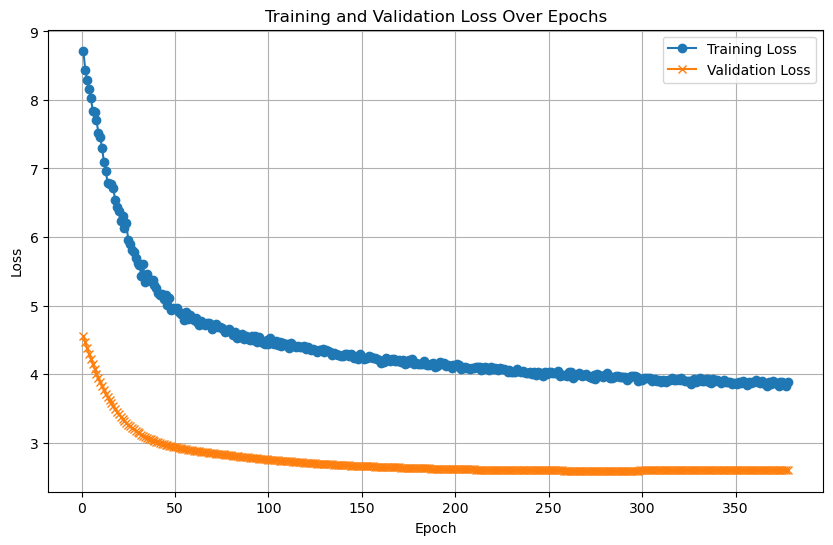

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/166], Loss: 5.6548
Test Batch [20/166], Loss: 5.4290
Test Batch [30/166], Loss: 5.3853
Test Batch [40/166], Loss: 5.6558
Test Batch [50/166], Loss: 5.2366
Test Batch [60/166], Loss: 5.6591
Test Batch [70/166], Loss: 5.6755
Test Batch [80/166], Loss: 5.1016
Test Batch [90/166], Loss: 5.0836
Test Batch [100/166], Loss: 5.1522
Test Batch [110/166], Loss: 4.6702
Test Batch [120/166], Loss: 4.6794
Test Batch [130/166], Loss: 4.5548
Test Batch [140/166], Loss: 4.5568
Test Batch [150/166], Loss: 4.7172
Test Batch [160/166], Loss: 4.6000

Test Loss: 5.1397


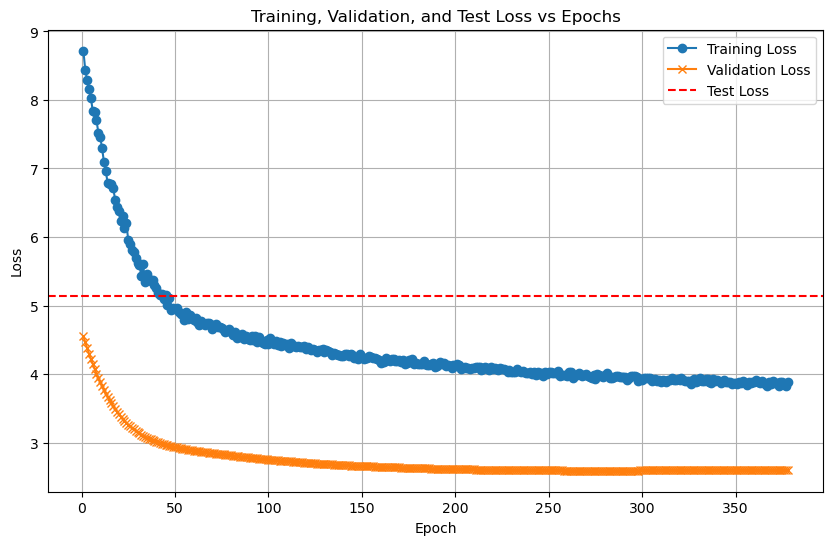

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.


  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.
  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.


  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.
  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      0.60      0.67         5
           2       0.50      0.60      0.55         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.67      0.80      0.73         5
           6       0.71      1.00      0.83         5
           7       0.67      0.40      0.50         5
           8       1.00      1.00      1.00         5

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.77        45


LOG: Evaluating on the test set...
Test Accuracy: 69.10%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1241  |  Val Loss: 2.0813
Validation loss improved from inf to 2.0813.
[Epoch 2/1000] Train Loss: 2.0584  |  Val Loss: 2.0238
Validation loss improved from 2.0813 to 2.0238.
[Epoch 3/1000] Train Loss: 2.0021  |  Val Loss: 1.9726
Validation loss improved from 2.0238 to 1.9726.
[Epoch 4/1000] Train Loss: 1.9487  |  Val Loss: 1.9249
Validation loss improved from 1.9726 to 1.9249.
[Epoch 5/1000] Train Loss: 1.9001  |  Val Loss: 1.8797
Validation loss improved from 1.9249 to 1.8797.
[Epoch 6/1000] Train Loss: 1.8553  |  Val Loss: 1.8376
Validation loss improved from 1.8797 to 1.8376.
[Epoch 7/1000] Train Loss: 1.8128  |  Val Loss: 1.7994
Validation loss improved from 1.8376 to 1.7994.
[Epoch 8/1000] Train Loss: 1.7727  |  Val Loss: 1.7643
Validation loss improved from 1.7994 to 1.7643.
[Epoch 9/1000] Train Loss: 1.7364  |  Val Loss: 1.7314
Validation loss improved from 1.7643 to 1.7314.
[Epoch 10/1000] Train Loss: 1.7016  |  Val Loss: 1.7012
Validation loss impr

[Epoch 15/1000] Train Loss: 1.5509  |  Val Loss: 1.5648
Validation loss improved from 1.5909 to 1.5648.
[Epoch 16/1000] Train Loss: 1.5237  |  Val Loss: 1.5391
Validation loss improved from 1.5648 to 1.5391.
[Epoch 17/1000] Train Loss: 1.4958  |  Val Loss: 1.5145
Validation loss improved from 1.5391 to 1.5145.
[Epoch 18/1000] Train Loss: 1.4696  |  Val Loss: 1.4904
Validation loss improved from 1.5145 to 1.4904.
[Epoch 19/1000] Train Loss: 1.4431  |  Val Loss: 1.4670
Validation loss improved from 1.4904 to 1.4670.


[Epoch 20/1000] Train Loss: 1.4184  |  Val Loss: 1.4441
Validation loss improved from 1.4670 to 1.4441.
[Epoch 21/1000] Train Loss: 1.3933  |  Val Loss: 1.4224
Validation loss improved from 1.4441 to 1.4224.
[Epoch 22/1000] Train Loss: 1.3689  |  Val Loss: 1.4016
Validation loss improved from 1.4224 to 1.4016.
[Epoch 23/1000] Train Loss: 1.3458  |  Val Loss: 1.3806
Validation loss improved from 1.4016 to 1.3806.
[Epoch 24/1000] Train Loss: 1.3233  |  Val Loss: 1.3607
Validation loss improved from 1.3806 to 1.3607.
[Epoch 25/1000] Train Loss: 1.3015  |  Val Loss: 1.3416
Validation loss improved from 1.3607 to 1.3416.
[Epoch 26/1000] Train Loss: 1.2800  |  Val Loss: 1.3232
Validation loss improved from 1.3416 to 1.3232.
[Epoch 27/1000] Train Loss: 1.2593  |  Val Loss: 1.3052
Validation loss improved from 1.3232 to 1.3052.
[Epoch 28/1000] Train Loss: 1.2387  |  Val Loss: 1.2871
Validation loss improved from 1.3052 to 1.2871.
[Epoch 29/1000] Train Loss: 1.2187  |  Val Loss: 1.2685
Validati

[Epoch 33/1000] Train Loss: 1.1409  |  Val Loss: 1.1976
Validation loss improved from 1.2147 to 1.1976.
[Epoch 34/1000] Train Loss: 1.1222  |  Val Loss: 1.1808
Validation loss improved from 1.1976 to 1.1808.
[Epoch 35/1000] Train Loss: 1.1034  |  Val Loss: 1.1646
Validation loss improved from 1.1808 to 1.1646.
[Epoch 36/1000] Train Loss: 1.0850  |  Val Loss: 1.1483
Validation loss improved from 1.1646 to 1.1483.
[Epoch 37/1000] Train Loss: 1.0669  |  Val Loss: 1.1317
Validation loss improved from 1.1483 to 1.1317.


[Epoch 38/1000] Train Loss: 1.0489  |  Val Loss: 1.1150
Validation loss improved from 1.1317 to 1.1150.
[Epoch 39/1000] Train Loss: 1.0309  |  Val Loss: 1.0984
Validation loss improved from 1.1150 to 1.0984.
[Epoch 40/1000] Train Loss: 1.0124  |  Val Loss: 1.0833
Validation loss improved from 1.0984 to 1.0833.
[Epoch 41/1000] Train Loss: 0.9948  |  Val Loss: 1.0679
Validation loss improved from 1.0833 to 1.0679.
[Epoch 42/1000] Train Loss: 0.9777  |  Val Loss: 1.0528
Validation loss improved from 1.0679 to 1.0528.
[Epoch 43/1000] Train Loss: 0.9603  |  Val Loss: 1.0383
Validation loss improved from 1.0528 to 1.0383.
[Epoch 44/1000] Train Loss: 0.9434  |  Val Loss: 1.0238
Validation loss improved from 1.0383 to 1.0238.
[Epoch 45/1000] Train Loss: 0.9273  |  Val Loss: 1.0094
Validation loss improved from 1.0238 to 1.0094.
[Epoch 46/1000] Train Loss: 0.9111  |  Val Loss: 0.9951
Validation loss improved from 1.0094 to 0.9951.
[Epoch 47/1000] Train Loss: 0.8956  |  Val Loss: 0.9811
Validati

[Epoch 50/1000] Train Loss: 0.8506  |  Val Loss: 0.9436
Validation loss improved from 0.9561 to 0.9436.
[Epoch 51/1000] Train Loss: 0.8367  |  Val Loss: 0.9312
Validation loss improved from 0.9436 to 0.9312.
[Epoch 52/1000] Train Loss: 0.8227  |  Val Loss: 0.9185
Validation loss improved from 0.9312 to 0.9185.
[Epoch 53/1000] Train Loss: 0.8089  |  Val Loss: 0.9072
Validation loss improved from 0.9185 to 0.9072.
[Epoch 54/1000] Train Loss: 0.7959  |  Val Loss: 0.8964
Validation loss improved from 0.9072 to 0.8964.
[Epoch 55/1000] Train Loss: 0.7832  |  Val Loss: 0.8851
Validation loss improved from 0.8964 to 0.8851.
[Epoch 56/1000] Train Loss: 0.7710  |  Val Loss: 0.8748
Validation loss improved from 0.8851 to 0.8748.


[Epoch 57/1000] Train Loss: 0.7588  |  Val Loss: 0.8647
Validation loss improved from 0.8748 to 0.8647.
[Epoch 58/1000] Train Loss: 0.7471  |  Val Loss: 0.8553
Validation loss improved from 0.8647 to 0.8553.
[Epoch 59/1000] Train Loss: 0.7362  |  Val Loss: 0.8453
Validation loss improved from 0.8553 to 0.8453.
[Epoch 60/1000] Train Loss: 0.7250  |  Val Loss: 0.8357
Validation loss improved from 0.8453 to 0.8357.
[Epoch 61/1000] Train Loss: 0.7144  |  Val Loss: 0.8267
Validation loss improved from 0.8357 to 0.8267.
[Epoch 62/1000] Train Loss: 0.7038  |  Val Loss: 0.8185
Validation loss improved from 0.8267 to 0.8185.
[Epoch 63/1000] Train Loss: 0.6940  |  Val Loss: 0.8105
Validation loss improved from 0.8185 to 0.8105.
[Epoch 64/1000] Train Loss: 0.6849  |  Val Loss: 0.8032
Validation loss improved from 0.8105 to 0.8032.
[Epoch 65/1000] Train Loss: 0.6754  |  Val Loss: 0.7953
Validation loss improved from 0.8032 to 0.7953.
[Epoch 66/1000] Train Loss: 0.6659  |  Val Loss: 0.7882
Validati

[Epoch 67/1000] Train Loss: 0.6572  |  Val Loss: 0.7808
Validation loss improved from 0.7882 to 0.7808.
[Epoch 68/1000] Train Loss: 0.6489  |  Val Loss: 0.7736
Validation loss improved from 0.7808 to 0.7736.
[Epoch 69/1000] Train Loss: 0.6406  |  Val Loss: 0.7673
Validation loss improved from 0.7736 to 0.7673.
[Epoch 70/1000] Train Loss: 0.6330  |  Val Loss: 0.7611
Validation loss improved from 0.7673 to 0.7611.
[Epoch 71/1000] Train Loss: 0.6255  |  Val Loss: 0.7555
Validation loss improved from 0.7611 to 0.7555.
[Epoch 72/1000] Train Loss: 0.6180  |  Val Loss: 0.7502
Validation loss improved from 0.7555 to 0.7502.


[Epoch 73/1000] Train Loss: 0.6111  |  Val Loss: 0.7453
Validation loss improved from 0.7502 to 0.7453.
[Epoch 74/1000] Train Loss: 0.6044  |  Val Loss: 0.7400
Validation loss improved from 0.7453 to 0.7400.
[Epoch 75/1000] Train Loss: 0.5974  |  Val Loss: 0.7352
Validation loss improved from 0.7400 to 0.7352.
[Epoch 76/1000] Train Loss: 0.5909  |  Val Loss: 0.7310
Validation loss improved from 0.7352 to 0.7310.
[Epoch 77/1000] Train Loss: 0.5847  |  Val Loss: 0.7269
Validation loss improved from 0.7310 to 0.7269.
[Epoch 78/1000] Train Loss: 0.5779  |  Val Loss: 0.7223
Validation loss improved from 0.7269 to 0.7223.
[Epoch 79/1000] Train Loss: 0.5710  |  Val Loss: 0.7178
Validation loss improved from 0.7223 to 0.7178.
[Epoch 80/1000] Train Loss: 0.5649  |  Val Loss: 0.7137
Validation loss improved from 0.7178 to 0.7137.
[Epoch 81/1000] Train Loss: 0.5585  |  Val Loss: 0.7096
Validation loss improved from 0.7137 to 0.7096.
[Epoch 82/1000] Train Loss: 0.5529  |  Val Loss: 0.7061
Validati

[Epoch 85/1000] Train Loss: 0.5372  |  Val Loss: 0.6953
Validation loss improved from 0.6986 to 0.6953.
[Epoch 86/1000] Train Loss: 0.5326  |  Val Loss: 0.6924
Validation loss improved from 0.6953 to 0.6924.
[Epoch 87/1000] Train Loss: 0.5279  |  Val Loss: 0.6892
Validation loss improved from 0.6924 to 0.6892.
[Epoch 88/1000] Train Loss: 0.5239  |  Val Loss: 0.6866
Validation loss improved from 0.6892 to 0.6866.
[Epoch 89/1000] Train Loss: 0.5200  |  Val Loss: 0.6841
Validation loss improved from 0.6866 to 0.6841.
[Epoch 90/1000] Train Loss: 0.5156  |  Val Loss: 0.6808
Validation loss improved from 0.6841 to 0.6808.


[Epoch 91/1000] Train Loss: 0.5114  |  Val Loss: 0.6782
Validation loss improved from 0.6808 to 0.6782.
[Epoch 92/1000] Train Loss: 0.5074  |  Val Loss: 0.6764
Validation loss improved from 0.6782 to 0.6764.
[Epoch 93/1000] Train Loss: 0.5030  |  Val Loss: 0.6746
Validation loss improved from 0.6764 to 0.6746.
[Epoch 94/1000] Train Loss: 0.4992  |  Val Loss: 0.6720
Validation loss improved from 0.6746 to 0.6720.
[Epoch 95/1000] Train Loss: 0.4959  |  Val Loss: 0.6699
Validation loss improved from 0.6720 to 0.6699.
[Epoch 96/1000] Train Loss: 0.4931  |  Val Loss: 0.6670
Validation loss improved from 0.6699 to 0.6670.
[Epoch 97/1000] Train Loss: 0.4890  |  Val Loss: 0.6643
Validation loss improved from 0.6670 to 0.6643.
[Epoch 98/1000] Train Loss: 0.4858  |  Val Loss: 0.6624
Validation loss improved from 0.6643 to 0.6624.
[Epoch 99/1000] Train Loss: 0.4827  |  Val Loss: 0.6613
Validation loss improved from 0.6624 to 0.6613.
[Epoch 100/1000] Train Loss: 0.4794  |  Val Loss: 0.6597
Validat

[Epoch 102/1000] Train Loss: 0.4734  |  Val Loss: 0.6555
Validation loss improved from 0.6573 to 0.6555.
[Epoch 103/1000] Train Loss: 0.4705  |  Val Loss: 0.6534
Validation loss improved from 0.6555 to 0.6534.
[Epoch 104/1000] Train Loss: 0.4679  |  Val Loss: 0.6519
Validation loss improved from 0.6534 to 0.6519.
[Epoch 105/1000] Train Loss: 0.4648  |  Val Loss: 0.6505
Validation loss improved from 0.6519 to 0.6505.


[Epoch 106/1000] Train Loss: 0.4622  |  Val Loss: 0.6490
Validation loss improved from 0.6505 to 0.6490.
[Epoch 107/1000] Train Loss: 0.4594  |  Val Loss: 0.6477
Validation loss improved from 0.6490 to 0.6477.
[Epoch 108/1000] Train Loss: 0.4568  |  Val Loss: 0.6458
Validation loss improved from 0.6477 to 0.6458.
[Epoch 109/1000] Train Loss: 0.4543  |  Val Loss: 0.6445
Validation loss improved from 0.6458 to 0.6445.
[Epoch 110/1000] Train Loss: 0.4517  |  Val Loss: 0.6432
Validation loss improved from 0.6445 to 0.6432.
[Epoch 111/1000] Train Loss: 0.4495  |  Val Loss: 0.6423
Validation loss improved from 0.6432 to 0.6423.
[Epoch 112/1000] Train Loss: 0.4471  |  Val Loss: 0.6408
Validation loss improved from 0.6423 to 0.6408.
[Epoch 113/1000] Train Loss: 0.4446  |  Val Loss: 0.6397
Validation loss improved from 0.6408 to 0.6397.
[Epoch 114/1000] Train Loss: 0.4424  |  Val Loss: 0.6384
Validation loss improved from 0.6397 to 0.6384.
[Epoch 115/1000] Train Loss: 0.4402  |  Val Loss: 0.637

[Epoch 118/1000] Train Loss: 0.4334  |  Val Loss: 0.6343
Validation loss improved from 0.6355 to 0.6343.
[Epoch 119/1000] Train Loss: 0.4313  |  Val Loss: 0.6338
Validation loss improved from 0.6343 to 0.6338.
[Epoch 120/1000] Train Loss: 0.4295  |  Val Loss: 0.6332
Validation loss improved from 0.6338 to 0.6332.
[Epoch 121/1000] Train Loss: 0.4276  |  Val Loss: 0.6321
Validation loss improved from 0.6332 to 0.6321.


[Epoch 122/1000] Train Loss: 0.4257  |  Val Loss: 0.6315
Validation loss improved from 0.6321 to 0.6315.
[Epoch 123/1000] Train Loss: 0.4236  |  Val Loss: 0.6309
Validation loss improved from 0.6315 to 0.6309.
[Epoch 124/1000] Train Loss: 0.4221  |  Val Loss: 0.6305
Validation loss improved from 0.6309 to 0.6305.
[Epoch 125/1000] Train Loss: 0.4196  |  Val Loss: 0.6293
Validation loss improved from 0.6305 to 0.6293.
[Epoch 126/1000] Train Loss: 0.4178  |  Val Loss: 0.6282
Validation loss improved from 0.6293 to 0.6282.
[Epoch 127/1000] Train Loss: 0.4162  |  Val Loss: 0.6272
Validation loss improved from 0.6282 to 0.6272.
[Epoch 128/1000] Train Loss: 0.4141  |  Val Loss: 0.6266
Validation loss improved from 0.6272 to 0.6266.
[Epoch 129/1000] Train Loss: 0.4130  |  Val Loss: 0.6263
Validation loss improved from 0.6266 to 0.6263.
[Epoch 130/1000] Train Loss: 0.4111  |  Val Loss: 0.6258
Validation loss improved from 0.6263 to 0.6258.
[Epoch 131/1000] Train Loss: 0.4088  |  Val Loss: 0.625

[Epoch 134/1000] Train Loss: 0.4034  |  Val Loss: 0.6239
Validation loss improved from 0.6242 to 0.6239.
[Epoch 135/1000] Train Loss: 0.4018  |  Val Loss: 0.6240
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 0.3997  |  Val Loss: 0.6238
Validation loss improved from 0.6239 to 0.6238.
[Epoch 137/1000] Train Loss: 0.3982  |  Val Loss: 0.6229
Validation loss improved from 0.6238 to 0.6229.
[Epoch 138/1000] Train Loss: 0.3961  |  Val Loss: 0.6226
Validation loss improved from 0.6229 to 0.6226.


[Epoch 139/1000] Train Loss: 0.3947  |  Val Loss: 0.6220
Validation loss improved from 0.6226 to 0.6220.
[Epoch 140/1000] Train Loss: 0.3935  |  Val Loss: 0.6223
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 0.3912  |  Val Loss: 0.6214
Validation loss improved from 0.6220 to 0.6214.
[Epoch 142/1000] Train Loss: 0.3895  |  Val Loss: 0.6211
Validation loss improved from 0.6214 to 0.6211.
[Epoch 143/1000] Train Loss: 0.3881  |  Val Loss: 0.6206
Validation loss improved from 0.6211 to 0.6206.
[Epoch 144/1000] Train Loss: 0.3864  |  Val Loss: 0.6200
Validation loss improved from 0.6206 to 0.6200.
[Epoch 145/1000] Train Loss: 0.3850  |  Val Loss: 0.6195
Validation loss improved from 0.6200 to 0.6195.
[Epoch 146/1000] Train Loss: 0.3833  |  Val Loss: 0.6192
Validation loss improved from 0.6195 to 0.6192.
[Epoch 147/1000] Train Loss: 0.3821  |  Val Loss: 0.6193
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 148/1000] Train Loss: 0.3806  |  Val Loss: 0.6192
Validation loss improved from 0.6192 to 0.6192.
[Epoch 149/1000] Train Loss: 0.3790  |  Val Loss: 0.6191
Validation loss improved from 0.6192 to 0.6191.
[Epoch 150/1000] Train Loss: 0.3774  |  Val Loss: 0.6185
Validation loss improved from 0.6191 to 0.6185.
[Epoch 151/1000] Train Loss: 0.3757  |  Val Loss: 0.6184
Validation loss improved from 0.6185 to 0.6184.
[Epoch 152/1000] Train Loss: 0.3747  |  Val Loss: 0.6183
Validation loss improved from 0.6184 to 0.6183.
[Epoch 153/1000] Train Loss: 0.3731  |  Val Loss: 0.6177
Validation loss improved from 0.6183 to 0.6177.
[Epoch 154/1000] Train Loss: 0.3719  |  Val Loss: 0.6176
Validation loss improved from 0.6177 to 0.6176.
[Epoch 155/1000] Train Loss: 0.3703  |  Val Loss: 0.6172
Validation loss improved from 0.6176 to 0.6172.


[Epoch 156/1000] Train Loss: 0.3690  |  Val Loss: 0.6166
Validation loss improved from 0.6172 to 0.6166.
[Epoch 157/1000] Train Loss: 0.3678  |  Val Loss: 0.6167
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 158/1000] Train Loss: 0.3664  |  Val Loss: 0.6166
Validation loss improved from 0.6166 to 0.6166.
[Epoch 159/1000] Train Loss: 0.3648  |  Val Loss: 0.6160
Validation loss improved from 0.6166 to 0.6160.
[Epoch 160/1000] Train Loss: 0.3642  |  Val Loss: 0.6157
Validation loss improved from 0.6160 to 0.6157.
[Epoch 161/1000] Train Loss: 0.3628  |  Val Loss: 0.6155
Validation loss improved from 0.6157 to 0.6155.
[Epoch 162/1000] Train Loss: 0.3618  |  Val Loss: 0.6159
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 0.3606  |  Val Loss: 0.6156
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Train Loss: 0.3592  |  Val Loss: 0.6163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 165/1000] Train Loss: 0.

[Epoch 168/1000] Train Loss: 0.3547  |  Val Loss: 0.6153
Validation loss improved from 0.6155 to 0.6153.
[Epoch 169/1000] Train Loss: 0.3533  |  Val Loss: 0.6150
Validation loss improved from 0.6153 to 0.6150.
[Epoch 170/1000] Train Loss: 0.3526  |  Val Loss: 0.6158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 0.3509  |  Val Loss: 0.6157
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 0.3504  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 173/1000] Train Loss: 0.3489  |  Val Loss: 0.6152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 174/1000] Train Loss: 0.3479  |  Val Loss: 0.6148
Validation loss improved from 0.6150 to 0.6148.
[Epoch 175/1000] Train Loss: 0.3475  |  Val Loss: 0.6153
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 176/1000] Train Loss: 0.3462  |  Val Loss: 0.6142
Validation loss improved from 0.6148 to 0.6142.
[Epoch 177/1000] Train Loss: 0.3469  |  Val Loss: 0.6159
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.3439  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 179/1000] Train Loss: 0.3432  |  Val Loss: 0.6167
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 180/1000] Train Loss: 0.3424  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 181/1000] Train Loss: 0.3426  |  Val Loss: 0.6154
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 182/1000] Train Loss: 0.3400  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 183/1000] Train Loss: 0.3395  |  Val Loss: 0.6161
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 184/1000] Train Loss: 0.3383  |  Val Loss: 0.6157
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 185/1000] Train Loss: 0.3372  |  Val Loss: 0.6162
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 186/1000] Train Loss: 0.3365  |  Val Loss: 0.6161
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 187/1000] Train Loss: 0.3353  |  Val Loss: 0.6155
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 188/1000] Train Loss: 0.3349  |  Val Loss: 0.6155
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 189/1000] Train Loss: 0.3339  |  Val Loss: 0.6163
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 190/1000] Train Loss: 0.3328  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 191/1000] Train Loss: 0.3323  |  Val Loss: 0.6175
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 192/1000] Train Loss: 0.3319  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 193/1000] Train Loss: 0.3306  |  Val Loss: 0.6168
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 194/1000] Train Loss: 0.3295  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 195/1000] Train Loss: 0.3287  |  Val Loss: 0.6169
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 196/1000] Train Loss: 0.3278  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 197/1000] Train Loss: 0.3270  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 198/1000] Train Loss: 0.3261  |  Val Loss: 0.6179
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 199/1000] Train Loss: 0.3265  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.3246  |  Val Loss: 0.6179
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 202/1000] Train Loss: 0.3232  |  Val Loss: 0.6182
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 203/1000] Train Loss: 0.3225  |  Val Loss: 0.6191
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 204/1000] Train Loss: 0.3217  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 205/1000] Train Loss: 0.3213  |  Val Loss: 0.6191
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 206/1000] Train Loss: 0.3206  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 207/1000] Train Loss: 0.3197  |  Val Loss: 0.6182
!! Validation loss did NOT improve !! Patience: 31/100


[Epoch 208/1000] Train Loss: 0.3195  |  Val Loss: 0.6177
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 209/1000] Train Loss: 0.3187  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 210/1000] Train Loss: 0.3178  |  Val Loss: 0.6198
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 211/1000] Train Loss: 0.3175  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 212/1000] Train Loss: 0.3158  |  Val Loss: 0.6187
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 213/1000] Train Loss: 0.3152  |  Val Loss: 0.6192
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 214/1000] Train Loss: 0.3149  |  Val Loss: 0.6197
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 215/1000] Train Loss: 0.3143  |  Val Loss: 0.6215
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 216/1000] Train Loss: 0.3132  |  Val Loss: 0.6216
!! Validation loss did NOT improve !! Patience:

[Epoch 220/1000] Train Loss: 0.3103  |  Val Loss: 0.6214
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 221/1000] Train Loss: 0.3104  |  Val Loss: 0.6209
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 222/1000] Train Loss: 0.3097  |  Val Loss: 0.6213
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 223/1000] Train Loss: 0.3088  |  Val Loss: 0.6211
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 224/1000] Train Loss: 0.3083  |  Val Loss: 0.6229
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 225/1000] Train Loss: 0.3077  |  Val Loss: 0.6223
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 226/1000] Train Loss: 0.3071  |  Val Loss: 0.6237
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 227/1000] Train Loss: 0.3059  |  Val Loss: 0.6245
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 228/1000] Train Loss: 0.3053  |  Val Loss: 0.6247
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 229/1000] Train Loss: 0.3049  |  Val Loss: 0.6242
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 230/1000] Train Loss: 0.3049  |  Val Loss: 0.6232
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 231/1000] Train Loss: 0.3038  |  Val Loss: 0.6245
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 232/1000] Train Loss: 0.3029  |  Val Loss: 0.6248
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 233/1000] Train Loss: 0.3027  |  Val Loss: 0.6253
!! Validation loss did NOT improve !! Patience:

[Epoch 238/1000] Train Loss: 0.2994  |  Val Loss: 0.6247
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 239/1000] Train Loss: 0.2995  |  Val Loss: 0.6264
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 240/1000] Train Loss: 0.2987  |  Val Loss: 0.6263
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 241/1000] Train Loss: 0.2984  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 242/1000] Train Loss: 0.2977  |  Val Loss: 0.6272
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 243/1000] Train Loss: 0.2970  |  Val Loss: 0.6274
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 244/1000] Train Loss: 0.2963  |  Val Loss: 0.6244
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 245/1000] Train Loss: 0.2957  |  Val Loss: 0.6253
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 246/1000] Train Loss: 0.2958  |  Val Loss: 0.6283
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 247/1000] Train Loss: 0.2945  |  Val Loss: 0.6275
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 248/1000] Train Loss: 0.2943  |  Val Loss: 0.6264
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 249/1000] Train Loss: 0.2935  |  Val Loss: 0.6256
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 250/1000] Train Loss: 0.2931  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.2893  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 258/1000] Train Loss: 0.2898  |  Val Loss: 0.6311
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 259/1000] Train Loss: 0.2885  |  Val Loss: 0.6298
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 260/1000] Train Loss: 0.2884  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 261/1000] Train Loss: 0.2874  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 262/1000] Train Loss: 0.2865  |  Val Loss: 0.6316
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 263/1000] Train Loss: 0.2862  |  Val Loss: 0.6328
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 264/1000] Train Loss: 0.2866  |  Val Loss: 0.6343
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 265/1000] Train Loss: 0.2857  |  Val Loss: 0.6319
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 266/1000] Train Loss: 0.2849  |  Val Loss: 0.6300
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 267/1000] Train Loss: 0.2843  |  Val Loss: 0.6300
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 268/1000] Train Loss: 0.2837  |  Val Loss: 0.6305
!! Validation loss did NOT improve !! Patience:

[Epoch 273/1000] Train Loss: 0.2824  |  Val Loss: 0.6343
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 274/1000] Train Loss: 0.2814  |  Val Loss: 0.6338
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 275/1000] Train Loss: 0.2805  |  Val Loss: 0.6332
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 276/1000] Train Loss: 0.2801  |  Val Loss: 0.6318
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 276 !!
No improvement for 100 epochs.


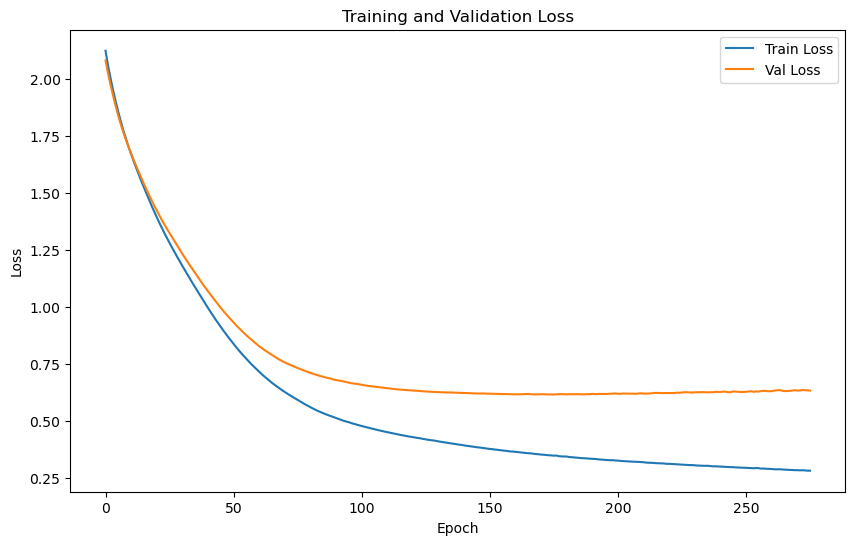

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8906 | Test Accuracy: 63.22%


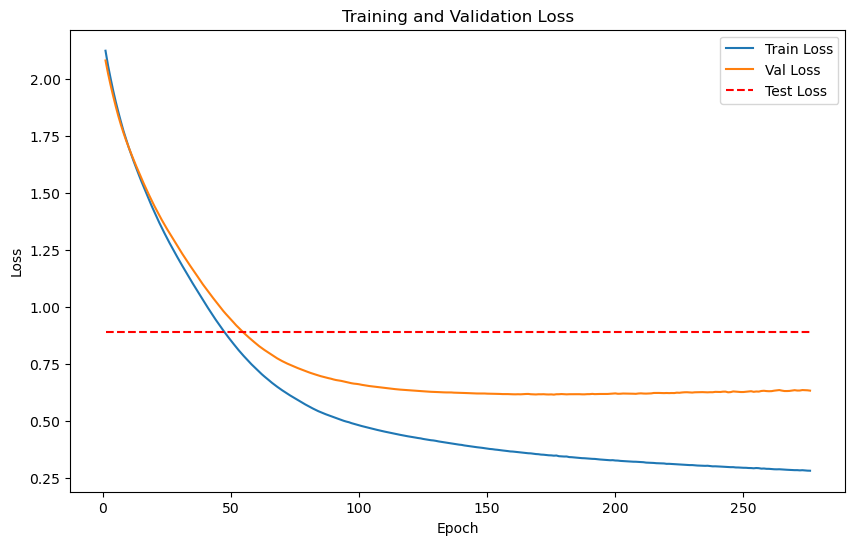

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4670


    Batch [2/2], Train Loss: 0.4652
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4362
Epoch [1/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4362

Validation loss improved from inf to 0.4362. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4634


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [2/2000] - Validation


    Batch [1/1], Val Loss: 0.4322
Epoch [2/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4322

Validation loss improved from 0.4362 to 0.4322. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4590
    Batch [2/2], Train Loss: 0.4615
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4305
Epoch [3/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4305

Validation loss improved from 0.4322 to 0.4305. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4606
    Batch [2/2], Train Loss: 0.4558
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4298
Epoch [4/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4298

Validation loss improved from 0.4305 to 0.4298. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4581
    Batch [2/2], Train Loss: 0.4575
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4307
Epoch [5/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4307

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4529
    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4309
Epoch [6/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4309

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4554


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4300
Epoch [7/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4300

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4469
    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4283
Epoch [8/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4283

Validation loss improved from 0.4298 to 0.4283. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4521
    Batch [2/2], Train Loss: 0.4519
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4263
Epoch [9/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4263

Validation loss improved from 0.4283 to 0.4263. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4479
    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4242
Epoch [10/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4242

Validation loss improved from 0.4263 to 0.4242. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4454


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4223
Epoch [11/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4223

Validation loss improved from 0.4242 to 0.4223. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4428


    Batch [2/2], Train Loss: 0.4470
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4206
Epoch [12/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4206

Validation loss improved from 0.4223 to 0.4206. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4417
    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [13/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4191

Validation loss improved from 0.4206 to 0.4191. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4422
    Batch [2/2], Train Loss: 0.4423
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4176
Epoch [14/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4176

Validation loss improved from 0.4191 to 0.4176. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4412


    Batch [2/2], Train Loss: 0.4438
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4163
Epoch [15/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.4163

Validation loss improved from 0.4176 to 0.4163. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4391
    Batch [2/2], Train Loss: 0.4380
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4148
Epoch [16/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4148

Validation loss improved from 0.4163 to 0.4148. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4357
    Batch [2/2], Train Loss: 0.4313
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4136
Epoch [17/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4136

Validation loss improved from 0.4148 to 0.4136. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4323


    Batch [2/2], Train Loss: 0.4307
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4124
Epoch [18/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4124

Validation loss improved from 0.4136 to 0.4124. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4352
    Batch [2/2], Train Loss: 0.4320
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4114
Epoch [19/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4114

Validation loss improved from 0.4124 to 0.4114. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4314
    Batch [2/2], Train Loss: 0.4289
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4102
Epoch [20/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.4102

Validation loss improved from 0.4114 to 0.4102. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4288


    Batch [2/2], Train Loss: 0.4288
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4090
Epoch [21/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4090

Validation loss improved from 0.4102 to 0.4090. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4314
    Batch [2/2], Train Loss: 0.4294
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4078
Epoch [22/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4078

Validation loss improved from 0.4090 to 0.4078. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4234
    Batch [2/2], Train Loss: 0.4285
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [23/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.4066

Validation loss improved from 0.4078 to 0.4066. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4212


    Batch [2/2], Train Loss: 0.4188
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4055
Epoch [24/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.4055

Validation loss improved from 0.4066 to 0.4055. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4254
    Batch [2/2], Train Loss: 0.4266
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4042
Epoch [25/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.4042

Validation loss improved from 0.4055 to 0.4042. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4239
    Batch [2/2], Train Loss: 0.4250
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [26/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4031

Validation loss improved from 0.4042 to 0.4031. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4243


    Batch [2/2], Train Loss: 0.4212
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4019
Epoch [27/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.4019

Validation loss improved from 0.4031 to 0.4019. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4232
    Batch [2/2], Train Loss: 0.4188
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.4008
Epoch [28/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.4008

Validation loss improved from 0.4019 to 0.4008. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4191
    Batch [2/2], Train Loss: 0.4264
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3998
Epoch [29/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3998

Validation loss improved from 0.4008 to 0.3998. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4276
    Batch [2/2], Train Loss: 0.4198
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3987
Epoch [30/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3987

Validation loss improved from 0.3998 to 0.3987. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4179


    Batch [2/2], Train Loss: 0.4156
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [31/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.3975

Validation loss improved from 0.3987 to 0.3975. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4221
    Batch [2/2], Train Loss: 0.4147
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3966
Epoch [32/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3966

Validation loss improved from 0.3975 to 0.3966. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4212
    Batch [2/2], Train Loss: 0.4115
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [33/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3957

Validation loss improved from 0.3966 to 0.3957. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4132
    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3950
Epoch [34/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3950

Validation loss improved from 0.3957 to 0.3950. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.4173


    Batch [2/2], Train Loss: 0.4163
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [35/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.3939

Validation loss improved from 0.3950 to 0.3939. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4185
    Batch [2/2], Train Loss: 0.4184
LOG: Epoch [36/2000] - Validation


    Batch [1/1], Val Loss: 0.3930
Epoch [36/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3930

Validation loss improved from 0.3939 to 0.3930. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4156
    Batch [2/2], Train Loss: 0.4160
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [37/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3921

Validation loss improved from 0.3930 to 0.3921. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4141
    Batch [2/2], Train Loss: 0.4106
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3911
Epoch [38/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3911

Validation loss improved from 0.3921 to 0.3911. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.4098


    Batch [2/2], Train Loss: 0.4072
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [39/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3904

Validation loss improved from 0.3911 to 0.3904. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4110
    Batch [2/2], Train Loss: 0.4026
LOG: Epoch [40/2000] - Validation


    Batch [1/1], Val Loss: 0.3895
Epoch [40/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3895

Validation loss improved from 0.3904 to 0.3895. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4064
    Batch [2/2], Train Loss: 0.4095
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [41/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3887

Validation loss improved from 0.3895 to 0.3887. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4115
    Batch [2/2], Train Loss: 0.4085
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [42/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3880

Validation loss improved from 0.3887 to 0.3880. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4082


    Batch [2/2], Train Loss: 0.4123
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [43/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.3874

Validation loss improved from 0.3880 to 0.3874. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.3998
    Batch [2/2], Train Loss: 0.4072
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.3867
Epoch [44/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3867

Validation loss improved from 0.3874 to 0.3867. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4041
    Batch [2/2], Train Loss: 0.4016
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [45/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3858

Validation loss improved from 0.3867 to 0.3858. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4059
    Batch [2/2], Train Loss: 0.4006
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [46/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3851

Validation loss improved from 0.3858 to 0.3851. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4002


    Batch [2/2], Train Loss: 0.3959
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [47/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3844

Validation loss improved from 0.3851 to 0.3844. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4016
    Batch [2/2], Train Loss: 0.4051
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3838
Epoch [48/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3838

Validation loss improved from 0.3844 to 0.3838. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4019
    Batch [2/2], Train Loss: 0.3990
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3832
Epoch [49/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3832

Validation loss improved from 0.3838 to 0.3832. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4047
    Batch [2/2], Train Loss: 0.3987
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [50/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3824

Validation loss improved from 0.3832 to 0.3824. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3974
    Batch [2/2], Train Loss: 0.4055
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [51/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3817

Validation loss improved from 0.3824 to 0.3817. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4015


    Batch [2/2], Train Loss: 0.3973
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3810
Epoch [52/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3810

Validation loss improved from 0.3817 to 0.3810. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3935
    Batch [2/2], Train Loss: 0.3974
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [53/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3802

Validation loss improved from 0.3810 to 0.3802. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4013
    Batch [2/2], Train Loss: 0.3925
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [54/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3797

Validation loss improved from 0.3802 to 0.3797. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3988


    Batch [2/2], Train Loss: 0.3987
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [55/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3790

Validation loss improved from 0.3797 to 0.3790. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3915
    Batch [2/2], Train Loss: 0.3946
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3786
Epoch [56/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3786

Validation loss improved from 0.3790 to 0.3786. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3894
    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [57/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3781

Validation loss improved from 0.3786 to 0.3781. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3982
    Batch [2/2], Train Loss: 0.3928
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [58/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3772

Validation loss improved from 0.3781 to 0.3772. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3919


    Batch [2/2], Train Loss: 0.3845
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [59/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3767

Validation loss improved from 0.3772 to 0.3767. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3897
    Batch [2/2], Train Loss: 0.3916
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [60/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3760

Validation loss improved from 0.3767 to 0.3760. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3915
    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [61/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3755

Validation loss improved from 0.3760 to 0.3755. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3866


    Batch [2/2], Train Loss: 0.3888
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [62/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3749

Validation loss improved from 0.3755 to 0.3749. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3818
    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [63/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3743

Validation loss improved from 0.3749 to 0.3743. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3910
    Batch [2/2], Train Loss: 0.3940
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [64/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3737

Validation loss improved from 0.3743 to 0.3737. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3900


    Batch [2/2], Train Loss: 0.3892
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [65/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3734

Validation loss improved from 0.3737 to 0.3734. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3846
    Batch [2/2], Train Loss: 0.3963
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3729
Epoch [66/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3729

Validation loss improved from 0.3734 to 0.3729. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3877
    Batch [2/2], Train Loss: 0.3913
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [67/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3727

Validation loss improved from 0.3729 to 0.3727. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3877


    Batch [2/2], Train Loss: 0.3767
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [68/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3724

Validation loss improved from 0.3727 to 0.3724. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3839
LOG: Epoch [69/2000] - Validation


    Batch [1/1], Val Loss: 0.3719
Epoch [69/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3719

Validation loss improved from 0.3724 to 0.3719. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3893
    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [70/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3717

Validation loss improved from 0.3719 to 0.3717. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3796
    Batch [2/2], Train Loss: 0.3831
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [71/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3711

Validation loss improved from 0.3717 to 0.3711. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3826


    Batch [2/2], Train Loss: 0.3764
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [72/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3706

Validation loss improved from 0.3711 to 0.3706. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3874
    Batch [2/2], Train Loss: 0.3777
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.3701
Epoch [73/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3701

Validation loss improved from 0.3706 to 0.3701. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3848
    Batch [2/2], Train Loss: 0.3888
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [74/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3697

Validation loss improved from 0.3701 to 0.3697. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3751
    Batch [2/2], Train Loss: 0.3772
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [75/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3694

Validation loss improved from 0.3697 to 0.3694. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3851


    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [76/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3689

Validation loss improved from 0.3694 to 0.3689. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3775
    Batch [2/2], Train Loss: 0.3851
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [77/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3687

Validation loss improved from 0.3689 to 0.3687. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3821
    Batch [2/2], Train Loss: 0.3730
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [78/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3682

Validation loss improved from 0.3687 to 0.3682. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3848


    Batch [2/2], Train Loss: 0.3720
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [79/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.3678

Validation loss improved from 0.3682 to 0.3678. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.3775
    Batch [2/2], Train Loss: 0.3782
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.3674
Epoch [80/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3674

Validation loss improved from 0.3678 to 0.3674. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3867
    Batch [2/2], Train Loss: 0.3692
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [81/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3672

Validation loss improved from 0.3674 to 0.3672. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [82/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3669

Validation loss improved from 0.3672 to 0.3669. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3738


    Batch [2/2], Train Loss: 0.3739
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3664
Epoch [83/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3664

Validation loss improved from 0.3669 to 0.3664. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3746
    Batch [2/2], Train Loss: 0.3664
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.3662
Epoch [84/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3662

Validation loss improved from 0.3664 to 0.3662. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3711
    Batch [2/2], Train Loss: 0.3764
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [85/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3658

Validation loss improved from 0.3662 to 0.3658. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3709
    Batch [2/2], Train Loss: 0.3792
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [86/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3651

Validation loss improved from 0.3658 to 0.3651. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3698


    Batch [2/2], Train Loss: 0.3622
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [87/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3650

Validation loss improved from 0.3651 to 0.3650. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3708
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [88/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3646

Validation loss improved from 0.3650 to 0.3646. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3696
    Batch [2/2], Train Loss: 0.3603
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [89/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.3644

Validation loss improved from 0.3646 to 0.3644. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3607


    Batch [2/2], Train Loss: 0.3681
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [90/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3642

Validation loss improved from 0.3644 to 0.3642. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3756
    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [91/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3638

Validation loss improved from 0.3642 to 0.3638. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3680
    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [92/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3635

Validation loss improved from 0.3638 to 0.3635. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3648


    Batch [2/2], Train Loss: 0.3629
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [93/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3634

Validation loss improved from 0.3635 to 0.3634. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3718
    Batch [2/2], Train Loss: 0.3655
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [94/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3631

Validation loss improved from 0.3634 to 0.3631. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3699
    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [95/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3628

Validation loss improved from 0.3631 to 0.3628. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3636


    Batch [2/2], Train Loss: 0.3725
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [96/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3626

Validation loss improved from 0.3628 to 0.3626. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3582
    Batch [2/2], Train Loss: 0.3562
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3623
Epoch [97/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3623

Validation loss improved from 0.3626 to 0.3623. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3670
    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [98/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3621

Validation loss improved from 0.3623 to 0.3621. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3665
    Batch [2/2], Train Loss: 0.3634
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [99/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3620

Validation loss improved from 0.3621 to 0.3620. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3662


    Batch [2/2], Train Loss: 0.3594
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [100/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3616

Validation loss improved from 0.3620 to 0.3616. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3587
    Batch [2/2], Train Loss: 0.3640
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3611
Epoch [101/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3611

Validation loss improved from 0.3616 to 0.3611. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3600
    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [102/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3608

Validation loss improved from 0.3611 to 0.3608. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3618
    Batch [2/2], Train Loss: 0.3583
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3606
Epoch [103/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3606

Validation loss improved from 0.3608 to 0.3606. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3531


    Batch [2/2], Train Loss: 0.3551
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [104/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3603

Validation loss improved from 0.3606 to 0.3603. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3524
    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [105/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3603

Validation loss improved from 0.3603 to 0.3603. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3638
    Batch [2/2], Train Loss: 0.3593
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [106/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3600

Validation loss improved from 0.3603 to 0.3600. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3589


    Batch [2/2], Train Loss: 0.3565
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [107/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3597

Validation loss improved from 0.3600 to 0.3597. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3568
    Batch [2/2], Train Loss: 0.3567
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [108/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3595

Validation loss improved from 0.3597 to 0.3595. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3635
    Batch [2/2], Train Loss: 0.3639
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [109/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3590

Validation loss improved from 0.3595 to 0.3590. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3489


    Batch [2/2], Train Loss: 0.3582
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [110/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3589

Validation loss improved from 0.3590 to 0.3589. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.3507
    Batch [2/2], Train Loss: 0.3440
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [111/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3584

Validation loss improved from 0.3589 to 0.3584. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3594
    Batch [2/2], Train Loss: 0.3566
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [112/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3580

Validation loss improved from 0.3584 to 0.3580. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3617


    Batch [2/2], Train Loss: 0.3565
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3576
Epoch [113/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3576

Validation loss improved from 0.3580 to 0.3576. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3588
    Batch [2/2], Train Loss: 0.3567
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [114/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3573

Validation loss improved from 0.3576 to 0.3573. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3603
    Batch [2/2], Train Loss: 0.3559
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3570
Epoch [115/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3570

Validation loss improved from 0.3573 to 0.3570. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.3500


    Batch [2/2], Train Loss: 0.3554
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [116/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3569

Validation loss improved from 0.3570 to 0.3569. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3510
    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [117/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3568

Validation loss improved from 0.3569 to 0.3568. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3572
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [118/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3566

Validation loss improved from 0.3568 to 0.3566. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.3582


    Batch [2/2], Train Loss: 0.3572
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [119/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3563

Validation loss improved from 0.3566 to 0.3563. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3513
    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [120/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3561

Validation loss improved from 0.3563 to 0.3561. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3461
    Batch [2/2], Train Loss: 0.3418
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [121/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3558

Validation loss improved from 0.3561 to 0.3558. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.3533


    Batch [2/2], Train Loss: 0.3561
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [122/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3556

Validation loss improved from 0.3558 to 0.3556. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.3501
    Batch [2/2], Train Loss: 0.3429
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3553
Epoch [123/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3553

Validation loss improved from 0.3556 to 0.3553. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3546
    Batch [2/2], Train Loss: 0.3508
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [124/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3550

Validation loss improved from 0.3553 to 0.3550. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3467
    Batch [2/2], Train Loss: 0.3434
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [125/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3549

Validation loss improved from 0.3550 to 0.3549. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.3487


    Batch [2/2], Train Loss: 0.3469
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [126/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3533
    Batch [2/2], Train Loss: 0.3438
LOG: Epoch [127/2000] - Validation


    Batch [1/1], Val Loss: 0.3550
Epoch [127/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3550

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.3449
    Batch [2/2], Train Loss: 0.3515
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [128/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.3548

Validation loss improved from 0.3549 to 0.3548. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3494
    Batch [2/2], Train Loss: 0.3569
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [129/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3545

Validation loss improved from 0.3548 to 0.3545. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.3472


    Batch [2/2], Train Loss: 0.3529
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [130/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3543

Validation loss improved from 0.3545 to 0.3543. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3456
    Batch [2/2], Train Loss: 0.3533
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [131/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.3542

Validation loss improved from 0.3543 to 0.3542. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3371
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [132/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3543

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3358


    Batch [2/2], Train Loss: 0.3466
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [133/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.3542

Validation loss improved from 0.3542 to 0.3542. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.3300
    Batch [2/2], Train Loss: 0.3438
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3542
Epoch [134/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3542

Validation loss improved from 0.3542 to 0.3542. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3437
    Batch [2/2], Train Loss: 0.3491
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [135/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3540

Validation loss improved from 0.3542 to 0.3540. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3443
    Batch [2/2], Train Loss: 0.3488
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [136/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3536

Validation loss improved from 0.3540 to 0.3536. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3428


    Batch [2/2], Train Loss: 0.3440
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3535
Epoch [137/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3535

Validation loss improved from 0.3536 to 0.3535. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3391
    Batch [2/2], Train Loss: 0.3501
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [138/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3533

Validation loss improved from 0.3535 to 0.3533. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3219
    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [139/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.3533

Validation loss improved from 0.3533 to 0.3533. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3385


    Batch [2/2], Train Loss: 0.3431
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [140/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3533

Validation loss improved from 0.3533 to 0.3533. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.3443
    Batch [2/2], Train Loss: 0.3314
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [141/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3532

Validation loss improved from 0.3533 to 0.3532. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3377
    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [142/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.3532

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3413


    Batch [2/2], Train Loss: 0.3402
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [143/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3531

Validation loss improved from 0.3532 to 0.3531. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.3398
    Batch [2/2], Train Loss: 0.3379
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [144/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3529

Validation loss improved from 0.3531 to 0.3529. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3315
    Batch [2/2], Train Loss: 0.3373
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [145/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3527

Validation loss improved from 0.3529 to 0.3527. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.3419


    Batch [2/2], Train Loss: 0.3437
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [146/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3526

Validation loss improved from 0.3527 to 0.3526. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.3390
    Batch [2/2], Train Loss: 0.3456
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [147/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3524

Validation loss improved from 0.3526 to 0.3524. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3318
    Batch [2/2], Train Loss: 0.3324
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [148/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3524

Validation loss improved from 0.3524 to 0.3524. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.3429


    Batch [2/2], Train Loss: 0.3420
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3523
Epoch [149/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3523

Validation loss improved from 0.3524 to 0.3523. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3399
    Batch [2/2], Train Loss: 0.3408
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [150/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3447
    Batch [2/2], Train Loss: 0.3391
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [151/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3520

Validation loss improved from 0.3522 to 0.3520. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3393


    Batch [2/2], Train Loss: 0.3334
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [152/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3520

Validation loss improved from 0.3520 to 0.3520. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.3276
    Batch [2/2], Train Loss: 0.3367
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [153/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3518

Validation loss improved from 0.3520 to 0.3518. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3330
    Batch [2/2], Train Loss: 0.3336
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [154/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3322


    Batch [2/2], Train Loss: 0.3340
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [155/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3342
    Batch [2/2], Train Loss: 0.3352
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.3516
Epoch [156/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3516

Validation loss improved from 0.3517 to 0.3516. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3380
    Batch [2/2], Train Loss: 0.3408
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [157/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3515

Validation loss improved from 0.3516 to 0.3515. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3291
    Batch [2/2], Train Loss: 0.3377
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [158/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.3513

Validation loss improved from 0.3515 to 0.3513. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3252


    Batch [2/2], Train Loss: 0.3333
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [159/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3512

Validation loss improved from 0.3513 to 0.3512. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.3285
    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3510
Epoch [160/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3510

Validation loss improved from 0.3512 to 0.3510. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3393
    Batch [2/2], Train Loss: 0.3340
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [161/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3508

Validation loss improved from 0.3510 to 0.3508. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3244
    Batch [2/2], Train Loss: 0.3280
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [162/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.3507

Validation loss improved from 0.3508 to 0.3507. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3306


    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [163/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3505

Validation loss improved from 0.3507 to 0.3505. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.3273
    Batch [2/2], Train Loss: 0.3226
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [164/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3503

Validation loss improved from 0.3505 to 0.3503. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.3297
    Batch [2/2], Train Loss: 0.3365
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3500
Epoch [165/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3500

Validation loss improved from 0.3503 to 0.3500. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.3336


    Batch [2/2], Train Loss: 0.3209
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3497
Epoch [166/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3497

Validation loss improved from 0.3500 to 0.3497. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.3301
    Batch [2/2], Train Loss: 0.3244
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [167/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3496

Validation loss improved from 0.3497 to 0.3496. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3257
    Batch [2/2], Train Loss: 0.3305
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [168/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3494

Validation loss improved from 0.3496 to 0.3494. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3236


    Batch [2/2], Train Loss: 0.3303
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3491
Epoch [169/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3491

Validation loss improved from 0.3494 to 0.3491. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.3160
    Batch [2/2], Train Loss: 0.3299
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [170/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.3489

Validation loss improved from 0.3491 to 0.3489. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3245
    Batch [2/2], Train Loss: 0.3277
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [171/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.3279


    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [172/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3485

Validation loss improved from 0.3486 to 0.3485. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3181
    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [173/2000] - Validation


    Batch [1/1], Val Loss: 0.3484
Epoch [173/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3484

Validation loss improved from 0.3485 to 0.3484. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3225
    Batch [2/2], Train Loss: 0.3177
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [174/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.3483

Validation loss improved from 0.3484 to 0.3483. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.3275
    Batch [2/2], Train Loss: 0.3244
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [175/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.3482

Validation loss improved from 0.3483 to 0.3482. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.3157


    Batch [2/2], Train Loss: 0.3195
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [176/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.3324
    Batch [2/2], Train Loss: 0.3203
LOG: Epoch [177/2000] - Validation


    Batch [1/1], Val Loss: 0.3483
Epoch [177/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.3483

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3228
    Batch [2/2], Train Loss: 0.3113
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [178/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.3484

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.3178
    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [179/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.3181


    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [180/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3485

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3220
    Batch [2/2], Train Loss: 0.3135
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3484
Epoch [181/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3484

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.3139
    Batch [2/2], Train Loss: 0.3121
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3482
Epoch [182/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.3482

Validation loss improved from 0.3482 to 0.3482. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3174
    Batch [2/2], Train Loss: 0.3122
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [183/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3481

Validation loss improved from 0.3482 to 0.3481. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.3163


    Batch [2/2], Train Loss: 0.3191
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [184/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.3479

Validation loss improved from 0.3481 to 0.3479. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.3229
    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.3478
Epoch [185/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3478

Validation loss improved from 0.3479 to 0.3478. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.3235
    Batch [2/2], Train Loss: 0.3047
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [186/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3247
    Batch [2/2], Train Loss: 0.3156
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [187/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3156


    Batch [2/2], Train Loss: 0.3165
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [188/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3468

Validation loss improved from 0.3473 to 0.3468. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.3044
    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [189/2000] - Validation


    Batch [1/1], Val Loss: 0.3466
Epoch [189/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.3213
    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [190/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.3109
    Batch [2/2], Train Loss: 0.3141
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [191/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.3460

Validation loss improved from 0.3463 to 0.3460. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.3221


    Batch [2/2], Train Loss: 0.3174
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [192/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.3459

Validation loss improved from 0.3460 to 0.3459. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.3167
    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [193/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.3457

Validation loss improved from 0.3459 to 0.3457. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.3161
    Batch [2/2], Train Loss: 0.3042
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [194/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3457

Validation loss improved from 0.3457 to 0.3457. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.3207


    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [195/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.3088


    Batch [2/2], Train Loss: 0.3115
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [196/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.3104
    Batch [2/2], Train Loss: 0.3200
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3451
Epoch [197/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3451

Validation loss improved from 0.3453 to 0.3451. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.3131
    Batch [2/2], Train Loss: 0.3233
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [198/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3448

Validation loss improved from 0.3451 to 0.3448. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.3128
    Batch [2/2], Train Loss: 0.3032
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [199/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3445

Validation loss improved from 0.3448 to 0.3445. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.3074


    Batch [2/2], Train Loss: 0.3106
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [200/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.3125
    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [201/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3441

Validation loss improved from 0.3445 to 0.3441. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.3041
    Batch [2/2], Train Loss: 0.3127
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [202/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2961


    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [203/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3443

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.3180
    Batch [2/2], Train Loss: 0.3027
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [204/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.3443

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.3124
    Batch [2/2], Train Loss: 0.3054
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [205/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3441

Validation loss improved from 0.3441 to 0.3441. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.3090


    Batch [2/2], Train Loss: 0.3141
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [206/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.3106
    Batch [2/2], Train Loss: 0.3206
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [207/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3440

Validation loss improved from 0.3441 to 0.3440. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.3126
    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [208/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.3150


    Batch [2/2], Train Loss: 0.3073
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [209/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3440

Validation loss improved from 0.3440 to 0.3440. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.3027
    Batch [2/2], Train Loss: 0.3027
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [210/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2992
    Batch [2/2], Train Loss: 0.3062
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [211/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3440

Validation loss improved from 0.3440 to 0.3440. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3108
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [212/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3437

Validation loss improved from 0.3440 to 0.3437. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.3107
    Batch [2/2], Train Loss: 0.3131
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [213/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.3436

Validation loss improved from 0.3437 to 0.3436. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.3108
    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [214/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.3436

Validation loss improved from 0.3436 to 0.3436. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.3087


    Batch [2/2], Train Loss: 0.3034
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [215/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.3432

Validation loss improved from 0.3436 to 0.3432. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.3120
    Batch [2/2], Train Loss: 0.3100
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [216/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.3430

Validation loss improved from 0.3432 to 0.3430. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.3095
    Batch [2/2], Train Loss: 0.3021
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [217/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3429

Validation loss improved from 0.3430 to 0.3429. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.3064


    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [218/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3429

Validation loss improved from 0.3429 to 0.3429. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2966
    Batch [2/2], Train Loss: 0.3055
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.3427
Epoch [219/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3427

Validation loss improved from 0.3429 to 0.3427. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.3100
    Batch [2/2], Train Loss: 0.2930
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [220/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3422

Validation loss improved from 0.3427 to 0.3422. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2986
    Batch [2/2], Train Loss: 0.3089
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [221/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3418

Validation loss improved from 0.3422 to 0.3418. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2921


    Batch [2/2], Train Loss: 0.3079
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [222/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2938
    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3420
Epoch [223/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.3010
    Batch [2/2], Train Loss: 0.3035
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.3422
Epoch [224/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.2993
    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [225/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2887
    Batch [2/2], Train Loss: 0.3048
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [226/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.3027


    Batch [2/2], Train Loss: 0.3036
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [227/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2997
    Batch [2/2], Train Loss: 0.3108
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3418
Epoch [228/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.3050
    Batch [2/2], Train Loss: 0.3008
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [229/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.3055
    Batch [2/2], Train Loss: 0.3122
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [230/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.3027


    Batch [2/2], Train Loss: 0.2868
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [231/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3415

Validation loss improved from 0.3418 to 0.3415. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.3020
    Batch [2/2], Train Loss: 0.2966
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [232/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3416

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2997
    Batch [2/2], Train Loss: 0.3008
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3415
Epoch [233/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3415

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2865


    Batch [2/2], Train Loss: 0.2896
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [234/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3412

Validation loss improved from 0.3415 to 0.3412. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2919
    Batch [2/2], Train Loss: 0.3034
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.3408
Epoch [235/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3408

Validation loss improved from 0.3412 to 0.3408. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2981
    Batch [2/2], Train Loss: 0.2894
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [236/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3404

Validation loss improved from 0.3408 to 0.3404. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2908
    Batch [2/2], Train Loss: 0.2908
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [237/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3398

Validation loss improved from 0.3404 to 0.3398. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.3034


    Batch [2/2], Train Loss: 0.3058
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [238/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3396

Validation loss improved from 0.3398 to 0.3396. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2982
    Batch [2/2], Train Loss: 0.2897
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3393
Epoch [239/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3393

Validation loss improved from 0.3396 to 0.3393. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2906
    Batch [2/2], Train Loss: 0.3020
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3391
Epoch [240/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.3391

Validation loss improved from 0.3393 to 0.3391. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2873
    Batch [2/2], Train Loss: 0.2932
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [241/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3388

Validation loss improved from 0.3391 to 0.3388. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2873
    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [242/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.3388

Validation loss improved from 0.3388 to 0.3388. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2965


    Batch [2/2], Train Loss: 0.3032
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [243/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.2892
    Batch [2/2], Train Loss: 0.2969
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [244/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2898
    Batch [2/2], Train Loss: 0.2979
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [245/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2868


    Batch [2/2], Train Loss: 0.2891
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [246/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2977
    Batch [2/2], Train Loss: 0.2992
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [247/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.3379

Validation loss improved from 0.3383 to 0.3379. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.3024
    Batch [2/2], Train Loss: 0.2945
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [248/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.3378

Validation loss improved from 0.3379 to 0.3378. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2902


    Batch [2/2], Train Loss: 0.2816
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [249/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3375

Validation loss improved from 0.3378 to 0.3375. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.3018
    Batch [2/2], Train Loss: 0.2818
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [250/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.3372

Validation loss improved from 0.3375 to 0.3372. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2947
    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [251/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3368

Validation loss improved from 0.3372 to 0.3368. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2886
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [252/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3366

Validation loss improved from 0.3368 to 0.3366. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.2829
    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [253/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3364

Validation loss improved from 0.3366 to 0.3364. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.3012
    Batch [2/2], Train Loss: 0.2913
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [254/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.3359

Validation loss improved from 0.3364 to 0.3359. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2757


    Batch [2/2], Train Loss: 0.2823
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [255/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3355

Validation loss improved from 0.3359 to 0.3355. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2894
    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.3356
Epoch [256/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2900
    Batch [2/2], Train Loss: 0.2999
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [257/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3355

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2863
    Batch [2/2], Train Loss: 0.2686
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [258/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2842


    Batch [2/2], Train Loss: 0.2959
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [259/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.2922
    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [260/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2892
    Batch [2/2], Train Loss: 0.2813
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [261/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.2775


    Batch [2/2], Train Loss: 0.2841
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [262/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2734
    Batch [2/2], Train Loss: 0.2990
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [263/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2903
    Batch [2/2], Train Loss: 0.2920
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [264/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2928


    Batch [2/2], Train Loss: 0.2801
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [265/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.2874
    Batch [2/2], Train Loss: 0.2920
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [266/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2761
    Batch [2/2], Train Loss: 0.2741
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [267/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2875


    Batch [2/2], Train Loss: 0.2637
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [268/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2765
    Batch [2/2], Train Loss: 0.2764
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.3355
Epoch [269/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3355

Validation loss improved from 0.3355 to 0.3355. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2820
    Batch [2/2], Train Loss: 0.2737
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [270/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2949
    Batch [2/2], Train Loss: 0.2870
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [271/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2870
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3352
Epoch [272/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3352

Validation loss improved from 0.3354 to 0.3352. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2912
    Batch [2/2], Train Loss: 0.2888
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.3348
Epoch [273/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3348

Validation loss improved from 0.3352 to 0.3348. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.2957
    Batch [2/2], Train Loss: 0.2922
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [274/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3345

Validation loss improved from 0.3348 to 0.3345. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2810
    Batch [2/2], Train Loss: 0.2830
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [275/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3341

Validation loss improved from 0.3345 to 0.3341. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2834


    Batch [2/2], Train Loss: 0.2785
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [276/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3340

Validation loss improved from 0.3341 to 0.3340. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2860
    Batch [2/2], Train Loss: 0.2857
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3340
Epoch [277/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3340

Validation loss improved from 0.3340 to 0.3340. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.2764
    Batch [2/2], Train Loss: 0.2791
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [278/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3335

Validation loss improved from 0.3340 to 0.3335. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2621
    Batch [2/2], Train Loss: 0.2859
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [279/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2634


    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [280/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2835
    Batch [2/2], Train Loss: 0.2722
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [281/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2916
    Batch [2/2], Train Loss: 0.2909
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [282/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3329

Validation loss improved from 0.3331 to 0.3329. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2858
    Batch [2/2], Train Loss: 0.2850
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [283/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3328

Validation loss improved from 0.3329 to 0.3328. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2816


    Batch [2/2], Train Loss: 0.2781
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [284/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3327

Validation loss improved from 0.3328 to 0.3327. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.2832
    Batch [2/2], Train Loss: 0.2763
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [285/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2803
    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [286/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.3326

Validation loss improved from 0.3327 to 0.3326. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2741
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [287/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2712
    Batch [2/2], Train Loss: 0.2681
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3327
Epoch [288/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2712
    Batch [2/2], Train Loss: 0.2807
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [289/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3326

Validation loss improved from 0.3326 to 0.3326. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2732
    Batch [2/2], Train Loss: 0.2814
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [290/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3324

Validation loss improved from 0.3326 to 0.3324. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2806


    Batch [2/2], Train Loss: 0.2897
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [291/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3321

Validation loss improved from 0.3324 to 0.3321. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2791
    Batch [2/2], Train Loss: 0.2791
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [292/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3319

Validation loss improved from 0.3321 to 0.3319. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2702
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [293/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2765


    Batch [2/2], Train Loss: 0.2758
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [294/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3318

Validation loss improved from 0.3319 to 0.3318. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.2761
    Batch [2/2], Train Loss: 0.2717
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [295/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3317

Validation loss improved from 0.3318 to 0.3317. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2792
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [296/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3315

Validation loss improved from 0.3317 to 0.3315. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2745
    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [297/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3317

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2758


    Batch [2/2], Train Loss: 0.2864
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [298/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3315

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2767
    Batch [2/2], Train Loss: 0.2704
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [299/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3313

Validation loss improved from 0.3315 to 0.3313. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2638
    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [300/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3314

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2787


    Batch [2/2], Train Loss: 0.2874
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [301/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2694
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.3310
Epoch [302/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.3310

Validation loss improved from 0.3313 to 0.3310. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2707
    Batch [2/2], Train Loss: 0.2745
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [303/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2811
    Batch [2/2], Train Loss: 0.2677
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [304/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3309

Validation loss improved from 0.3309 to 0.3309. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2792


    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [305/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3306

Validation loss improved from 0.3309 to 0.3306. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2764
    Batch [2/2], Train Loss: 0.2648
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.3304
Epoch [306/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3304

Validation loss improved from 0.3306 to 0.3304. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.2795
    Batch [2/2], Train Loss: 0.2660
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [307/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3302

Validation loss improved from 0.3304 to 0.3302. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2549
    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [308/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3298

Validation loss improved from 0.3302 to 0.3298. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2651
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3295
Epoch [309/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3295

Validation loss improved from 0.3298 to 0.3295. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.2671
    Batch [2/2], Train Loss: 0.2660
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3294


Epoch [310/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3294

Validation loss improved from 0.3295 to 0.3294. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2623
    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [311/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3292

Validation loss improved from 0.3294 to 0.3292. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2568
    Batch [2/2], Train Loss: 0.2705
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [312/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3289

Validation loss improved from 0.3292 to 0.3289. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2654


    Batch [2/2], Train Loss: 0.2742
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [313/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3289

Validation loss improved from 0.3289 to 0.3289. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2705
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3286
Epoch [314/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3286

Validation loss improved from 0.3289 to 0.3286. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.2693
    Batch [2/2], Train Loss: 0.2579
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [315/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3284

Validation loss improved from 0.3286 to 0.3284. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2541
    Batch [2/2], Train Loss: 0.2673
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [316/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3282

Validation loss improved from 0.3284 to 0.3282. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2810


    Batch [2/2], Train Loss: 0.2635
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [317/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.3280

Validation loss improved from 0.3282 to 0.3280. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2823
    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [318/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3281

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2829
    Batch [2/2], Train Loss: 0.2619
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [319/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.3280

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2666


    Batch [2/2], Train Loss: 0.2574
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [320/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.3277

Validation loss improved from 0.3280 to 0.3277. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.2721
    Batch [2/2], Train Loss: 0.2669
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [321/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3277

Validation loss improved from 0.3277 to 0.3277. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2792
    Batch [2/2], Train Loss: 0.2595
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [322/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3275

Validation loss improved from 0.3277 to 0.3275. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.2662


    Batch [2/2], Train Loss: 0.2610
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [323/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3273

Validation loss improved from 0.3275 to 0.3273. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.2548
    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [324/2000] - Validation


    Batch [1/1], Val Loss: 0.3270
Epoch [324/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.3270

Validation loss improved from 0.3273 to 0.3270. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2596
    Batch [2/2], Train Loss: 0.2611
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [325/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.3263

Validation loss improved from 0.3270 to 0.3263. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2767
    Batch [2/2], Train Loss: 0.2591
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [326/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2521


    Batch [2/2], Train Loss: 0.2694
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [327/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.2568


    Batch [2/2], Train Loss: 0.2624
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [328/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.2708
    Batch [2/2], Train Loss: 0.2555
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.3266
Epoch [329/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.3266

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [330/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3267

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2517
    Batch [2/2], Train Loss: 0.2601
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3268
Epoch [331/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.3268

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.2760


    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [332/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.2751
    Batch [2/2], Train Loss: 0.2653
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [333/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2476
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [334/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.2641


    Batch [2/2], Train Loss: 0.2632
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [335/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3272

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.2681
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [336/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2752
    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [337/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3265

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2671


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [338/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.3261

Validation loss improved from 0.3263 to 0.3261. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.2713
    Batch [2/2], Train Loss: 0.2668
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [339/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3254

Validation loss improved from 0.3261 to 0.3254. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2555
    Batch [2/2], Train Loss: 0.2726
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [340/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3250

Validation loss improved from 0.3254 to 0.3250. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.2634


    Batch [2/2], Train Loss: 0.2435
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [341/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.3244

Validation loss improved from 0.3250 to 0.3244. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.2664
    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [342/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2578
    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3230
Epoch [343/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.3230

Validation loss improved from 0.3238 to 0.3230. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2594


    Batch [2/2], Train Loss: 0.2676
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [344/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.3226

Validation loss improved from 0.3230 to 0.3226. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2704
    Batch [2/2], Train Loss: 0.2651
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3226
Epoch [345/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3226

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.2715
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [346/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.3225

Validation loss improved from 0.3226 to 0.3225. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2445
    Batch [2/2], Train Loss: 0.2490
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [347/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.2680


    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3222
Epoch [348/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.2574
    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [349/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3225

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2678
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [350/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3224

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2463


    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3229
Epoch [351/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.3229

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.2533
    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3234
Epoch [352/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.3234

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2611
    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [353/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.3238

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2654
    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [354/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.3240

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.2641


    Batch [2/2], Train Loss: 0.2642
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [355/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.3240

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2587
    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.3236
Epoch [356/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3236

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.2566
    Batch [2/2], Train Loss: 0.2647
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [357/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3236

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2537
    Batch [2/2], Train Loss: 0.2609
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [358/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.2518


    Batch [2/2], Train Loss: 0.2650
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3229
Epoch [359/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.3229

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2387
    Batch [2/2], Train Loss: 0.2532
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.3230
Epoch [360/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.3230

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.2609
    Batch [2/2], Train Loss: 0.2574
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3233
Epoch [361/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.3233

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2571
    Batch [2/2], Train Loss: 0.2565
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3237
Epoch [362/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3237

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.2441


    Batch [2/2], Train Loss: 0.2670
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [363/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3238

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [364/2000] - Validation


    Batch [1/1], Val Loss: 0.3235
Epoch [364/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3235

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.2442
    Batch [2/2], Train Loss: 0.2557
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3231
Epoch [365/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3231

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2448
    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [366/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3226

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.2558


    Batch [2/2], Train Loss: 0.2533
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [367/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.3223

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.2592
    Batch [2/2], Train Loss: 0.2385
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3225
Epoch [368/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.3225

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2476
    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [369/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3221

Validation loss improved from 0.3222 to 0.3221. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2413
    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3220
Epoch [370/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3220

Validation loss improved from 0.3221 to 0.3220. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.2531


    Batch [2/2], Train Loss: 0.2392
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [371/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.3218

Validation loss improved from 0.3220 to 0.3218. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2660
    Batch [2/2], Train Loss: 0.2633
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3212
Epoch [372/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3212

Validation loss improved from 0.3218 to 0.3212. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.2570
    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [373/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.3209

Validation loss improved from 0.3212 to 0.3209. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2468
    Batch [2/2], Train Loss: 0.2498
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [374/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.3209

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.2564


    Batch [2/2], Train Loss: 0.2571
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [375/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.3209

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.2453
    Batch [2/2], Train Loss: 0.2663
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3209
Epoch [376/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3209

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2478
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [377/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3211

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2484
    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [378/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3211

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2465
    Batch [2/2], Train Loss: 0.2503
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [379/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.3212

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.2618


    Batch [2/2], Train Loss: 0.2561
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [380/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.3212

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2468
    Batch [2/2], Train Loss: 0.2319
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [381/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3215

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2398
    Batch [2/2], Train Loss: 0.2502
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [382/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.3215

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.2473


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [383/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.3213

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2292
    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3206
Epoch [384/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.3206

Validation loss improved from 0.3209 to 0.3206. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.2610
    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [385/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3203

Validation loss improved from 0.3206 to 0.3203. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2356
    Batch [2/2], Train Loss: 0.2566
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [386/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.2433


    Batch [2/2], Train Loss: 0.2622
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [387/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.3200

Validation loss improved from 0.3202 to 0.3200. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2488
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [388/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3193

Validation loss improved from 0.3200 to 0.3193. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2372
    Batch [2/2], Train Loss: 0.2427
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [389/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.3188

Validation loss improved from 0.3193 to 0.3188. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.2605


    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3181
Epoch [390/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3181

Validation loss improved from 0.3188 to 0.3181. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.2362
    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [391/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.3179

Validation loss improved from 0.3181 to 0.3179. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2562
    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [392/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3176

Validation loss improved from 0.3179 to 0.3176. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2492
    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [393/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.3177

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.2490


    Batch [2/2], Train Loss: 0.2411
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [394/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2364
    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3178
Epoch [395/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.2440
    Batch [2/2], Train Loss: 0.2438
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [396/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.3170

Validation loss improved from 0.3176 to 0.3170. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2495
    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [397/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3167

Validation loss improved from 0.3170 to 0.3167. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.2348


    Batch [2/2], Train Loss: 0.2433
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [398/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.3163

Validation loss improved from 0.3167 to 0.3163. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2513
    Batch [2/2], Train Loss: 0.2324
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3162
Epoch [399/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.3162

Validation loss improved from 0.3163 to 0.3162. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.2508
    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [400/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.3159

Validation loss improved from 0.3162 to 0.3159. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2443
    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [401/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3158

Validation loss improved from 0.3159 to 0.3158. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2304
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [402/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.3159

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2528
    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.3160
Epoch [403/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3160

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2350
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [404/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.3159

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2257
    Batch [2/2], Train Loss: 0.2351
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3157
Epoch [405/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3157

Validation loss improved from 0.3158 to 0.3157. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.2265


    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [406/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.3153

Validation loss improved from 0.3157 to 0.3153. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.2366
    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [407/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.3149

Validation loss improved from 0.3153 to 0.3149. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2497
    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [408/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.3146

Validation loss improved from 0.3149 to 0.3146. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.2402


    Batch [2/2], Train Loss: 0.2366
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [409/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.3143

Validation loss improved from 0.3146 to 0.3143. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.2356
    Batch [2/2], Train Loss: 0.2453
LOG: Epoch [410/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [410/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3141

Validation loss improved from 0.3143 to 0.3141. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.2292
    Batch [2/2], Train Loss: 0.2320
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [411/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3138

Validation loss improved from 0.3141 to 0.3138. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2453
    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [412/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2511
    Batch [2/2], Train Loss: 0.2448
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [413/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.3138

Validation loss improved from 0.3138 to 0.3138. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.2301


    Batch [2/2], Train Loss: 0.2498
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3137
Epoch [414/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.2362
    Batch [2/2], Train Loss: 0.2427
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [415/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2401
    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [416/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2436


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [417/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.2362
    Batch [2/2], Train Loss: 0.2380
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.3144
Epoch [418/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.3144

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.2316
    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [419/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2337
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [420/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.2215


    Batch [2/2], Train Loss: 0.2373
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [421/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.2250
    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [422/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.2277
    Batch [2/2], Train Loss: 0.2469
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [423/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.2348
    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [424/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.3133

Validation loss improved from 0.3136 to 0.3133. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.2285


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [425/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3136

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2429


    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [426/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.2406
    Batch [2/2], Train Loss: 0.2339
LOG: Epoch [427/2000] - Validation


    Batch [1/1], Val Loss: 0.3140
Epoch [427/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.2400
    Batch [2/2], Train Loss: 0.2511
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [428/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.3145

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2196
    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [429/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.3143

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.2353


    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3141
Epoch [430/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.2228
    Batch [2/2], Train Loss: 0.2231
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [431/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.3141

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.2374
    Batch [2/2], Train Loss: 0.2427
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [432/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2391
    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [433/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.2279


    Batch [2/2], Train Loss: 0.2395
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [434/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2380
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3142
Epoch [435/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.3142

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.2288
    Batch [2/2], Train Loss: 0.2320
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [436/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.3146

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [437/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.2243


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [438/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.3149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.2209
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.3149
Epoch [439/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.3149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.2346
    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [440/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3144

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2379
    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [441/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.3135

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2327
    Batch [2/2], Train Loss: 0.2241
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [442/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.3129

Validation loss improved from 0.3133 to 0.3129. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [443/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.3116

Validation loss improved from 0.3129 to 0.3116. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.2115
    Batch [2/2], Train Loss: 0.2324
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [444/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.3106

Validation loss improved from 0.3116 to 0.3106. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2235
    Batch [2/2], Train Loss: 0.2314
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [445/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.3097

Validation loss improved from 0.3106 to 0.3097. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.2312


    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [446/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.3095

Validation loss improved from 0.3097 to 0.3095. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.2139


    Batch [2/2], Train Loss: 0.2264
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [447/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.3096

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.2279
    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.3102
Epoch [448/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2268
    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [449/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3104

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2323
    Batch [2/2], Train Loss: 0.2439
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [450/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.2036


    Batch [2/2], Train Loss: 0.2297
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [451/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.3110

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.2188
    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.3108
Epoch [452/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.3108

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2217
    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [453/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2206
    Batch [2/2], Train Loss: 0.2323
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [454/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3111

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [455/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3113

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [456/2000] - Validation


    Batch [1/1], Val Loss: 0.3114
Epoch [456/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.2521
    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [457/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [458/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.2234


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [459/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.3105

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.2285
    Batch [2/2], Train Loss: 0.2191
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3099
Epoch [460/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.2218
    Batch [2/2], Train Loss: 0.2254
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [461/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3091

Validation loss improved from 0.3095 to 0.3091. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.2474
    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [462/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3086

Validation loss improved from 0.3091 to 0.3086. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.2304


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [463/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.2483
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.3082
Epoch [464/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.3082

Validation loss improved from 0.3086 to 0.3082. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.2291
    Batch [2/2], Train Loss: 0.2358
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [465/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3084

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [466/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3088

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.2325


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [467/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.2239
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [468/2000] - Validation


    Batch [1/1], Val Loss: 0.3089
Epoch [468/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3089

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.2334
    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [469/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.2344
    Batch [2/2], Train Loss: 0.2014
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [470/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3081

Validation loss improved from 0.3082 to 0.3081. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2228


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [471/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.3077

Validation loss improved from 0.3081 to 0.3077. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.2335
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3074
Epoch [472/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.3074

Validation loss improved from 0.3077 to 0.3074. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2344
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [473/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.3070

Validation loss improved from 0.3074 to 0.3070. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.2220
    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [474/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3073

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3079
Epoch [475/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.3079

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2382
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [476/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.3086

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.2321
    Batch [2/2], Train Loss: 0.2056
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [477/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.3087

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.2047
    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [478/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.3086

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.2339
    Batch [2/2], Train Loss: 0.2135
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [479/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.3082

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.2273


    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [480/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3084

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.2135
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.3084
Epoch [481/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.3084

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.2141
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [482/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.3081

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1952
    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [483/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3076

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2284
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3069
Epoch [484/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.3069

Validation loss improved from 0.3070 to 0.3069. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1998
    Batch [2/2], Train Loss: 0.2333
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [485/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3068

Validation loss improved from 0.3069 to 0.3068. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2151
    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [486/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3065

Validation loss improved from 0.3068 to 0.3065. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.2115


    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [487/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.3056

Validation loss improved from 0.3065 to 0.3056. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.2155
    Batch [2/2], Train Loss: 0.2310
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [488/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.3054

Validation loss improved from 0.3056 to 0.3054. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.2130
    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [489/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.3048

Validation loss improved from 0.3054 to 0.3048. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.1981


    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [490/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.2120
    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [491/2000] - Validation


    Batch [1/1], Val Loss: 0.3051
Epoch [491/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.2311
    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [492/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.2096
    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [493/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3051

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.2088


    Batch [2/2], Train Loss: 0.2239
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [494/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.2265
    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [495/2000] - Validation


    Batch [1/1], Val Loss: 0.3041
Epoch [495/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.3041

Validation loss improved from 0.3046 to 0.3041. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.2023
    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [496/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.3043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.2176
    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [497/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3037

Validation loss improved from 0.3041 to 0.3037. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.2252


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [498/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3040

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 0.2189
    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.3044
Epoch [499/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.3044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.2118
    Batch [2/2], Train Loss: 0.2027
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [500/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3042

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.2127
    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3039
Epoch [501/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3039

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.2226


    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [502/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.3037

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.2002


    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [503/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.3027

Validation loss improved from 0.3037 to 0.3027. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1952
    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.3020
Epoch [504/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.3020

Validation loss improved from 0.3027 to 0.3020. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.2086
    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [505/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.3008

Validation loss improved from 0.3020 to 0.3008. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2375
    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [506/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3003

Validation loss improved from 0.3008 to 0.3003. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2240
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [507/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.2998

Validation loss improved from 0.3003 to 0.2998. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.2142
    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [508/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2994

Validation loss improved from 0.2998 to 0.2994. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [509/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.2997

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.2324


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3002
Epoch [510/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.3002

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.2179
    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [511/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [512/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [513/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.3018

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.2157
    Batch [2/2], Train Loss: 0.2082
LOG: Epoch [514/2000] - Validation


    Batch [1/1], Val Loss: 0.3020
Epoch [514/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.3020

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3022
Epoch [515/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.3022

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3026
Epoch [516/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3026

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2076
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [517/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.3027

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.2056
    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.3020
Epoch [518/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3020

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.2163
    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [519/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.2072
    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3018
Epoch [520/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.3018

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.2071


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3016
Epoch [521/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.3016

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.1983
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [522/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [523/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1928
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [524/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.2105


    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [525/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.2196
    Batch [2/2], Train Loss: 0.1998
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2994
Epoch [526/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2994

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.2280
    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2987
Epoch [527/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2987

Validation loss improved from 0.2994 to 0.2987. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.2085


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [528/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2983

Validation loss improved from 0.2987 to 0.2983. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.1954
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.2979
Epoch [529/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2979

Validation loss improved from 0.2983 to 0.2979. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [530/2000] - Validation


    Batch [1/1], Val Loss: 0.2971
Epoch [530/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2971

Validation loss improved from 0.2979 to 0.2971. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.2038
    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [531/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2968

Validation loss improved from 0.2971 to 0.2968. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [532/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [533/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.2133
    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [534/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.2053
    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [535/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2966

Validation loss improved from 0.2968 to 0.2966. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1890


    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [536/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2966

Validation loss improved from 0.2966 to 0.2966. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.2068
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [537/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2960

Validation loss improved from 0.2966 to 0.2960. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [538/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2957

Validation loss improved from 0.2960 to 0.2957. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1823


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [539/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2956

Validation loss improved from 0.2957 to 0.2956. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.1994
    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [540/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1997
    Batch [2/2], Train Loss: 0.1971
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [541/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.2954

Validation loss improved from 0.2956 to 0.2954. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.1909


    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2947
Epoch [542/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2947

Validation loss improved from 0.2954 to 0.2947. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [543/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2945

Validation loss improved from 0.2947 to 0.2945. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1985
    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [544/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.2940

Validation loss improved from 0.2945 to 0.2940. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1998
    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [545/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.2943

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.2000


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [546/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [547/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.2087
    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [548/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [549/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.2028
    Batch [2/2], Train Loss: 0.1868
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [550/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1889
    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [551/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1977
    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [552/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2976

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.2034


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [553/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.1899
    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [554/2000] - Validation


    Batch [1/1], Val Loss: 0.2972
Epoch [554/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.2130
    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [555/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2962

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1860
    Batch [2/2], Train Loss: 0.1927
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [556/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2963

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1992


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [557/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2967

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.2003
    Batch [2/2], Train Loss: 0.1806
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.2967
Epoch [558/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2967

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1996
    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [559/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2966

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1931
    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [560/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2968

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1993


    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [561/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2964

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.2021
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [562/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1792
    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [563/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 0.2005


    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2942
Epoch [564/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2942

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [565/2000] - Validation


    Batch [1/1], Val Loss: 0.2930
Epoch [565/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2930

Validation loss improved from 0.2940 to 0.2930. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.1992
    Batch [2/2], Train Loss: 0.2028
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [566/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.2927

Validation loss improved from 0.2930 to 0.2927. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1982
    Batch [2/2], Train Loss: 0.2075
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [567/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.2925

Validation loss improved from 0.2927 to 0.2925. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [568/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2934

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.1969
    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.2951
Epoch [569/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2951

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.1733
    Batch [2/2], Train Loss: 0.1805
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [570/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.2960

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1964
    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [571/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [572/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2973

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 0.1939
    Batch [2/2], Train Loss: 0.2013
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.2972
Epoch [573/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1714
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [574/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1910
    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [575/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 0.1956


    Batch [2/2], Train Loss: 0.1817
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [576/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.1869
    Batch [2/2], Train Loss: 0.1772
LOG: Epoch [577/2000] - Validation


    Batch [1/1], Val Loss: 0.2972
Epoch [577/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2972

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 0.1796
    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [578/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2969

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1791
    Batch [2/2], Train Loss: 0.1817
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [579/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2967

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.1914


    Batch [2/2], Train Loss: 0.1947
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [580/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2962

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.1787
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.2948
Epoch [581/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.2948

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 0.1869
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [582/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2938

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1794
    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2933
Epoch [583/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2933

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.2039


    Batch [2/2], Train Loss: 0.1983
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [584/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.1941
    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [585/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2913

Validation loss improved from 0.2925 to 0.2913. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.1935
    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [586/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2900

Validation loss improved from 0.2913 to 0.2900. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1936
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [587/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2896

Validation loss improved from 0.2900 to 0.2896. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.1790


    Batch [2/2], Train Loss: 0.1767
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [588/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.2901

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 0.1862
    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [589/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.1993
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [590/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.2099
    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [591/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 0.1865


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [592/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 0.1826
    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [593/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2934

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1739
    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [594/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1904
    Batch [2/2], Train Loss: 0.2092
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [595/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.1908


    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [596/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.1876
    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [597/2000] - Validation


    Batch [1/1], Val Loss: 0.2907
Epoch [597/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 0.1756
    Batch [2/2], Train Loss: 0.1751
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [598/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.1814
    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [599/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 0.1900


    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [600/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 0.1735
    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [601/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 0.1912
    Batch [2/2], Train Loss: 0.1726
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [602/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.1935
    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [603/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2901

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 0.1730


    Batch [2/2], Train Loss: 0.1707
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [604/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.2901

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 0.1886
    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.2904
Epoch [605/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2904

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.1771
    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [606/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1719
    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [607/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [608/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2921

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 0.1857
    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [609/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.1776
    Batch [2/2], Train Loss: 0.1667
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [610/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.1685


    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [611/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [612/2000] - Training
    Batch [1/2], Train Loss: 0.1797
    Batch [2/2], Train Loss: 0.1788
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [612/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [613/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2912

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [614/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [615/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1904
    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [616/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2898

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 0.1763


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [617/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2887

Validation loss improved from 0.2896 to 0.2887. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.1736
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [618/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 0.1929
    Batch [2/2], Train Loss: 0.1746
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [619/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1720
    Batch [2/2], Train Loss: 0.1966
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [620/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 0.1739


    Batch [2/2], Train Loss: 0.1913
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [621/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 0.1878


    Batch [2/2], Train Loss: 0.1647
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [622/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 0.1894


    Batch [2/2], Train Loss: 0.1958
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [623/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 0.1905
    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [624/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.1839
    Batch [2/2], Train Loss: 0.1997
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [625/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [626/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 0.1876


    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [627/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1868
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [628/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.1832
    Batch [2/2], Train Loss: 0.1560
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [629/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [630/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 0.1708
    Batch [2/2], Train Loss: 0.1789
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [631/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 0.1873
    Batch [2/2], Train Loss: 0.1761
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [632/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.1919
    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [633/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2886

Validation loss improved from 0.2887 to 0.2886. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 0.2014


    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [634/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 0.1946


    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [635/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2898

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 0.1915
    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [636/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1857
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [637/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.1786
    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2895
Epoch [638/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.2895

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 0.1948


    Batch [2/2], Train Loss: 0.1662
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [639/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 0.1712
    Batch [2/2], Train Loss: 0.1731
LOG: Epoch [640/2000] - Validation


    Batch [1/1], Val Loss: 0.2887
Epoch [640/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 0.1722
    Batch [2/2], Train Loss: 0.1560
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [641/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.1711
    Batch [2/2], Train Loss: 0.1937
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [642/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 0.1946


    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [643/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [644/2000] - Training
    Batch [1/2], Train Loss: 0.1766
    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [644/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2884

Validation loss improved from 0.2886 to 0.2884. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.1714
    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [645/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.1907


    Batch [2/2], Train Loss: 0.1824
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [646/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2883

Validation loss improved from 0.2884 to 0.2883. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 0.1788
    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [647/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 0.1929
    Batch [2/2], Train Loss: 0.1566
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [648/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.2043
    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [649/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 0.1689


    Batch [2/2], Train Loss: 0.1699
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [650/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 0.1735
    Batch [2/2], Train Loss: 0.1746
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [651/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 0.1891
    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [652/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1786
    Batch [2/2], Train Loss: 0.1670
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [653/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1748
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [654/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 0.1837
    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.2881
Epoch [655/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2881

Validation loss improved from 0.2881 to 0.2881. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 0.1792
    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [656/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2880

Validation loss improved from 0.2881 to 0.2880. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1891
    Batch [2/2], Train Loss: 0.1758
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [657/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 0.1733


    Batch [2/2], Train Loss: 0.1876
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [658/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 0.1783
    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.2880
Epoch [659/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.1732
    Batch [2/2], Train Loss: 0.1669
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [660/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1779
    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [661/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 0.1816


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [662/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 0.1868
    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [663/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [664/2000] - Training


    Batch [1/2], Train Loss: 0.1737
    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [664/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 0.1812


    Batch [2/2], Train Loss: 0.1718
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [665/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [666/2000] - Validation


    Batch [1/1], Val Loss: 0.2889
Epoch [666/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.1843
    Batch [2/2], Train Loss: 0.1742
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [667/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.1845
    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [668/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.1791


    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [669/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 0.1754
    Batch [2/2], Train Loss: 0.1817
LOG: Epoch [670/2000] - Validation


    Batch [1/1], Val Loss: 0.2887
Epoch [670/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 0.1836
    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [671/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1767
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [672/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 0.1775


    Batch [2/2], Train Loss: 0.1761
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [673/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [674/2000] - Training
    Batch [1/2], Train Loss: 0.1777
    Batch [2/2], Train Loss: 0.1758
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [674/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.1717
    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [675/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.1791
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [676/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 0.1651
    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [677/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1766
    Batch [2/2], Train Loss: 0.1639
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [678/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1861
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [679/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 0.1761
    Batch [2/2], Train Loss: 0.1683
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [680/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 0.1727
    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [681/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1747
    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [682/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 0.1632


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [683/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 0.1797
    Batch [2/2], Train Loss: 0.1676
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.2888
Epoch [684/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [685/2000] - Training
    Batch [1/2], Train Loss: 0.1801
    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [685/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1874
    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [686/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.1892


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [687/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [688/2000] - Training
    Batch [1/2], Train Loss: 0.1713
    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.2895
Epoch [688/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2895

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 0.1567
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [689/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1655
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [690/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 0.2012


    Batch [2/2], Train Loss: 0.1754
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [691/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 0.1821
    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [692/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.1682
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [693/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [694/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 0.1796
    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [695/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1806
    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [696/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1954
    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [697/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2878

Validation loss improved from 0.2880 to 0.2878. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 0.1809


    Batch [2/2], Train Loss: 0.1812
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [698/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2879

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 0.1709
    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [699/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.1961
    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [700/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2877

Validation loss improved from 0.2878 to 0.2877. Saving model...
LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 0.1624


    Batch [2/2], Train Loss: 0.1714
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [701/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 0.1679
    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [702/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [703/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [704/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 0.1867
    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [705/2000] - Validation


    Batch [1/1], Val Loss: 0.2882
Epoch [705/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 0.1659
    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [706/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.1878
    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [707/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [708/2000] - Training
    Batch [1/2], Train Loss: 0.1917


    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [708/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [709/2000] - Training
    Batch [1/2], Train Loss: 0.1800
    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [709/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [709/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [710/2000] - Training
    Batch [1/2], Train Loss: 0.1787
    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [710/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.1946
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [711/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [712/2000] - Training
    Batch [1/2], Train Loss: 0.1630


    Batch [2/2], Train Loss: 0.1761
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [712/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 0.1722


    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [713/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 0.1620
    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [714/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.2879

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [715/2000] - Training


    Batch [1/2], Train Loss: 0.1875
    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [715/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2879

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 0.1805


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [716/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [717/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 0.1857
    Batch [2/2], Train Loss: 0.1732
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [718/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [719/2000] - Training


    Batch [1/2], Train Loss: 0.1679
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [719/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [720/2000] - Training
    Batch [1/2], Train Loss: 0.1881


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [720/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 0.1752
    Batch [2/2], Train Loss: 0.1612
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [721/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [722/2000] - Training


    Batch [1/2], Train Loss: 0.1753
    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [722/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1776
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [723/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 0.1661
    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [724/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [725/2000] - Training


    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [725/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 0.1886


    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [726/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 0.1785
    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [727/2000] - Validation


    Batch [1/1], Val Loss: 0.2896
Epoch [727/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [728/2000] - Training
    Batch [1/2], Train Loss: 0.1863
    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [728/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [729/2000] - Training


    Batch [1/2], Train Loss: 0.1863
    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [729/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [730/2000] - Training
    Batch [1/2], Train Loss: 0.1721


    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [730/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 0.1698
    Batch [2/2], Train Loss: 0.1821
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [731/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [732/2000] - Training


    Batch [1/2], Train Loss: 0.1804
    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [732/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 0.1857


    Batch [2/2], Train Loss: 0.1751
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [733/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 0.1944
    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.2893
Epoch [734/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [735/2000] - Training
    Batch [1/2], Train Loss: 0.1746
    Batch [2/2], Train Loss: 0.1559
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [735/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [736/2000] - Training


    Batch [1/2], Train Loss: 0.1607
    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [736/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2894

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [737/2000] - Training
    Batch [1/2], Train Loss: 0.1568


    Batch [2/2], Train Loss: 0.1731
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [737/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 0.1713
    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [738/2000] - Validation


    Batch [1/1], Val Loss: 0.2900
Epoch [738/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 0.1744
    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [739/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2898

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [740/2000] - Training


    Batch [1/2], Train Loss: 0.2022
    Batch [2/2], Train Loss: 0.1824
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [740/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [741/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2900

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 0.1746
    Batch [2/2], Train Loss: 0.1791
LOG: Epoch [742/2000] - Validation


    Batch [1/1], Val Loss: 0.2896
Epoch [742/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 0.1780
    Batch [2/2], Train Loss: 0.1831
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2895
Epoch [743/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.2895

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [744/2000] - Training


    Batch [1/2], Train Loss: 0.1763
    Batch [2/2], Train Loss: 0.1803
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [744/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 0.1832


    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [745/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 0.1813
    Batch [2/2], Train Loss: 0.1665
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [746/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 0.1846
    Batch [2/2], Train Loss: 0.1659
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [747/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [748/2000] - Training


    Batch [1/2], Train Loss: 0.1843
    Batch [2/2], Train Loss: 0.1670
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [748/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [749/2000] - Training


    Batch [1/2], Train Loss: 0.2089
    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [749/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 0.1856


    Batch [2/2], Train Loss: 0.1685
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [750/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 0.1808


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [751/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2879

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 0.1798
    Batch [2/2], Train Loss: 0.1743
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [752/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [753/2000] - Training


    Batch [1/2], Train Loss: 0.1799
    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [753/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [754/2000] - Training
    Batch [1/2], Train Loss: 0.1777


    Batch [2/2], Train Loss: 0.1912
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [754/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [755/2000] - Training
    Batch [1/2], Train Loss: 0.1630
    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2885
Epoch [755/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [756/2000] - Training
    Batch [1/2], Train Loss: 0.1642
    Batch [2/2], Train Loss: 0.1960
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [756/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [757/2000] - Training


    Batch [1/2], Train Loss: 0.1841
    Batch [2/2], Train Loss: 0.1749
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [757/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 0.1828


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [758/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [759/2000] - Training
    Batch [1/2], Train Loss: 0.1644
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [759/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [760/2000] - Training


    Batch [1/2], Train Loss: 0.1635
    Batch [2/2], Train Loss: 0.1830
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [760/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 0.1759


    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [761/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 0.1769
    Batch [2/2], Train Loss: 0.1789
LOG: Epoch [762/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [762/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 0.1674
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [763/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [764/2000] - Training


    Batch [1/2], Train Loss: 0.1816
    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [764/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [765/2000] - Training


    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [765/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [766/2000] - Training


    Batch [1/2], Train Loss: 0.1804
    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [766/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 0.1771


    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [767/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [768/2000] - Training
    Batch [1/2], Train Loss: 0.1634
    Batch [2/2], Train Loss: 0.1823
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [768/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [769/2000] - Training


    Batch [1/2], Train Loss: 0.1807
    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [769/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1775
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [770/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 0.1861
    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [771/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [772/2000] - Training


    Batch [1/2], Train Loss: 0.2015
    Batch [2/2], Train Loss: 0.1724
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [772/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [773/2000] - Training
    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.1585
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [773/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [774/2000] - Training
    Batch [1/2], Train Loss: 0.1828
    Batch [2/2], Train Loss: 0.1756
LOG: Epoch [774/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [774/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 0.1815
    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [775/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [776/2000] - Training


    Batch [1/2], Train Loss: 0.1903
    Batch [2/2], Train Loss: 0.1736
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [776/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 0.1927


    Batch [2/2], Train Loss: 0.1726
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [777/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 0.1555
    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [778/2000] - Validation


    Batch [1/1], Val Loss: 0.2878
Epoch [778/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [779/2000] - Training
    Batch [1/2], Train Loss: 0.1922
    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [779/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [780/2000] - Training


    Batch [1/2], Train Loss: 0.1733
    Batch [2/2], Train Loss: 0.1788
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [780/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 0.1593


    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [781/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 0.1765
    Batch [2/2], Train Loss: 0.1609
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [782/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [783/2000] - Training


    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [783/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 0.1832


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [784/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 0.1808
    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [785/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [785/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [786/2000] - Training
    Batch [1/2], Train Loss: 0.1806
    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [786/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [787/2000] - Training


    Batch [1/2], Train Loss: 0.1518
    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [787/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 0.1809


    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [788/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 0.1714
    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [789/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [790/2000] - Training


    Batch [1/2], Train Loss: 0.1600
    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [790/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [791/2000] - Training


    Batch [1/2], Train Loss: 0.1908
    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [791/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 0.1750


    Batch [2/2], Train Loss: 0.1703
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [792/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 0.1883


    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [793/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [794/2000] - Training
    Batch [1/2], Train Loss: 0.1925
    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [794/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [794/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 0.1745
    Batch [2/2], Train Loss: 0.1744
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [795/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [796/2000] - Training


    Batch [1/2], Train Loss: 0.1781
    Batch [2/2], Train Loss: 0.1735
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [796/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [797/2000] - Training
    Batch [1/2], Train Loss: 0.1811


    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [797/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [798/2000] - Training
    Batch [1/2], Train Loss: 0.1750
    Batch [2/2], Train Loss: 0.1645
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [798/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [799/2000] - Training


    Batch [1/2], Train Loss: 0.1839
    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [799/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [800/2000] - Training
    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [800/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 800!!
No improvement for 100 epochs


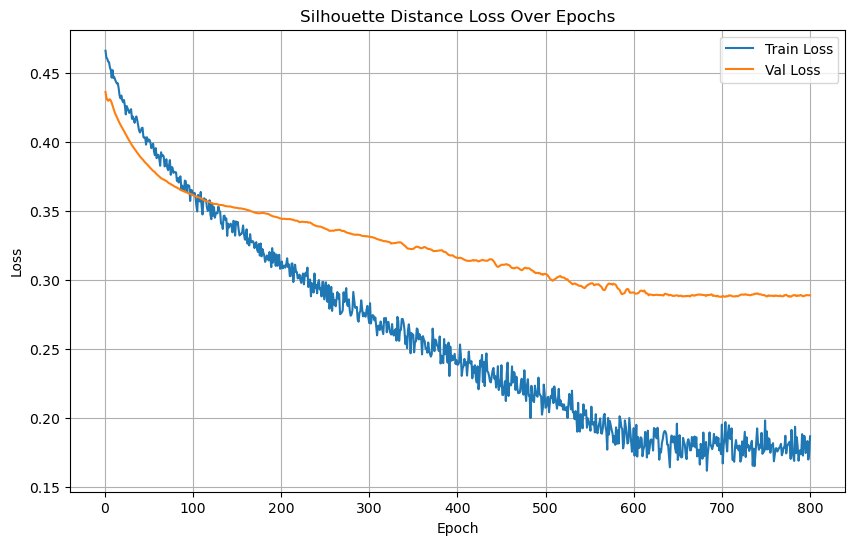

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/663], Loss: 0.2383


Test Batch [20/663], Loss: 0.1845
Test Batch [30/663], Loss: 0.2458
Test Batch [40/663], Loss: 0.5421


Test Batch [50/663], Loss: 0.2478


Test Batch [60/663], Loss: 0.4093
Test Batch [70/663], Loss: 0.2005
Test Batch [80/663], Loss: 0.2343


Test Batch [90/663], Loss: 0.1656


Test Batch [100/663], Loss: 0.1498
Test Batch [110/663], Loss: 0.1435
Test Batch [120/663], Loss: 0.1740
Test Batch [130/663], Loss: 0.1987


Test Batch [140/663], Loss: 0.2748
Test Batch [150/663], Loss: 0.1236
Test Batch [160/663], Loss: 0.2297
Test Batch [170/663], Loss: 0.2869
Test Batch [180/663], Loss: 0.5000
Test Batch [190/663], Loss: 0.5000
Test Batch [200/663], Loss: 0.1021
Test Batch [210/663], Loss: 0.5000


Test Batch [220/663], Loss: 0.5000
Test Batch [230/663], Loss: 0.1250
Test Batch [240/663], Loss: 0.5000
Test Batch [250/663], Loss: 0.5000
Test Batch [260/663], Loss: 0.5000
Test Batch [270/663], Loss: 0.5000
Test Batch [280/663], Loss: 0.5000
Test Batch [290/663], Loss: 0.5000
Test Batch [300/663], Loss: 0.2056
Test Batch [310/663], Loss: 0.1214


Test Batch [320/663], Loss: 0.2143
Test Batch [330/663], Loss: 0.2402
Test Batch [340/663], Loss: 0.1687


Test Batch [350/663], Loss: 0.1670
Test Batch [360/663], Loss: 0.1684
Test Batch [370/663], Loss: 0.0982


Test Batch [380/663], Loss: 0.1422
Test Batch [390/663], Loss: 0.1371
Test Batch [400/663], Loss: 0.1407


Test Batch [410/663], Loss: 0.1229
Test Batch [420/663], Loss: 0.1192
Test Batch [430/663], Loss: 0.2658


Test Batch [440/663], Loss: 0.2662
Test Batch [450/663], Loss: 0.3262
Test Batch [460/663], Loss: 0.3233


Test Batch [470/663], Loss: 0.2877
Test Batch [480/663], Loss: 0.1725
Test Batch [490/663], Loss: 0.2267


Test Batch [500/663], Loss: 0.1928
Test Batch [510/663], Loss: 0.1175
Test Batch [520/663], Loss: 0.2135
Test Batch [530/663], Loss: 0.2547


Test Batch [540/663], Loss: 0.2773
Test Batch [550/663], Loss: 0.2691
Test Batch [560/663], Loss: 0.2212


Test Batch [570/663], Loss: 0.2397
Test Batch [580/663], Loss: 0.1417
Test Batch [590/663], Loss: 0.3184
Test Batch [600/663], Loss: 0.3373
Test Batch [610/663], Loss: 0.2792


Test Batch [620/663], Loss: 0.2158
Test Batch [630/663], Loss: 0.2283
Test Batch [640/663], Loss: 0.2863
Test Batch [650/663], Loss: 0.3195


Test Batch [660/663], Loss: 0.4611

Test Loss: 0.2741


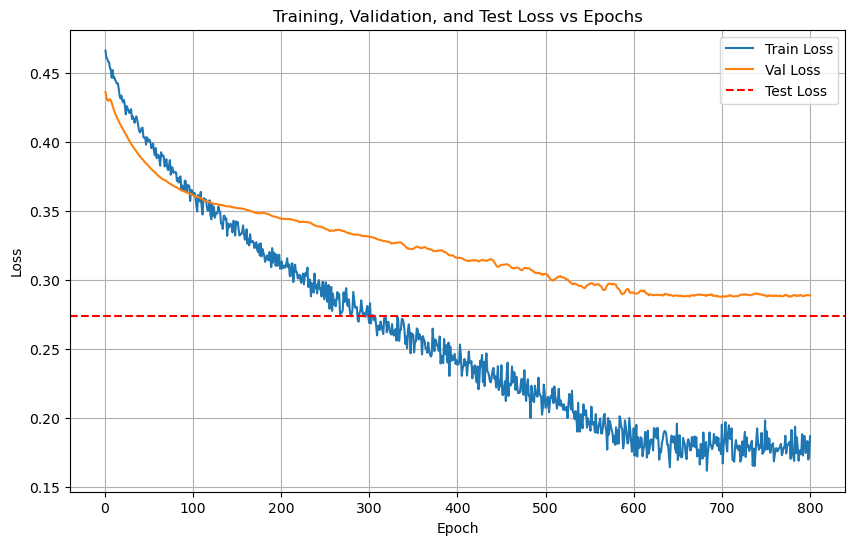

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/663 for test dataset.


  Processed batch 20/663 for test dataset.


  Processed batch 30/663 for test dataset.
  Processed batch 40/663 for test dataset.


  Processed batch 50/663 for test dataset.


  Processed batch 60/663 for test dataset.
  Processed batch 70/663 for test dataset.


  Processed batch 80/663 for test dataset.
  Processed batch 90/663 for test dataset.


  Processed batch 100/663 for test dataset.


  Processed batch 110/663 for test dataset.
  Processed batch 120/663 for test dataset.


  Processed batch 130/663 for test dataset.


  Processed batch 140/663 for test dataset.


  Processed batch 150/663 for test dataset.
  Processed batch 160/663 for test dataset.


  Processed batch 170/663 for test dataset.
  Processed batch 180/663 for test dataset.


  Processed batch 190/663 for test dataset.


  Processed batch 200/663 for test dataset.
  Processed batch 210/663 for test dataset.
  Processed batch 220/663 for test dataset.


  Processed batch 230/663 for test dataset.


  Processed batch 240/663 for test dataset.
  Processed batch 250/663 for test dataset.


  Processed batch 260/663 for test dataset.


  Processed batch 270/663 for test dataset.
  Processed batch 280/663 for test dataset.
  Processed batch 290/663 for test dataset.


  Processed batch 300/663 for test dataset.
  Processed batch 310/663 for test dataset.


  Processed batch 320/663 for test dataset.
  Processed batch 330/663 for test dataset.
  Processed batch 340/663 for test dataset.


  Processed batch 350/663 for test dataset.
  Processed batch 360/663 for test dataset.
  Processed batch 370/663 for test dataset.
  Processed batch 380/663 for test dataset.


  Processed batch 390/663 for test dataset.
  Processed batch 400/663 for test dataset.
  Processed batch 410/663 for test dataset.


  Processed batch 420/663 for test dataset.
  Processed batch 430/663 for test dataset.
  Processed batch 440/663 for test dataset.
  Processed batch 450/663 for test dataset.


  Processed batch 460/663 for test dataset.
  Processed batch 470/663 for test dataset.
  Processed batch 480/663 for test dataset.
  Processed batch 490/663 for test dataset.


  Processed batch 500/663 for test dataset.
  Processed batch 510/663 for test dataset.
  Processed batch 520/663 for test dataset.
  Processed batch 530/663 for test dataset.


  Processed batch 540/663 for test dataset.
  Processed batch 550/663 for test dataset.


  Processed batch 560/663 for test dataset.
  Processed batch 570/663 for test dataset.
  Processed batch 580/663 for test dataset.


  Processed batch 590/663 for test dataset.
  Processed batch 600/663 for test dataset.
  Processed batch 610/663 for test dataset.


  Processed batch 620/663 for test dataset.
  Processed batch 630/663 for test dataset.
  Processed batch 640/663 for test dataset.
  Processed batch 650/663 for test dataset.


  Processed batch 660/663 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.75      0.60      0.67         5
           2       0.57      0.80      0.67         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.83      1.00      0.91         5
           7       1.00      0.40      0.57         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.84      0.82      0.81        45
weighted avg       0.84      0.82      0.81        45


LOG: Evaluating on the test set...
Test Accuracy: 71.06%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4585  |  Val Loss: 2.4074
Validation loss improved from inf to 2.4074.
[Epoch 2/1000] Train Loss: 2.3284  |  Val Loss: 2.2938
Validation loss improved from 2.4074 to 2.2938.
[Epoch 3/1000] Train Loss: 2.2160  |  Val Loss: 2.1917
Validation loss improved from 2.2938 to 2.1917.
[Epoch 4/1000] Train Loss: 2.1141  |  Val Loss: 2.0991
Validation loss improved from 2.1917 to 2.0991.
[Epoch 5/1000] Train Loss: 2.0231  |  Val Loss: 2.0193
Validation loss improved from 2.0991 to 2.0193.
[Epoch 6/1000] Train Loss: 1.9452  |  Val Loss: 1.9511
Validation loss improved from 2.0193 to 1.9511.
[Epoch 7/1000] Train Loss: 1.8769  |  Val Loss: 1.8938
Validation loss improved from 1.9511 to 1.8938.
[Epoch 8/1000] Train Loss: 1.8183  |  Val Loss: 1.8482
Validation loss improved from 1.8938 to 1.8482.
[Epoch 9/1000] Train Loss: 1.7707  |  Val Loss: 1.8109
Validation loss improved from 1.8482 to 1.8109.
[Epoch 10/1000] Train Loss: 1.7277  |  Val Loss: 1.7772
Validation loss impr

[Epoch 13/1000] Train Loss: 1.6270  |  Val Loss: 1.6996
Validation loss improved from 1.7217 to 1.6996.
[Epoch 14/1000] Train Loss: 1.5990  |  Val Loss: 1.6791
Validation loss improved from 1.6996 to 1.6791.
[Epoch 15/1000] Train Loss: 1.5735  |  Val Loss: 1.6588
Validation loss improved from 1.6791 to 1.6588.
[Epoch 16/1000] Train Loss: 1.5488  |  Val Loss: 1.6379
Validation loss improved from 1.6588 to 1.6379.


[Epoch 17/1000] Train Loss: 1.5252  |  Val Loss: 1.6203
Validation loss improved from 1.6379 to 1.6203.
[Epoch 18/1000] Train Loss: 1.5022  |  Val Loss: 1.6011
Validation loss improved from 1.6203 to 1.6011.
[Epoch 19/1000] Train Loss: 1.4791  |  Val Loss: 1.5833
Validation loss improved from 1.6011 to 1.5833.
[Epoch 20/1000] Train Loss: 1.4565  |  Val Loss: 1.5659
Validation loss improved from 1.5833 to 1.5659.
[Epoch 21/1000] Train Loss: 1.4355  |  Val Loss: 1.5496
Validation loss improved from 1.5659 to 1.5496.
[Epoch 22/1000] Train Loss: 1.4145  |  Val Loss: 1.5334
Validation loss improved from 1.5496 to 1.5334.
[Epoch 23/1000] Train Loss: 1.3934  |  Val Loss: 1.5176
Validation loss improved from 1.5334 to 1.5176.
[Epoch 24/1000] Train Loss: 1.3726  |  Val Loss: 1.5018
Validation loss improved from 1.5176 to 1.5018.
[Epoch 25/1000] Train Loss: 1.3511  |  Val Loss: 1.4876
Validation loss improved from 1.5018 to 1.4876.
[Epoch 26/1000] Train Loss: 1.3312  |  Val Loss: 1.4732
Validati

[Epoch 32/1000] Train Loss: 1.2131  |  Val Loss: 1.3884
Validation loss improved from 1.4021 to 1.3884.
[Epoch 33/1000] Train Loss: 1.1943  |  Val Loss: 1.3742
Validation loss improved from 1.3884 to 1.3742.
[Epoch 34/1000] Train Loss: 1.1754  |  Val Loss: 1.3603
Validation loss improved from 1.3742 to 1.3603.
[Epoch 35/1000] Train Loss: 1.1565  |  Val Loss: 1.3462
Validation loss improved from 1.3603 to 1.3462.
[Epoch 36/1000] Train Loss: 1.1378  |  Val Loss: 1.3328
Validation loss improved from 1.3462 to 1.3328.
[Epoch 37/1000] Train Loss: 1.1195  |  Val Loss: 1.3193
Validation loss improved from 1.3328 to 1.3193.
[Epoch 38/1000] Train Loss: 1.1011  |  Val Loss: 1.3052
Validation loss improved from 1.3193 to 1.3052.
[Epoch 39/1000] Train Loss: 1.0827  |  Val Loss: 1.2911
Validation loss improved from 1.3052 to 1.2911.
[Epoch 40/1000] Train Loss: 1.0646  |  Val Loss: 1.2770
Validation loss improved from 1.2911 to 1.2770.
[Epoch 41/1000] Train Loss: 1.0461  |  Val Loss: 1.2629
Validati

[Epoch 49/1000] Train Loss: 0.9020  |  Val Loss: 1.1498
Validation loss improved from 1.1643 to 1.1498.
[Epoch 50/1000] Train Loss: 0.8840  |  Val Loss: 1.1361
Validation loss improved from 1.1498 to 1.1361.
[Epoch 51/1000] Train Loss: 0.8658  |  Val Loss: 1.1215
Validation loss improved from 1.1361 to 1.1215.
[Epoch 52/1000] Train Loss: 0.8477  |  Val Loss: 1.1064
Validation loss improved from 1.1215 to 1.1064.
[Epoch 53/1000] Train Loss: 0.8296  |  Val Loss: 1.0916
Validation loss improved from 1.1064 to 1.0916.
[Epoch 54/1000] Train Loss: 0.8110  |  Val Loss: 1.0772
Validation loss improved from 1.0916 to 1.0772.
[Epoch 55/1000] Train Loss: 0.7932  |  Val Loss: 1.0623
Validation loss improved from 1.0772 to 1.0623.
[Epoch 56/1000] Train Loss: 0.7748  |  Val Loss: 1.0474
Validation loss improved from 1.0623 to 1.0474.
[Epoch 57/1000] Train Loss: 0.7569  |  Val Loss: 1.0321
Validation loss improved from 1.0474 to 1.0321.
[Epoch 58/1000] Train Loss: 0.7389  |  Val Loss: 1.0175
Validati

[Epoch 64/1000] Train Loss: 0.6345  |  Val Loss: 0.9342
Validation loss improved from 0.9478 to 0.9342.
[Epoch 65/1000] Train Loss: 0.6182  |  Val Loss: 0.9213
Validation loss improved from 0.9342 to 0.9213.
[Epoch 66/1000] Train Loss: 0.6017  |  Val Loss: 0.9087
Validation loss improved from 0.9213 to 0.9087.
[Epoch 67/1000] Train Loss: 0.5859  |  Val Loss: 0.8959
Validation loss improved from 0.9087 to 0.8959.
[Epoch 68/1000] Train Loss: 0.5702  |  Val Loss: 0.8844
Validation loss improved from 0.8959 to 0.8844.
[Epoch 69/1000] Train Loss: 0.5547  |  Val Loss: 0.8727
Validation loss improved from 0.8844 to 0.8727.
[Epoch 70/1000] Train Loss: 0.5393  |  Val Loss: 0.8624
Validation loss improved from 0.8727 to 0.8624.
[Epoch 71/1000] Train Loss: 0.5240  |  Val Loss: 0.8516
Validation loss improved from 0.8624 to 0.8516.
[Epoch 72/1000] Train Loss: 0.5095  |  Val Loss: 0.8410
Validation loss improved from 0.8516 to 0.8410.
[Epoch 73/1000] Train Loss: 0.4950  |  Val Loss: 0.8301
Validati

[Epoch 81/1000] Train Loss: 0.3961  |  Val Loss: 0.7625
Validation loss improved from 0.7696 to 0.7625.
[Epoch 82/1000] Train Loss: 0.3856  |  Val Loss: 0.7565
Validation loss improved from 0.7625 to 0.7565.
[Epoch 83/1000] Train Loss: 0.3754  |  Val Loss: 0.7500
Validation loss improved from 0.7565 to 0.7500.
[Epoch 84/1000] Train Loss: 0.3657  |  Val Loss: 0.7433
Validation loss improved from 0.7500 to 0.7433.
[Epoch 85/1000] Train Loss: 0.3565  |  Val Loss: 0.7375
Validation loss improved from 0.7433 to 0.7375.
[Epoch 86/1000] Train Loss: 0.3476  |  Val Loss: 0.7320
Validation loss improved from 0.7375 to 0.7320.
[Epoch 87/1000] Train Loss: 0.3390  |  Val Loss: 0.7271
Validation loss improved from 0.7320 to 0.7271.
[Epoch 88/1000] Train Loss: 0.3307  |  Val Loss: 0.7220
Validation loss improved from 0.7271 to 0.7220.
[Epoch 89/1000] Train Loss: 0.3227  |  Val Loss: 0.7170
Validation loss improved from 0.7220 to 0.7170.
[Epoch 90/1000] Train Loss: 0.3150  |  Val Loss: 0.7123
Validati

[Epoch 98/1000] Train Loss: 0.2632  |  Val Loss: 0.6842
Validation loss improved from 0.6877 to 0.6842.
[Epoch 99/1000] Train Loss: 0.2577  |  Val Loss: 0.6805
Validation loss improved from 0.6842 to 0.6805.
[Epoch 100/1000] Train Loss: 0.2524  |  Val Loss: 0.6768
Validation loss improved from 0.6805 to 0.6768.
[Epoch 101/1000] Train Loss: 0.2475  |  Val Loss: 0.6736
Validation loss improved from 0.6768 to 0.6736.
[Epoch 102/1000] Train Loss: 0.2427  |  Val Loss: 0.6709
Validation loss improved from 0.6736 to 0.6709.
[Epoch 103/1000] Train Loss: 0.2378  |  Val Loss: 0.6695
Validation loss improved from 0.6709 to 0.6695.
[Epoch 104/1000] Train Loss: 0.2333  |  Val Loss: 0.6679
Validation loss improved from 0.6695 to 0.6679.
[Epoch 105/1000] Train Loss: 0.2291  |  Val Loss: 0.6667
Validation loss improved from 0.6679 to 0.6667.
[Epoch 106/1000] Train Loss: 0.2250  |  Val Loss: 0.6645
Validation loss improved from 0.6667 to 0.6645.
[Epoch 107/1000] Train Loss: 0.2208  |  Val Loss: 0.6640


[Epoch 116/1000] Train Loss: 0.1898  |  Val Loss: 0.6505
Validation loss improved from 0.6517 to 0.6505.
[Epoch 117/1000] Train Loss: 0.1871  |  Val Loss: 0.6491
Validation loss improved from 0.6505 to 0.6491.
[Epoch 118/1000] Train Loss: 0.1844  |  Val Loss: 0.6495
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.1815  |  Val Loss: 0.6491
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 0.1792  |  Val Loss: 0.6490
Validation loss improved from 0.6491 to 0.6490.
[Epoch 121/1000] Train Loss: 0.1764  |  Val Loss: 0.6478
Validation loss improved from 0.6490 to 0.6478.
[Epoch 122/1000] Train Loss: 0.1742  |  Val Loss: 0.6465
Validation loss improved from 0.6478 to 0.6465.
[Epoch 123/1000] Train Loss: 0.1722  |  Val Loss: 0.6445
Validation loss improved from 0.6465 to 0.6445.
[Epoch 124/1000] Train Loss: 0.1697  |  Val Loss: 0.6447
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 0.1675  

[Epoch 133/1000] Train Loss: 0.1525  |  Val Loss: 0.6458
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 134/1000] Train Loss: 0.1509  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 135/1000] Train Loss: 0.1491  |  Val Loss: 0.6466
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 136/1000] Train Loss: 0.1475  |  Val Loss: 0.6477
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 137/1000] Train Loss: 0.1461  |  Val Loss: 0.6484
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 138/1000] Train Loss: 0.1447  |  Val Loss: 0.6493
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 139/1000] Train Loss: 0.1433  |  Val Loss: 0.6477
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 140/1000] Train Loss: 0.1417  |  Val Loss: 0.6486
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 141/1000] Train Loss: 0.1405  |  Val Loss: 0.6507
!! Validation loss did NOT improve !! Patience:

[Epoch 151/1000] Train Loss: 0.1274  |  Val Loss: 0.6651
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 152/1000] Train Loss: 0.1263  |  Val Loss: 0.6660
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 153/1000] Train Loss: 0.1251  |  Val Loss: 0.6679
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 154/1000] Train Loss: 0.1242  |  Val Loss: 0.6696
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 155/1000] Train Loss: 0.1231  |  Val Loss: 0.6701
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 156/1000] Train Loss: 0.1221  |  Val Loss: 0.6710
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 157/1000] Train Loss: 0.1212  |  Val Loss: 0.6719
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 158/1000] Train Loss: 0.1201  |  Val Loss: 0.6725
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 159/1000] Train Loss: 0.1194  |  Val Loss: 0.6723
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.1116  |  Val Loss: 0.6847
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 169/1000] Train Loss: 0.1110  |  Val Loss: 0.6860
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 170/1000] Train Loss: 0.1103  |  Val Loss: 0.6880
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 171/1000] Train Loss: 0.1095  |  Val Loss: 0.6906
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 172/1000] Train Loss: 0.1087  |  Val Loss: 0.6924
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 173/1000] Train Loss: 0.1080  |  Val Loss: 0.6936
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 174/1000] Train Loss: 0.1073  |  Val Loss: 0.6961
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 175/1000] Train Loss: 0.1067  |  Val Loss: 0.6976
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 176/1000] Train Loss: 0.1060  |  Val Loss: 0.6984
!! Validation loss did NOT improve !! Patience:

[Epoch 184/1000] Train Loss: 0.1009  |  Val Loss: 0.7052
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 185/1000] Train Loss: 0.1004  |  Val Loss: 0.7069
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 186/1000] Train Loss: 0.0998  |  Val Loss: 0.7085
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 187/1000] Train Loss: 0.0993  |  Val Loss: 0.7100
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 188/1000] Train Loss: 0.0991  |  Val Loss: 0.7133
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 189/1000] Train Loss: 0.0981  |  Val Loss: 0.7145
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 190/1000] Train Loss: 0.0975  |  Val Loss: 0.7148
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 191/1000] Train Loss: 0.0970  |  Val Loss: 0.7160
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 192/1000] Train Loss: 0.0965  |  Val Loss: 0.7178
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.0919  |  Val Loss: 0.7296
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 202/1000] Train Loss: 0.0915  |  Val Loss: 0.7319
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 203/1000] Train Loss: 0.0911  |  Val Loss: 0.7328
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 204/1000] Train Loss: 0.0910  |  Val Loss: 0.7359
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 205/1000] Train Loss: 0.0903  |  Val Loss: 0.7361
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 206/1000] Train Loss: 0.0899  |  Val Loss: 0.7368
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 207/1000] Train Loss: 0.0894  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 208/1000] Train Loss: 0.0889  |  Val Loss: 0.7387
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 209/1000] Train Loss: 0.0884  |  Val Loss: 0.7408
!! Validation loss did NOT improve !! Patience:

[Epoch 219/1000] Train Loss: 0.0845  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 220/1000] Train Loss: 0.0841  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 221/1000] Train Loss: 0.0837  |  Val Loss: 0.7546
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 222/1000] Train Loss: 0.0834  |  Val Loss: 0.7566
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 223/1000] Train Loss: 0.0830  |  Val Loss: 0.7587
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 223 !!
No improvement for 100 epochs.


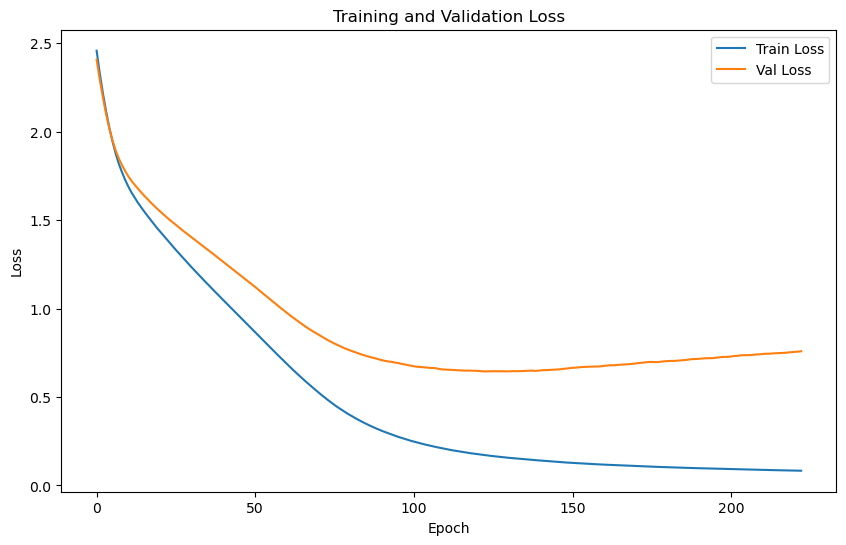

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9855 | Test Accuracy: 72.28%


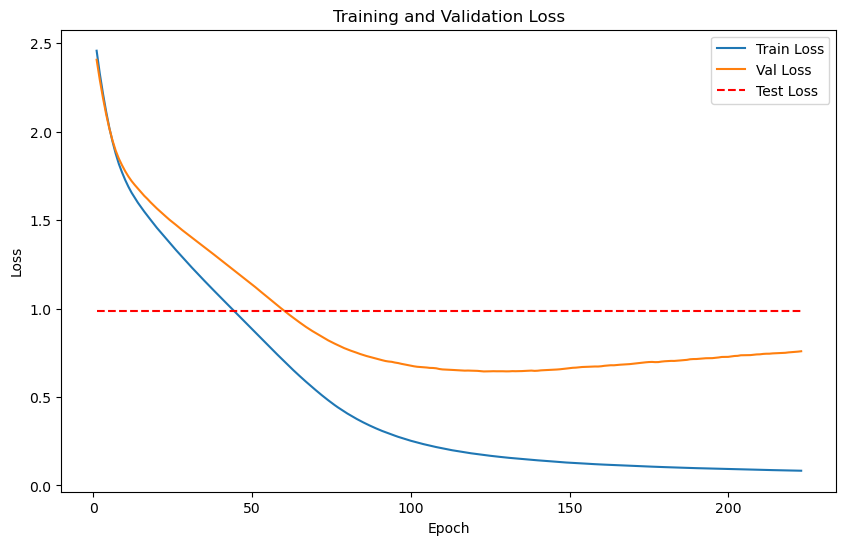

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


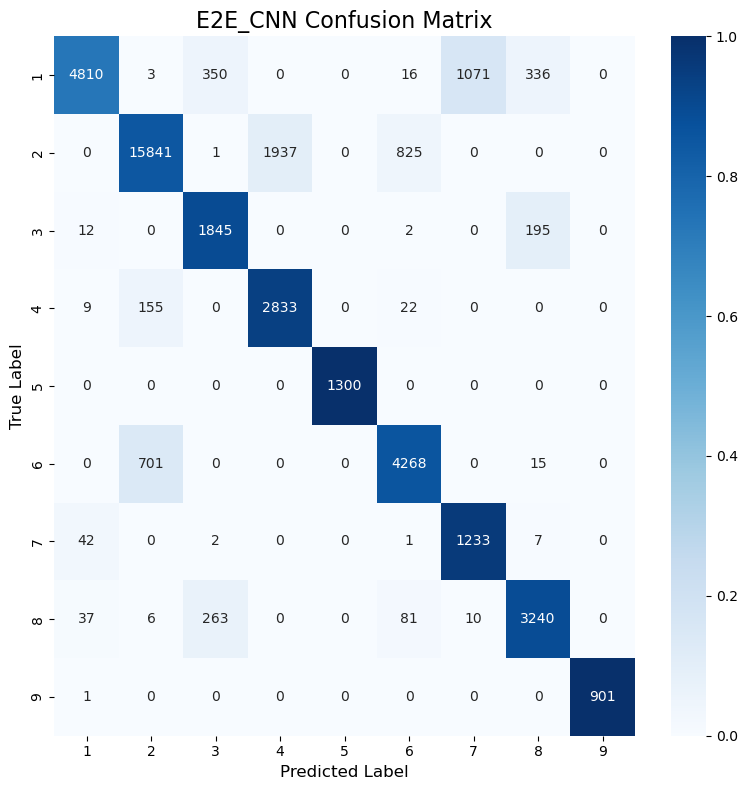

Classification Accuracy: 85.60%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


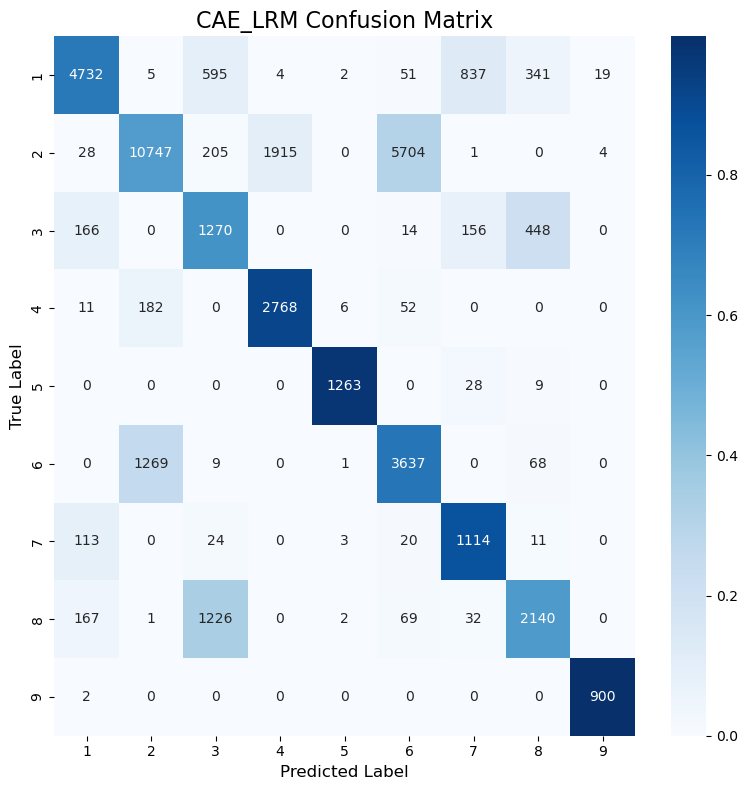

Classification Accuracy: 67.43%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


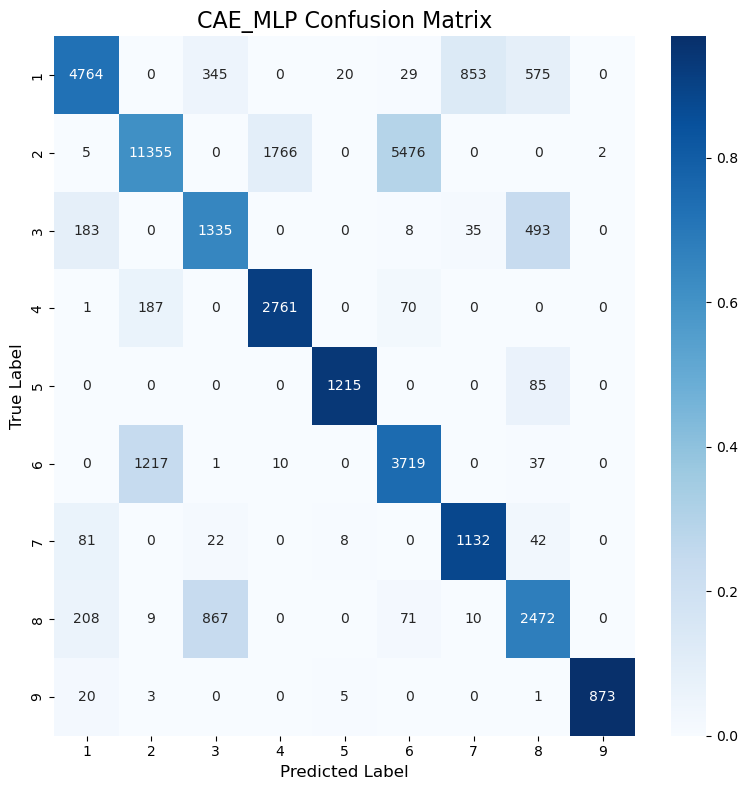

Classification Accuracy: 69.92%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


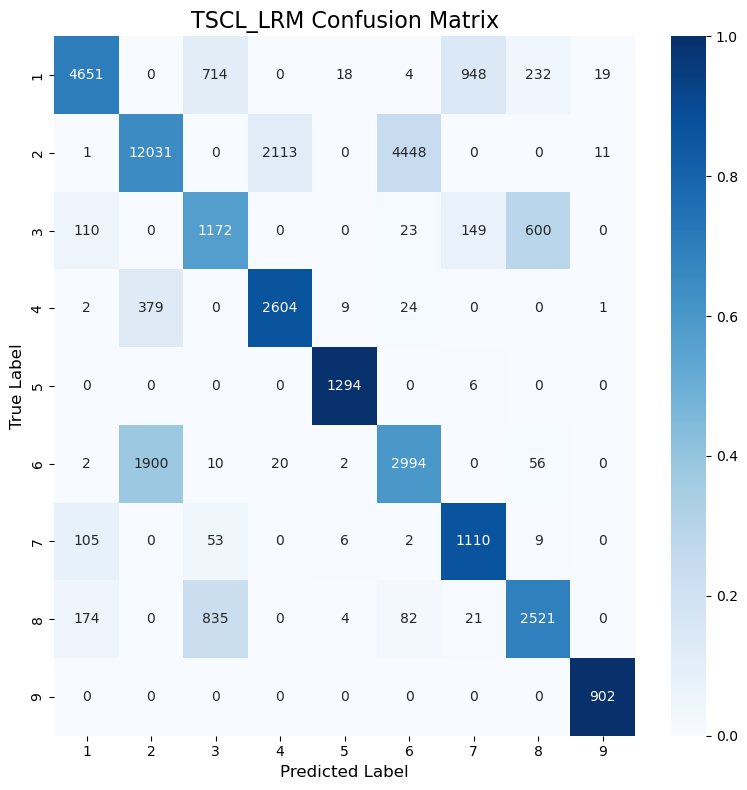

Classification Accuracy: 69.10%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


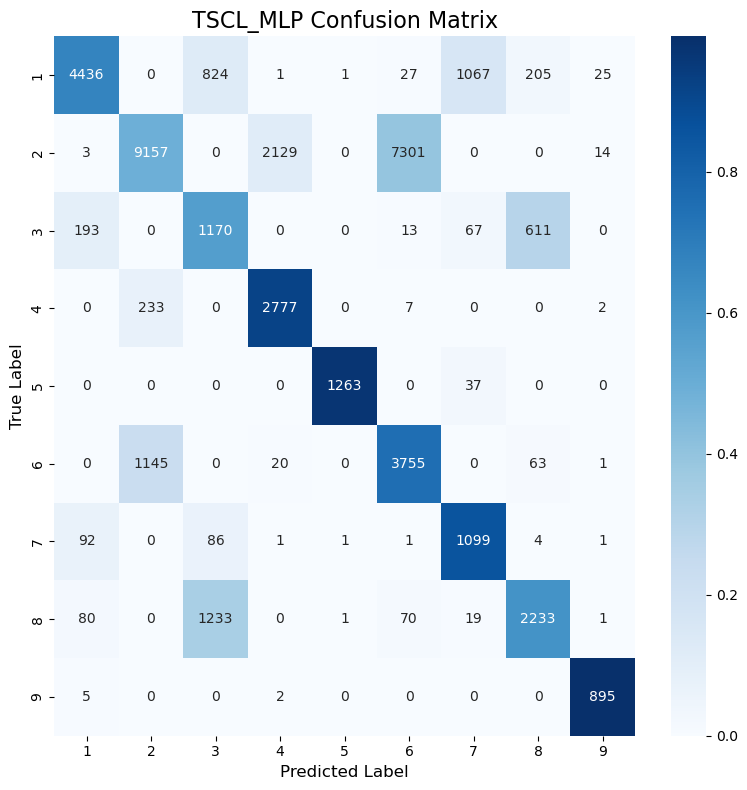

Classification Accuracy: 63.22%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


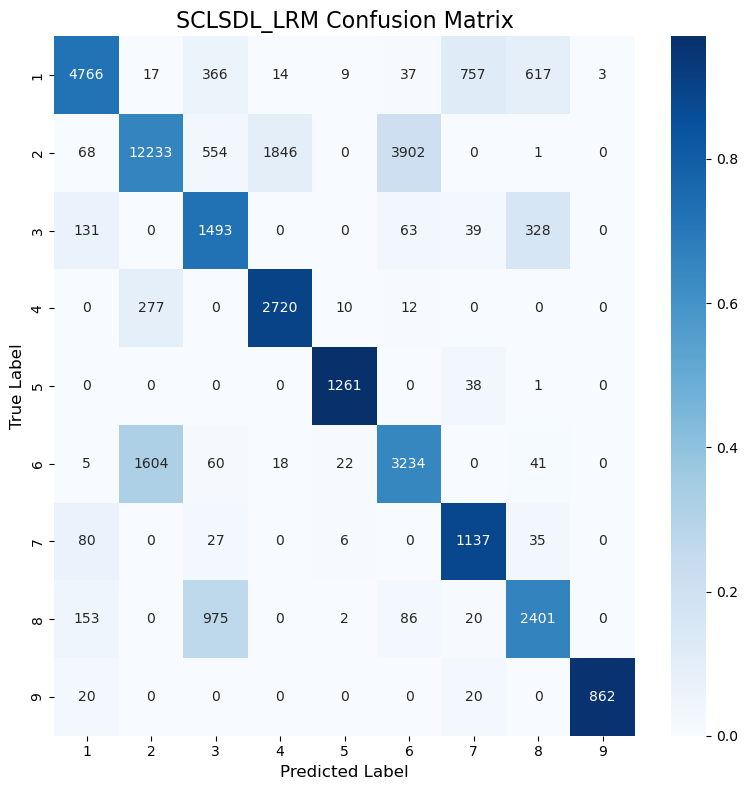

Classification Accuracy: 71.06%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


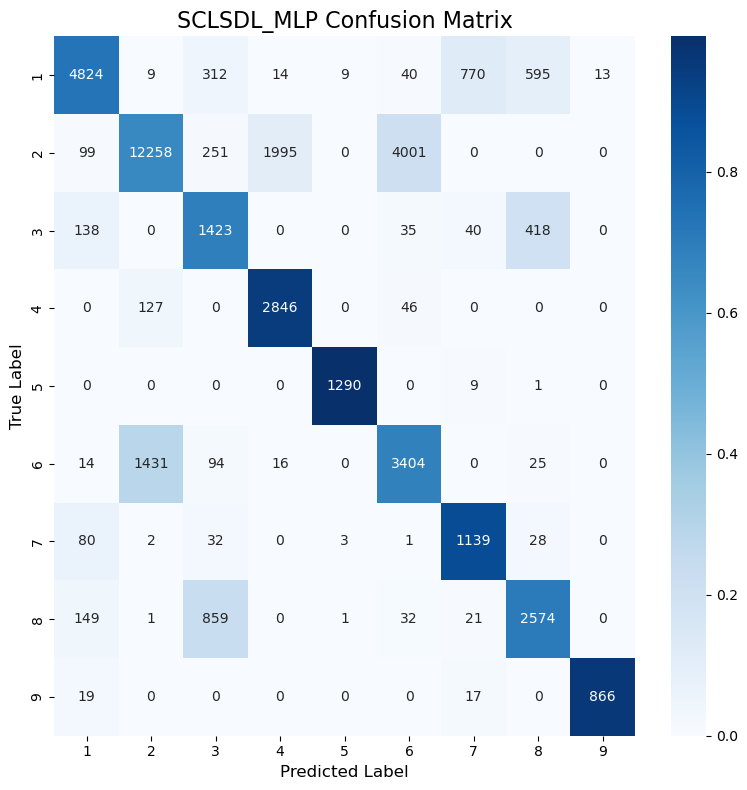

Classification Accuracy: 72.28%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          85.60
1    LRM (CAE)          67.43
2    MLP (CAE)          69.92
3     TSCL LRM          69.10
4     TSCL MLP          63.22
5  SCL_SDL LRM          71.06
6  SCL_SDL MLP          72.28

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          85.60
6  SCL_SDL MLP          72.28
5  SCL_SDL LRM          71.06
2    MLP (CAE)          69.92
3     TSCL LRM          69.10
1    LRM (CAE)          67.43
4     TSCL MLP          63.22
